In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from pgmpy.estimators import PC
import pingouin
import matplotlib.pyplot as plt
import seaborn as sns
from linearmodels.panel import PanelOLS, PooledOLS
from itertools import combinations
from linearmodels.panel import compare
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
from abbeyFunctions import graph_DAG, create_cluster_dags, determine_p_value, graph_DAG_cluster, get_edges_dict, get_col_shared_edges, get_row_shared_edges, plot_shared_edges, plot_shared_col_edges, plot_shared_row_edges, hausman_test

In [4]:
from abiFunctions import calculate_aic, calculate_bic, calculate_hqic, get_model_summary, plot_residuals_vs_predicted, plot_residuals_vs_independent_vars, forward_stepwise_selection, backward_stepwise_selection, plot_residuals_vs_dependent_var, calculate_avg_squared_correlations

Import the nominal data and set index as fipcodes and timeperiod

In [5]:
ai_data_nominal = pd.read_csv('nominal_data.csv')

In [6]:
ai_data_nominal = ai_data_nominal.rename(columns={'FIPS_y': 'FIPS'})

In [7]:
ai_data_nominal = ai_data_nominal.set_index(['FIPS', 'TimePeriod'])

Create dictionary to store the different levels of the data (level, logged, rate, differenced rates)

In [8]:
exclude_vars = ['M4 I','RM4I', 'unem']  # List of variables to exclude

# Create a dictionary to store the dataframes
ai_dct = {"logged": ai_data_nominal.copy(),
          "rates": ai_data_nominal.copy(),
         "percent rates": ai_data_nominal.copy()}

        
for col in ai_dct['logged'].columns:
    if col not in exclude_vars:
        ai_dct["logged"][col] = np.log(ai_data_nominal[col]).replace([np.inf, -np.inf], np.nan)


# Calculate rate of change (differences of log-transformed values)
for col in ai_dct['rates'].columns:
    if col not in exclude_vars:
        ai_dct["rates"][col] = ai_dct["logged"].groupby('FIPS')[col].diff().dropna()
                
        
        # Calculate percent rate of change
for col in ai_dct['percent rates'].columns:
    #if col not in exclude_vars:
        ai_dct["percent rates"][col] = ai_dct["rates"].groupby('FIPS')[col].diff().dropna()


Call nominal differenced rates from the dictionary ai_dct

In [9]:
diff_nominal = ai_dct['percent rates']

diff_nominal.drop(columns=['All ', 'Neig'], inplace=True)

Rename some columns in the dataframe

In [10]:
diff_nominal = diff_nominal.rename(columns={'M4_y': 'M4', 'M4 I':'M4I'}).dropna()

Import dataframe that includes clusters and merge with diff_nominal dataframe to form a single dataframe that includes the nominal differenced rates and clusters for each county

In [11]:
diff_nominal_clusters = pd.read_csv('diff_nominal_kml3d.csv')

diff_nominal_clusters = diff_nominal_clusters.rename(columns={'FIPS_y': 'FIPS'})

In [12]:
full_df_cluster = pd.merge(diff_nominal, diff_nominal_clusters[['FIPS', 'clusters']], on='FIPS', how='left')

In [13]:
full_df_cluster = full_df_cluster.dropna()

full_df_cluster = full_df_cluster.set_index(['FIPS'])

In [14]:
cluster_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4}

full_df_cluster now represents the full dataframe that includes nominal differenced rates and clusters

In [15]:
full_df_cluster['clusters'].replace(cluster_mapping, inplace=True)

In [16]:
diff_nominal = diff_nominal.reset_index()

In [17]:
full_df_cluster = full_df_cluster.reset_index()

In [18]:
full_df_cluster = pd.merge(diff_nominal, full_df_cluster[['FIPS', 'clusters']], on='FIPS', how='left')

In [19]:
# Drop exactly duplicated rows
full_df_cluster = full_df_cluster.drop_duplicates()

Create a dictionary for plotting the full directed acylcic graphs (DAGs) for the full dataframe for the nominal differenced rates

In [20]:
nominal_differenced_rate_with_all_variables = diff_nominal.dropna()

# Create a dictionary to store the DataFrames
nominal_differenced_rates = {}

nominal_differenced_rates['including_all_variables'] = nominal_differenced_rate_with_all_variables

nominal_differenced_rates['without_monetary_variables'] = nominal_differenced_rate_with_all_variables.drop(columns=['M4', 'M4I'])

nominal_differenced_rates['without_unemployment_variable'] = nominal_differenced_rate_with_all_variables.drop(columns=['unem'])

Plot the DAGs for the full dataframes for the three combinations of variables selected

  0%|          | 0/6 [00:00<?, ?it/s]

('M4', 'unem') []
keep control: Mini
('unem', 'M4I') ['Mini']
('unem', 'Mini') []
keep control: unem
('Mini', 'M4I') ['unem']
keep control: Agri
('Util', 'M4') ['Agri']
keep control: Util
('Agri', 'M4') ['Util']


  0%|          | 0/4 [00:00<?, ?it/s]

keep control: Mini
keep control: Util
('Agri', 'unem') ['Mini', 'Util']
keep control: Agri
keep control: Util
('Mini', 'unem') ['Agri', 'Util']
keep control: Agri
keep control: Mini
('Util', 'unem') ['Agri', 'Mini']


  0%|          | 0/5 [00:00<?, ?it/s]

keep control: M4I
keep control: Util
keep control: Agri
('Mini', 'M4') ['M4I', 'Util', 'Agri']
('Mini', 'M4I') []
keep control: Mini
keep control: Util
keep control: Agri
('M4I', 'M4') ['Mini', 'Util', 'Agri']
('M4I', 'Mini') []
keep control: Mini
keep control: M4I
keep control: Agri
('Util', 'M4') ['Mini', 'M4I', 'Agri']
keep control: Mini
keep control: M4I
keep control: Util
('Agri', 'M4') ['Mini', 'M4I', 'Util']


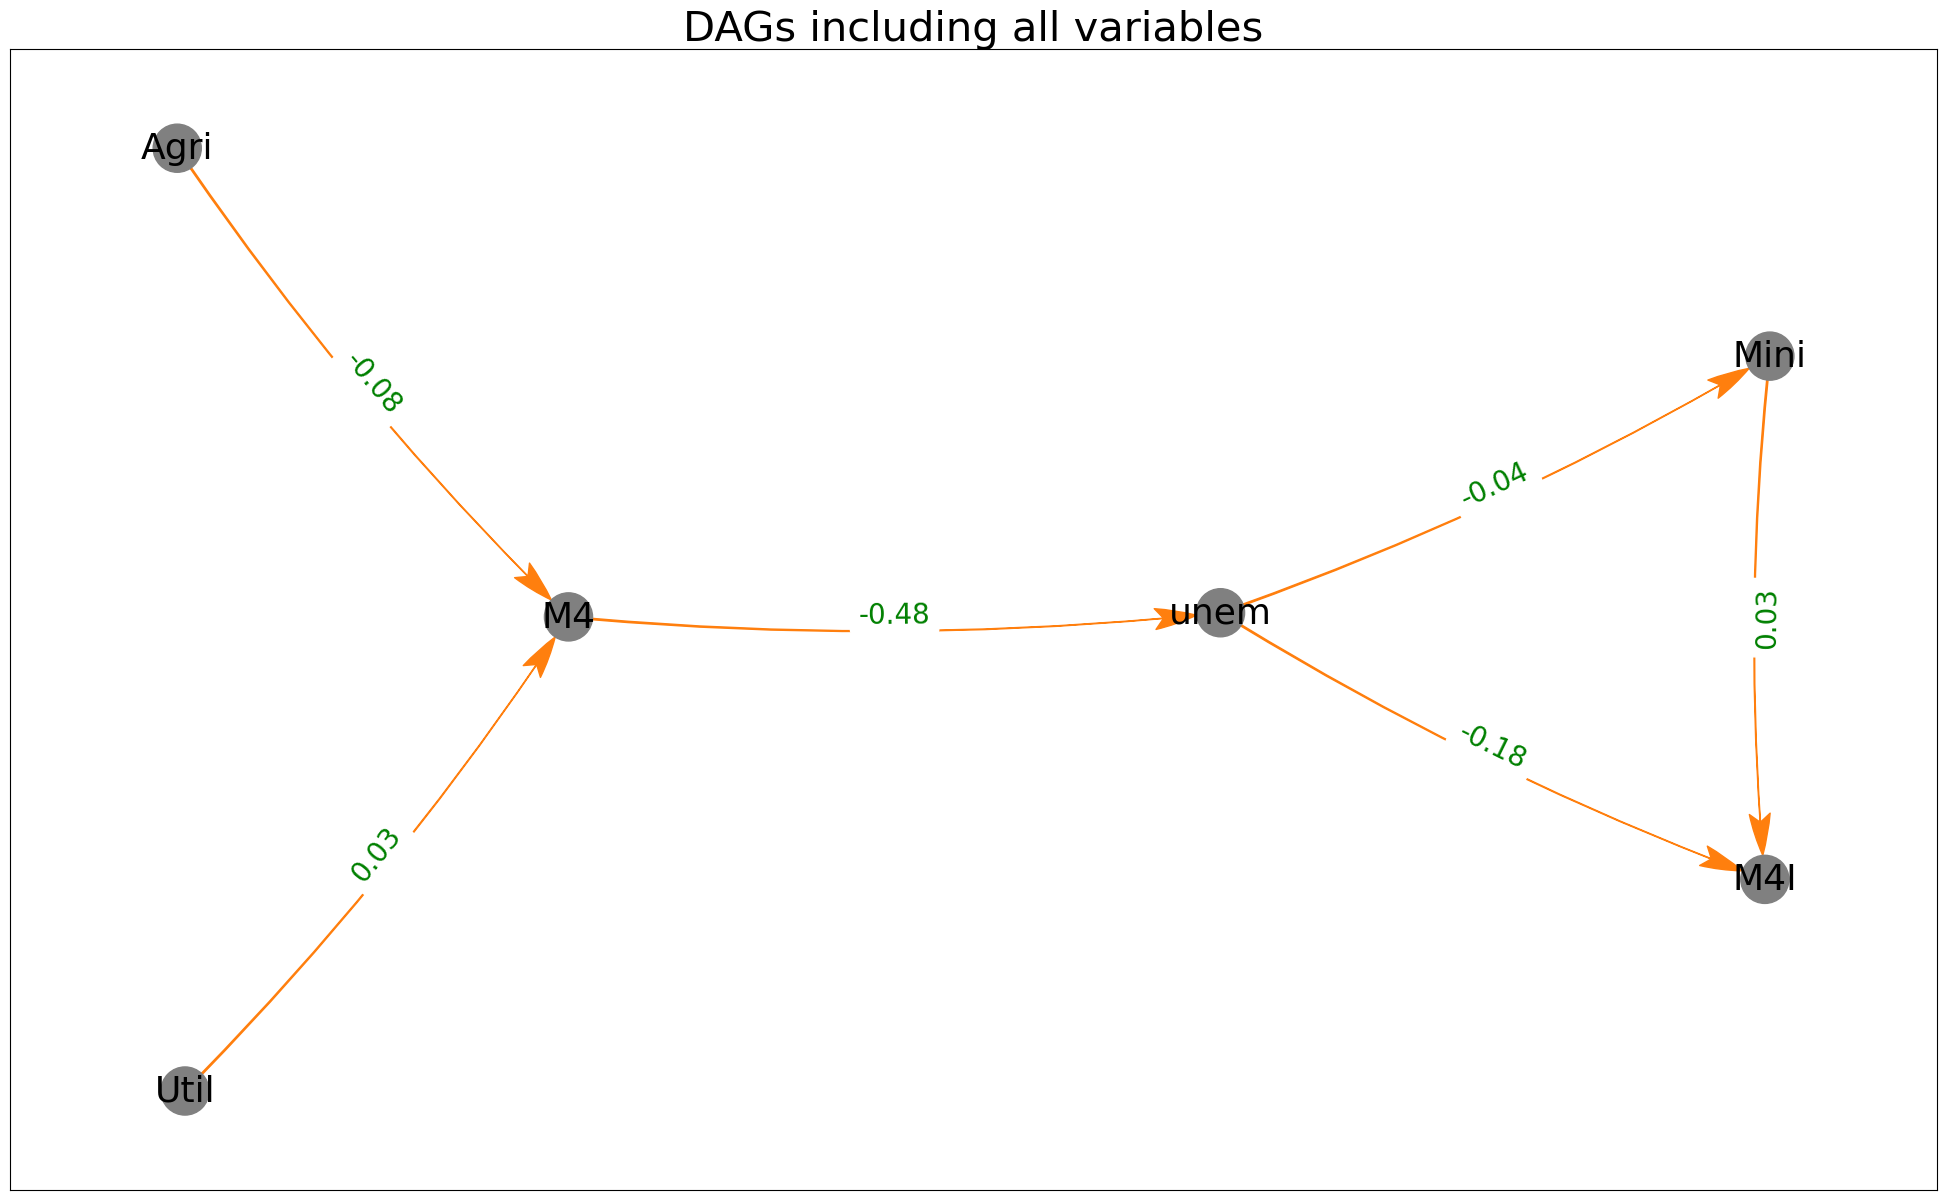

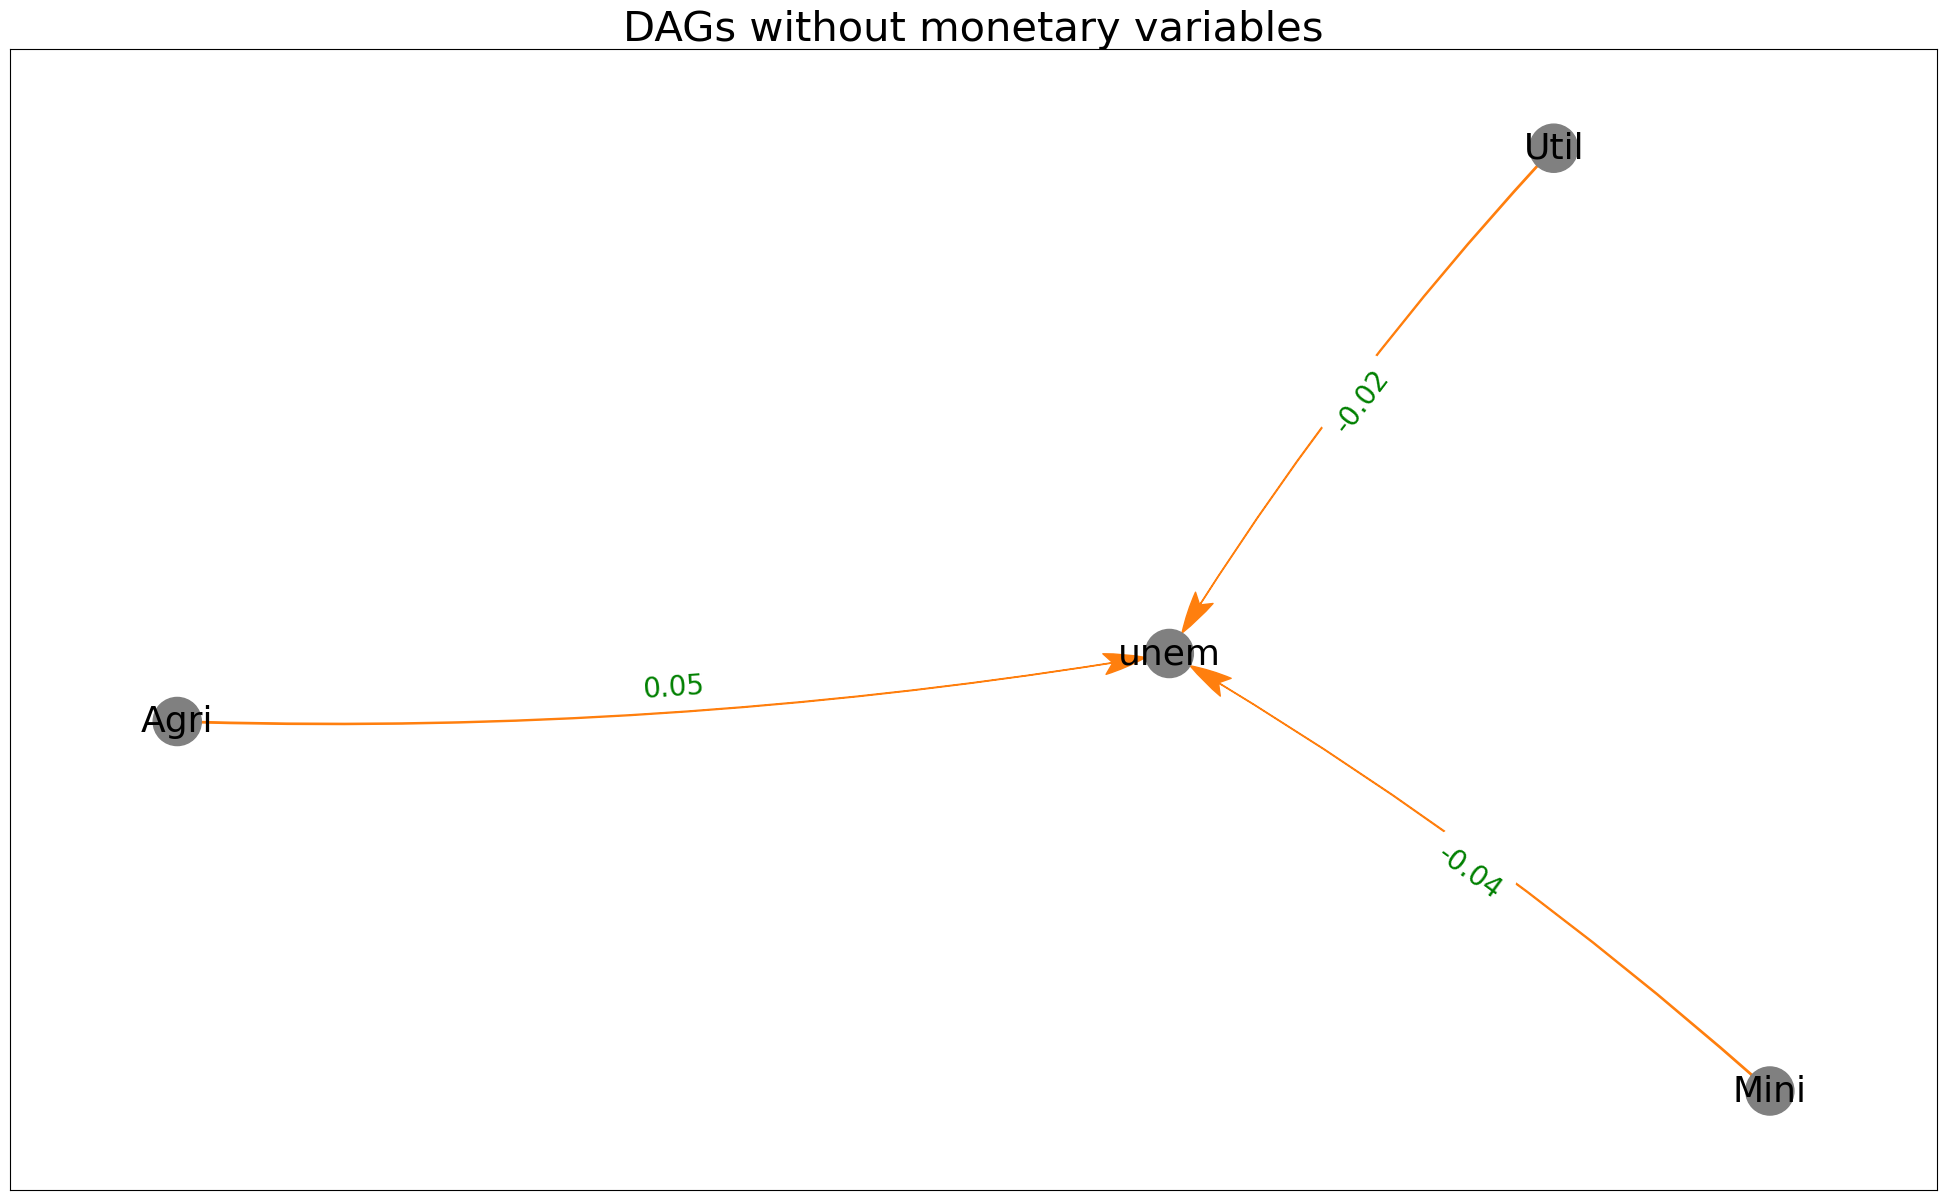

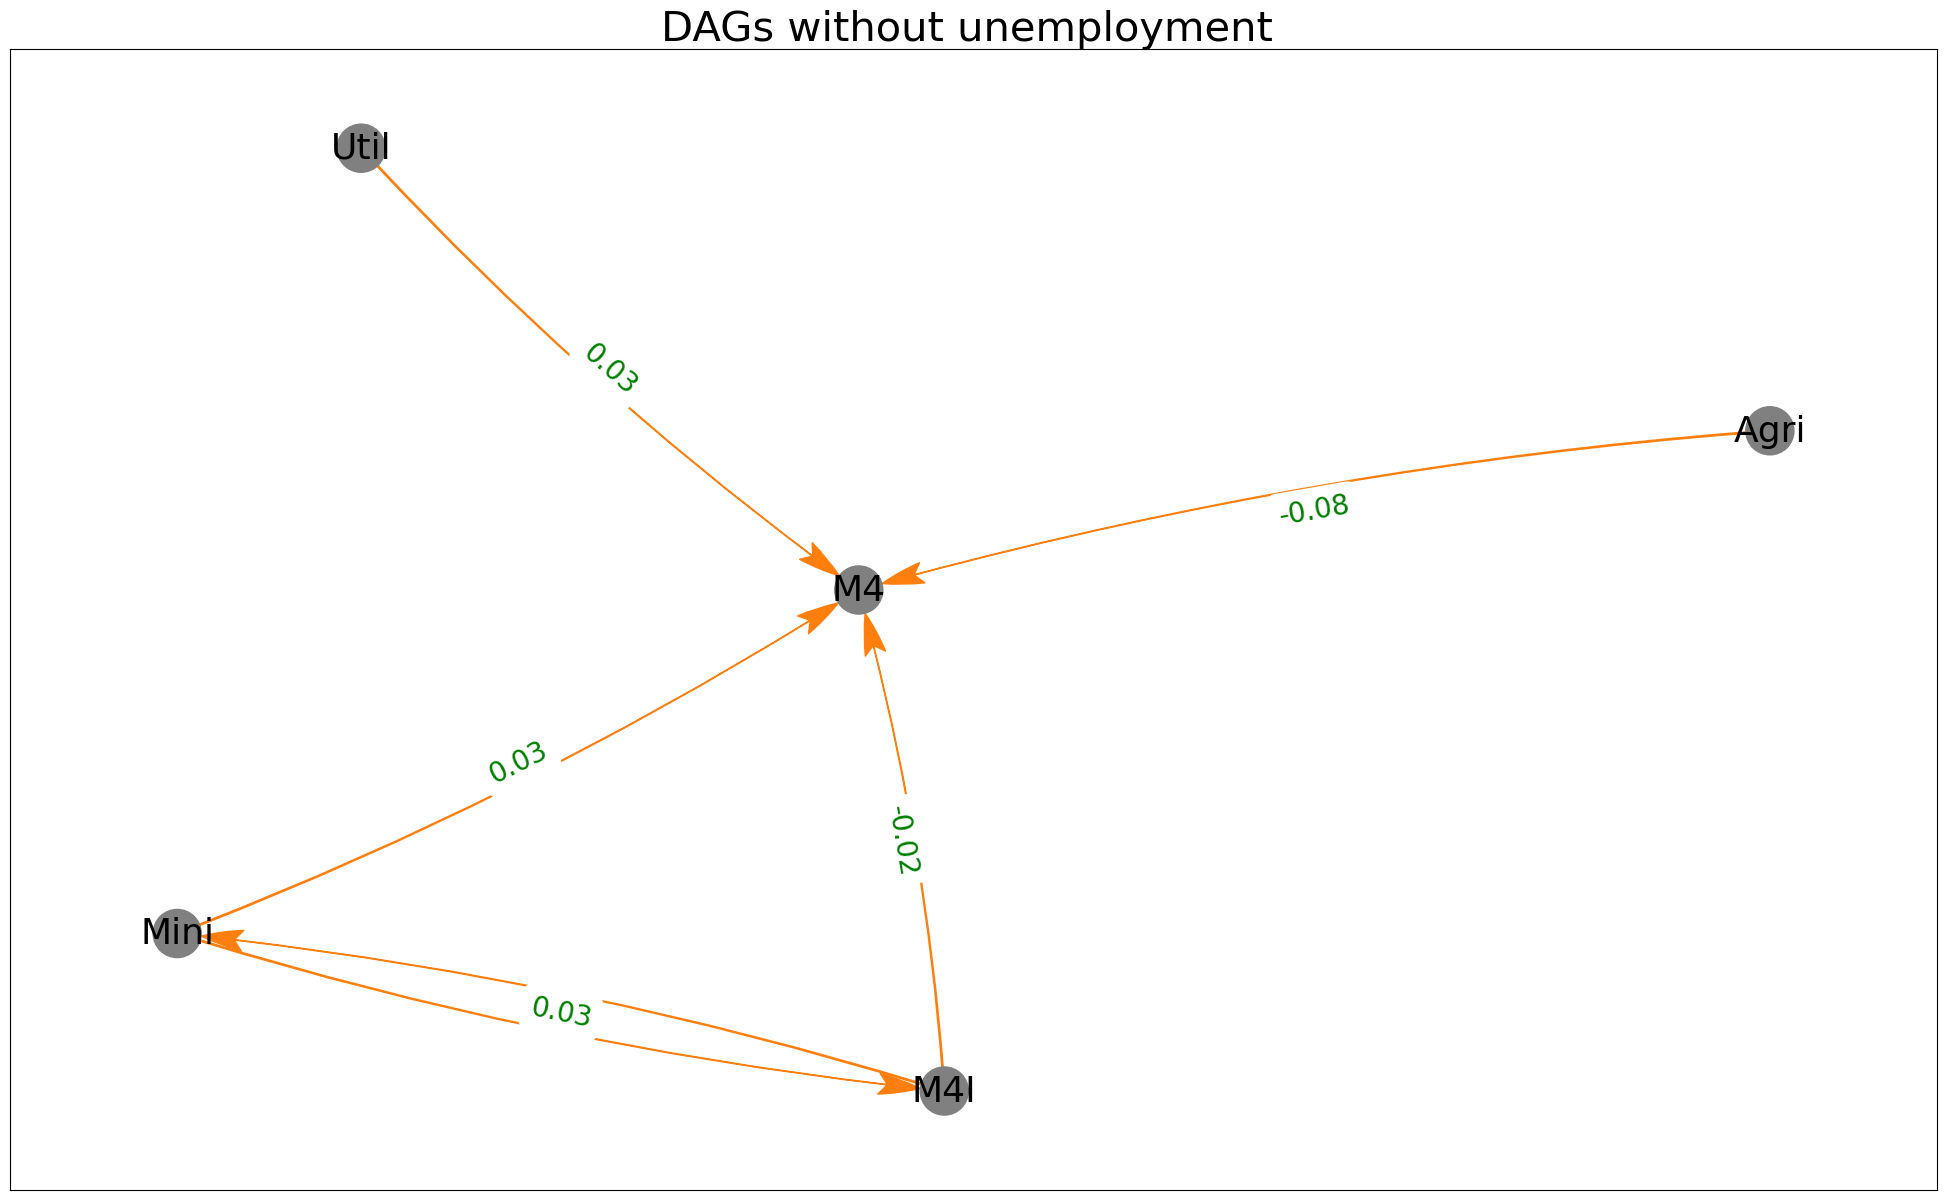

In [21]:
# Initialize a PdfPages object to save the plots in a PDF
pp = PdfPages("DAGs_nominal")

title = ['DAGs including all variables',
        'DAGs without monetary variables',
        'DAGs without unemployment ']

# Plot DAGs for each dataframe
for i, key in enumerate(['including_all_variables', 
                         'without_monetary_variables', 
                         'without_unemployment_variable']):
    plot_df = nominal_differenced_rates[key]
    c = PC(plot_df)
    max_cond_vars = len(plot_df.keys()) - 2
    model = c.estimate(return_type='pdag', variant='orig', significance_level=0.01,
                       max_cond_vars=max_cond_vars, ci_test='pearsonr')
    edges = model.edges

    # Plot the DAG
    graph_DAG(edges, plot_df, title=title[i])
    
    # Save the plot to the PDF
    pp.savefig()

# Close the PdfPages object
pp.close()


The above DAGs results indicate that the presence of the M4 variables act as an intermediary between the effectes of the production components (as can be seen in the first DAG), where M4 acts as an intermediary between the effects of utilities and agriculture. It also indicates the effect of unemployment rates acting as an intermediary as well between components, in this case, it acts as an intermediary between other components and mining.

However, when the M4 variables are excluded from the model, unemployment acts as the sole intermediary between the effects of components (the second DAG). Finally, when unmployment rates are not included in the model, but M4 included, the M4 variables act as the sole intermediary between components and their effects.

This indicates that there is about 100% consistency of the effect of the presence of M4 and Interest rates in the model. i.e, when M4 variables are included in a model, it is expected that they should act as an intermediary between effects of other sectors (or components). The same can also be said about the unemployment rates (but in the absensce of M4).

## Next we cluster the counties and create DAGs

Now we create a dictionary for the full dataframes that include clusters. We also create combinations of dataframes by excluding some variables in the dataframes, specifically excluding monetary variables and unemployment.

In [22]:
full_df_cluster_with_all_variables = full_df_cluster.dropna()

# Create a dictionary to store the DataFrames
full_df_with_cluster = {}

full_df_with_cluster['including_all_variables'] = full_df_cluster_with_all_variables

full_df_with_cluster['without_monetary_variables'] = full_df_cluster_with_all_variables.drop(columns=['M4', 'M4I'])

full_df_with_cluster['without_unemployment_variable'] = full_df_cluster_with_all_variables.drop(columns=['unem'])

In [23]:
# List of dataframes
dataframes = list(full_df_with_cluster.values())

# List of p-values for each dataframe
p_values_list = [0.1, 0.05, 0.01, 0.001]

# Define names for the output files based on dataframes
output_names = [f'clusters_b{i+1}' for i in range(len(dataframes))]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

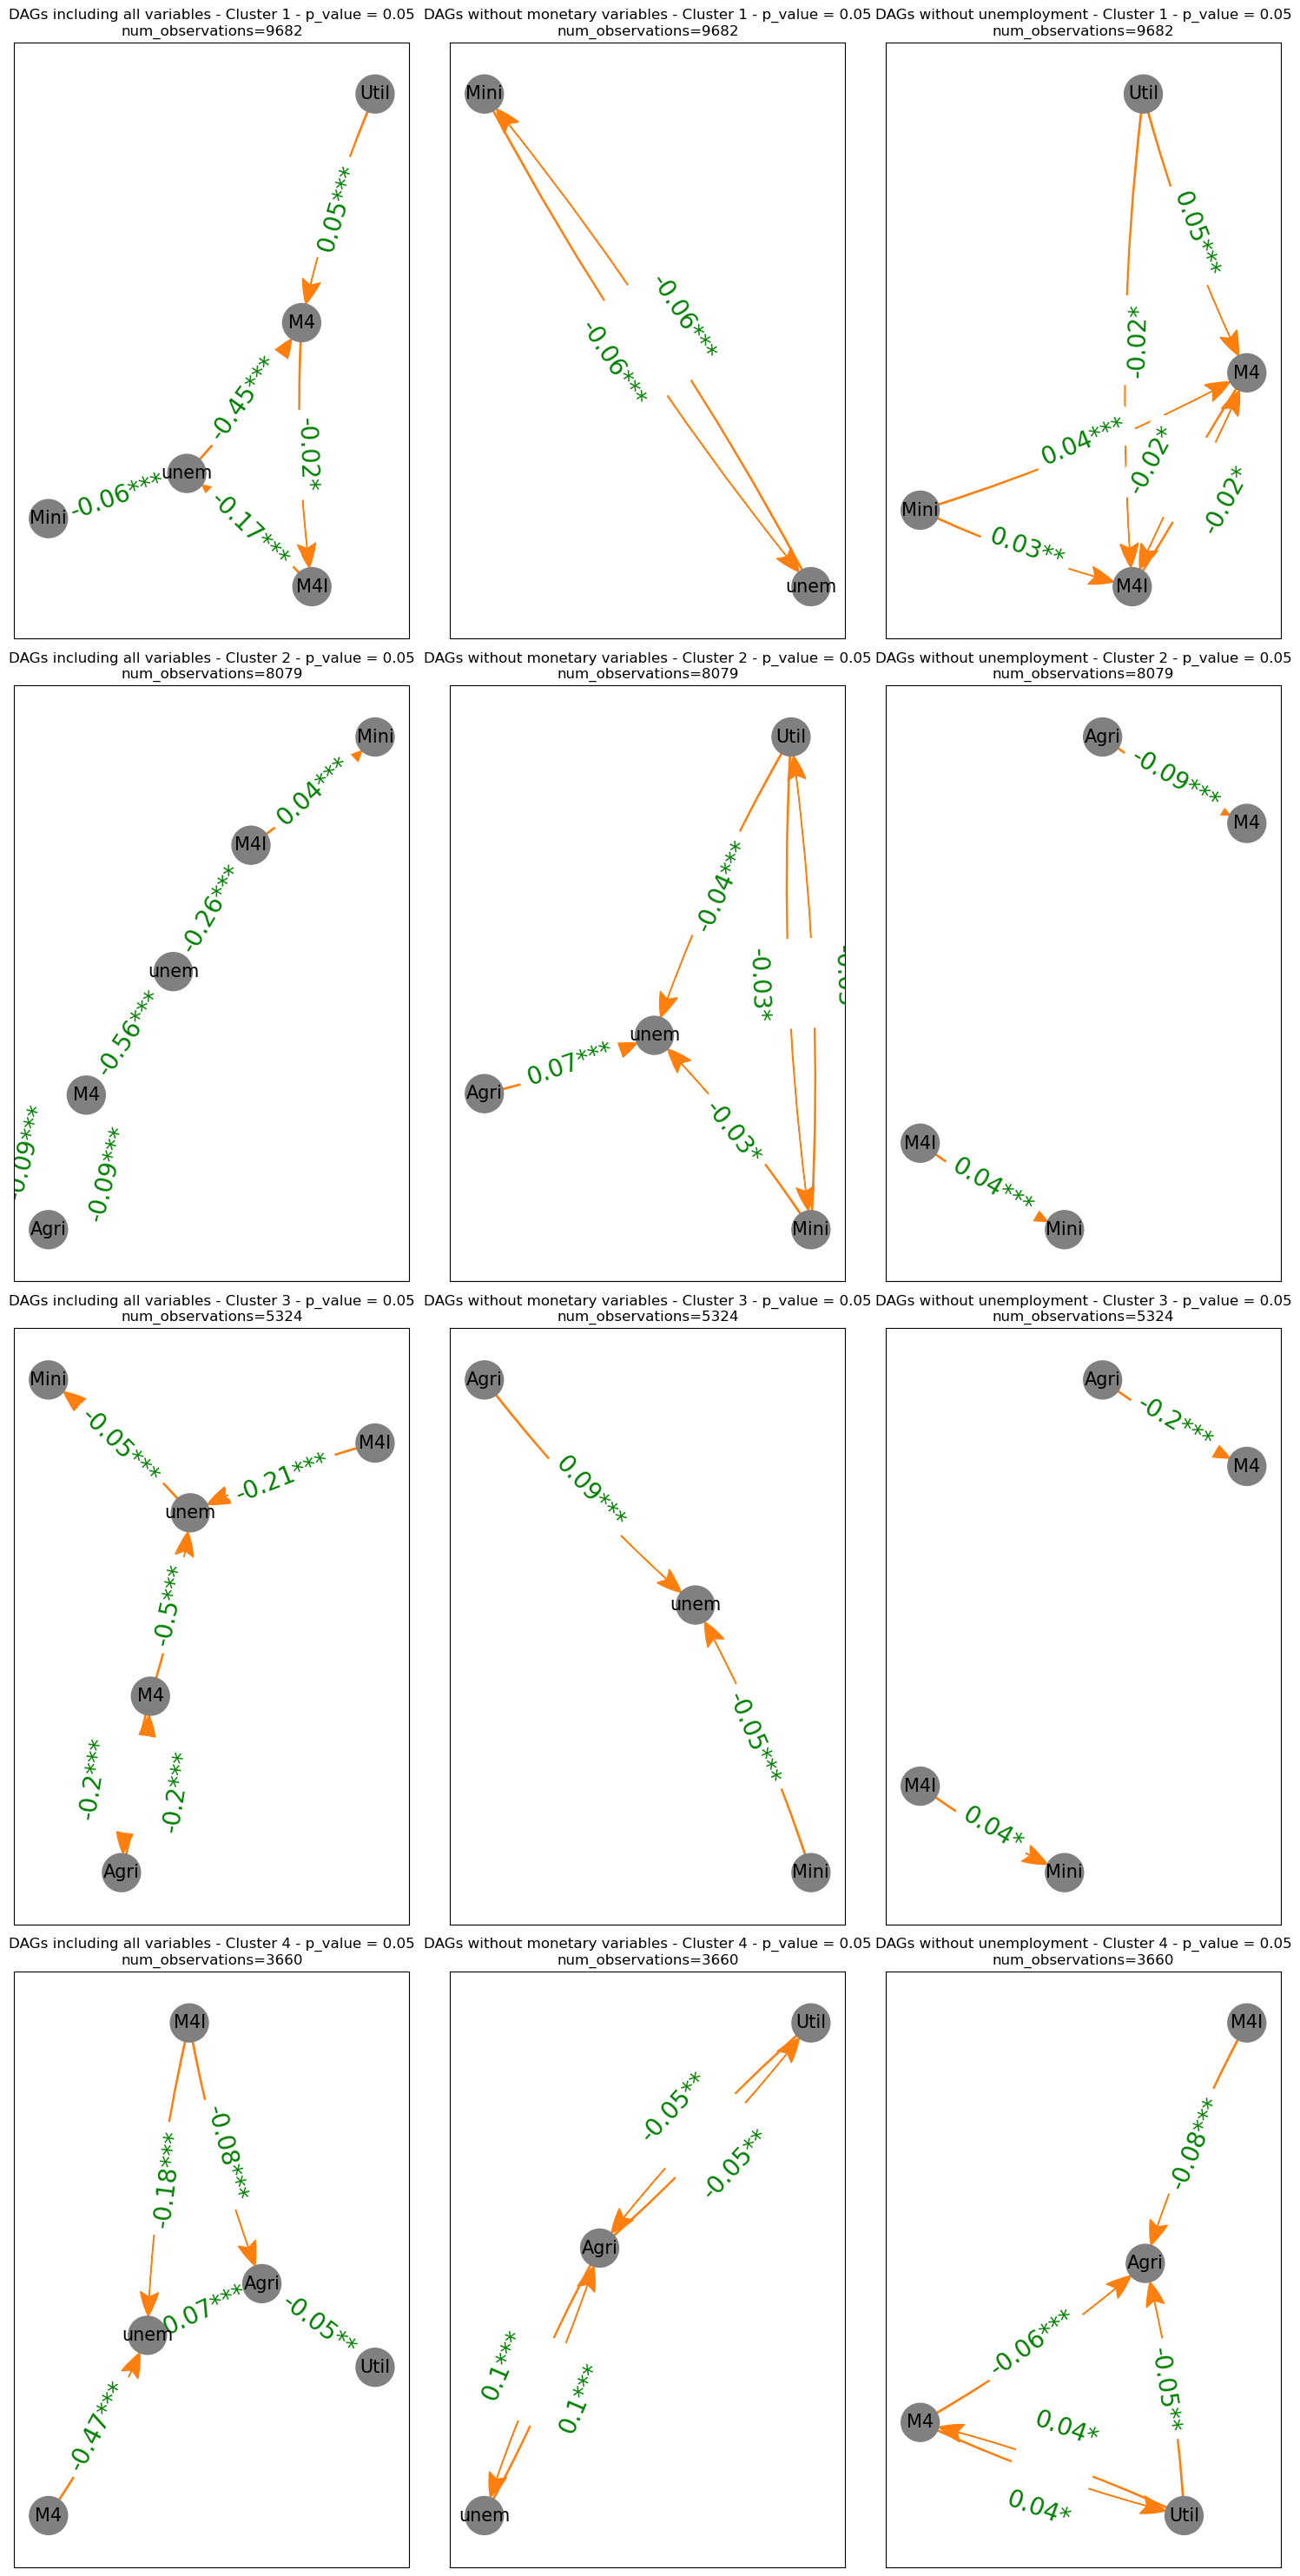

In [24]:
# Specify the absolute path for the output PDF file
pdf_file_path = f"DAGOutputs_{len(dataframes)}_dataframes.pdf"
pp = PdfPages(pdf_file_path)

# Grid for the subplots
fig, axes = plt.subplots(4, len(dataframes), figsize=(5*len(dataframes), 30))

# Different PC algorithms to test
algorithms = ["orig"]

dataframe_names = {
    "Dataframe 1": "DAGs including all variables",
    "Dataframe 2": "DAGs without monetary variables",
    "Dataframe 3": "DAGs without unemployment"
}

# Iterate over each dataframe
for idx, dataframe in enumerate(dataframes):
    # Get clustered dataframes for the current dataframe
    clustered_dfs = create_cluster_dags(dataframe)

    # Iterate over clustered dataframes and determine p-values dynamically
    for cluster_idx, cluster_df in enumerate(clustered_dfs):
        n = cluster_df.shape[0]  # Number of observations for the current cluster
        p_value = determine_p_value(n)

        # Iterate over different PC algorithms
        for algorithm in algorithms:
            c = PC(cluster_df)
            model = c.estimate(return_type='pdag', variant=algorithm, significance_level=p_value, ci_test='pearsonr')
            edges = model.edges

            graph_DAG_cluster(edges, cluster_df, title=f'{dataframe_names["Dataframe "+str(idx+1)]} - Cluster {cluster_idx + 1} - p_value = {p_value}\nnum_observations={n}'
                      , algorithm=algorithm, ax=axes[cluster_idx, idx], pp=pp)

# Save the figure to the PDF
pp.savefig(fig, bbox_inches='tight')

pp.close()
plt.show()

The above DAGs represent the results of clustering the counties and then generating DAGs from the clusters. The first column represent the DAGs created using all variables, the second column represent DAGs without M4 variables and the third column represent DAGs without unemployment rates.

We expect that the results should be consistent with the initial DAGs created (i.e, DAGs without clusters). The first column has a very similar set of results to the initial results. Where M4 intermediates the effects of other components. There is not a 100% consistency however.

For the second column (where the M4 variables are not included in the model), there is about 50% consistency of unemployment rates acting as an intermediary between the effects of other variables.

Finaly, the third column which represents DAGs for the model that does not include unemployment rates indicates about 25% consistency amongst the clusters.

The most consistent results according to the DAGs from the clusters compared with the original results appear to be the model where all variables are included.

#### Shared links

Now we create plots to display the common links between clusters and between dataframes. Dataframes is represented in columns while clusters are represented as rows

In [25]:
edges_dct = get_edges_dict(dataframes)
col_shared_edges=get_col_shared_edges(edges_dct)
row_shared_edges=get_row_shared_edges(edges_dct)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

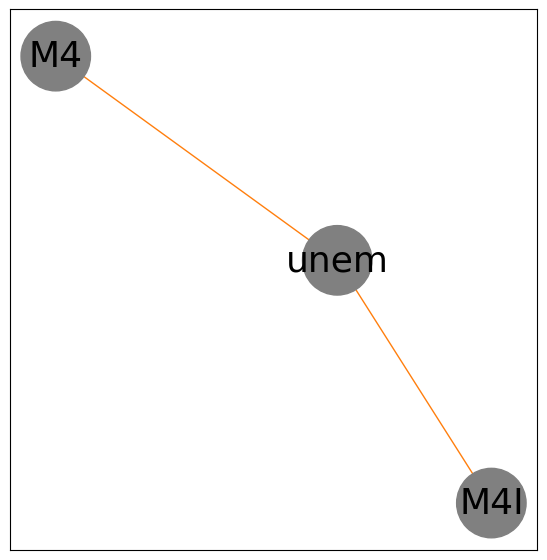

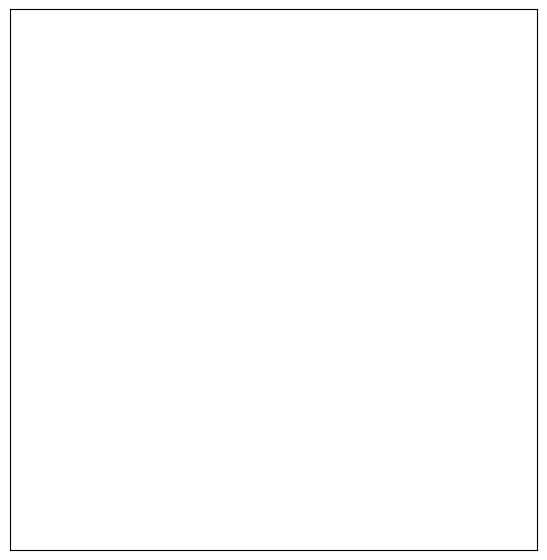

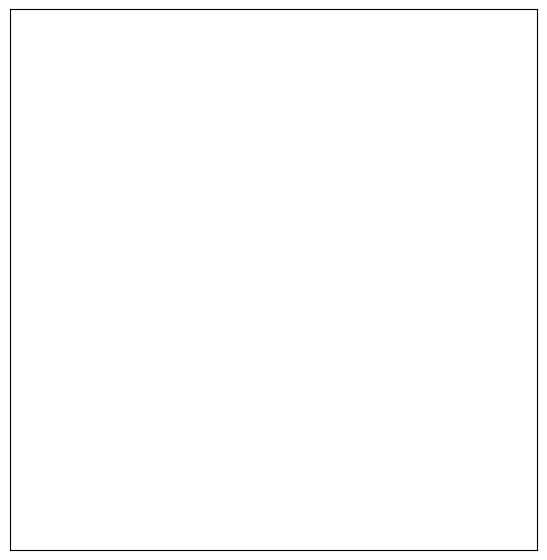

In [26]:
plot_shared_edges(col_shared_edges)

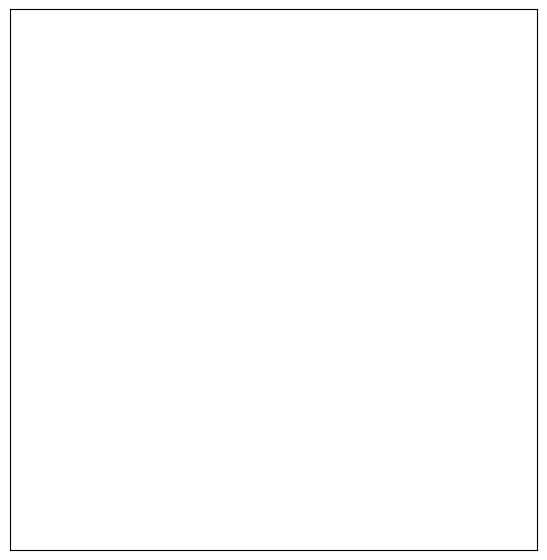

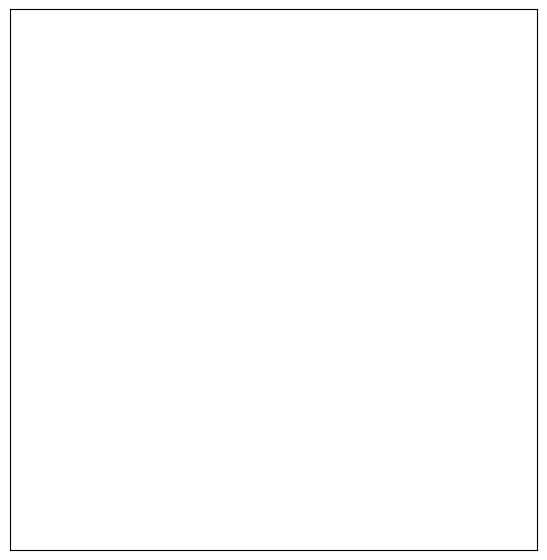

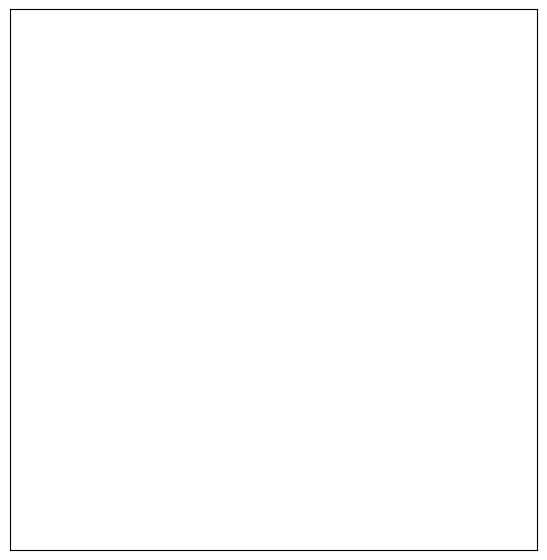

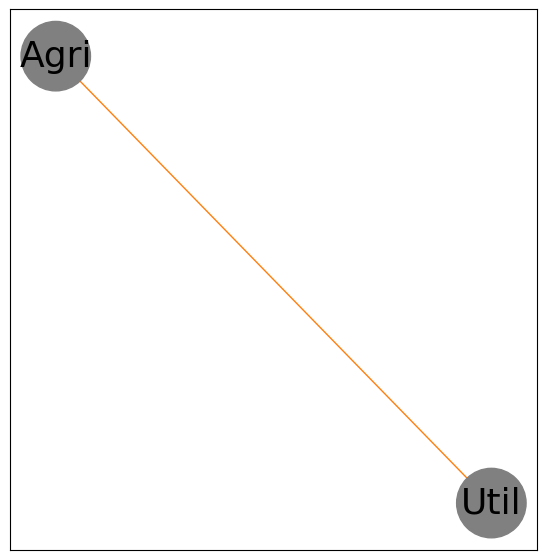

In [27]:
plot_shared_edges(row_shared_edges)

Plotting the correlation heatmap for the variables. The most notable correlation appears to be between the monetary variables and unemployment rates. There is negative relationship between the monetary variables and unemplyment rates.

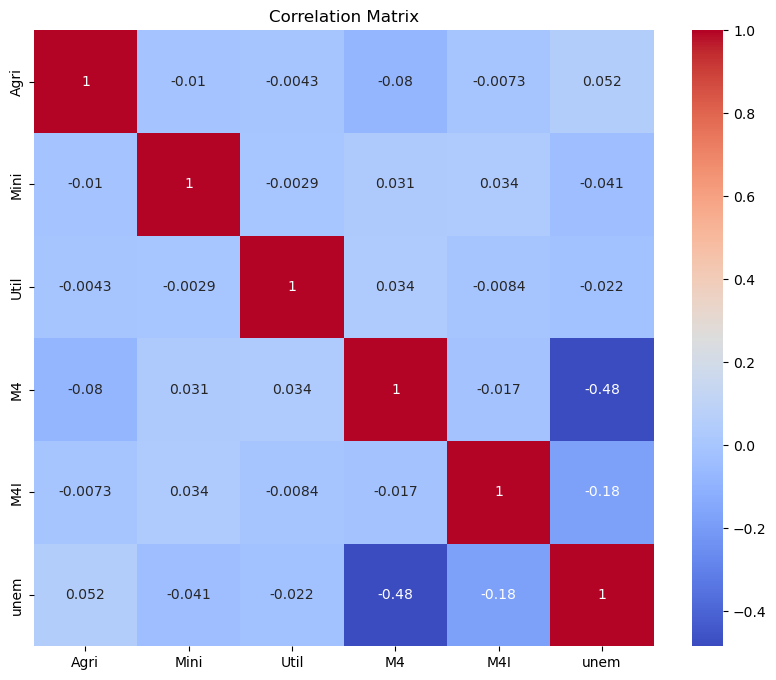

In [28]:
# Correlation matrix
correlation_matrix = full_df_cluster[['Agri', 'Mini', 'Util', 'M4', 'M4I', 'unem']].corr()
#print(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


Now the following codes are to display the mean of each variables by clusters in a bar graph

In [29]:
# Mean of variables by clusters
mean_values_by_clusters = full_df_cluster.groupby('clusters').mean().reset_index()

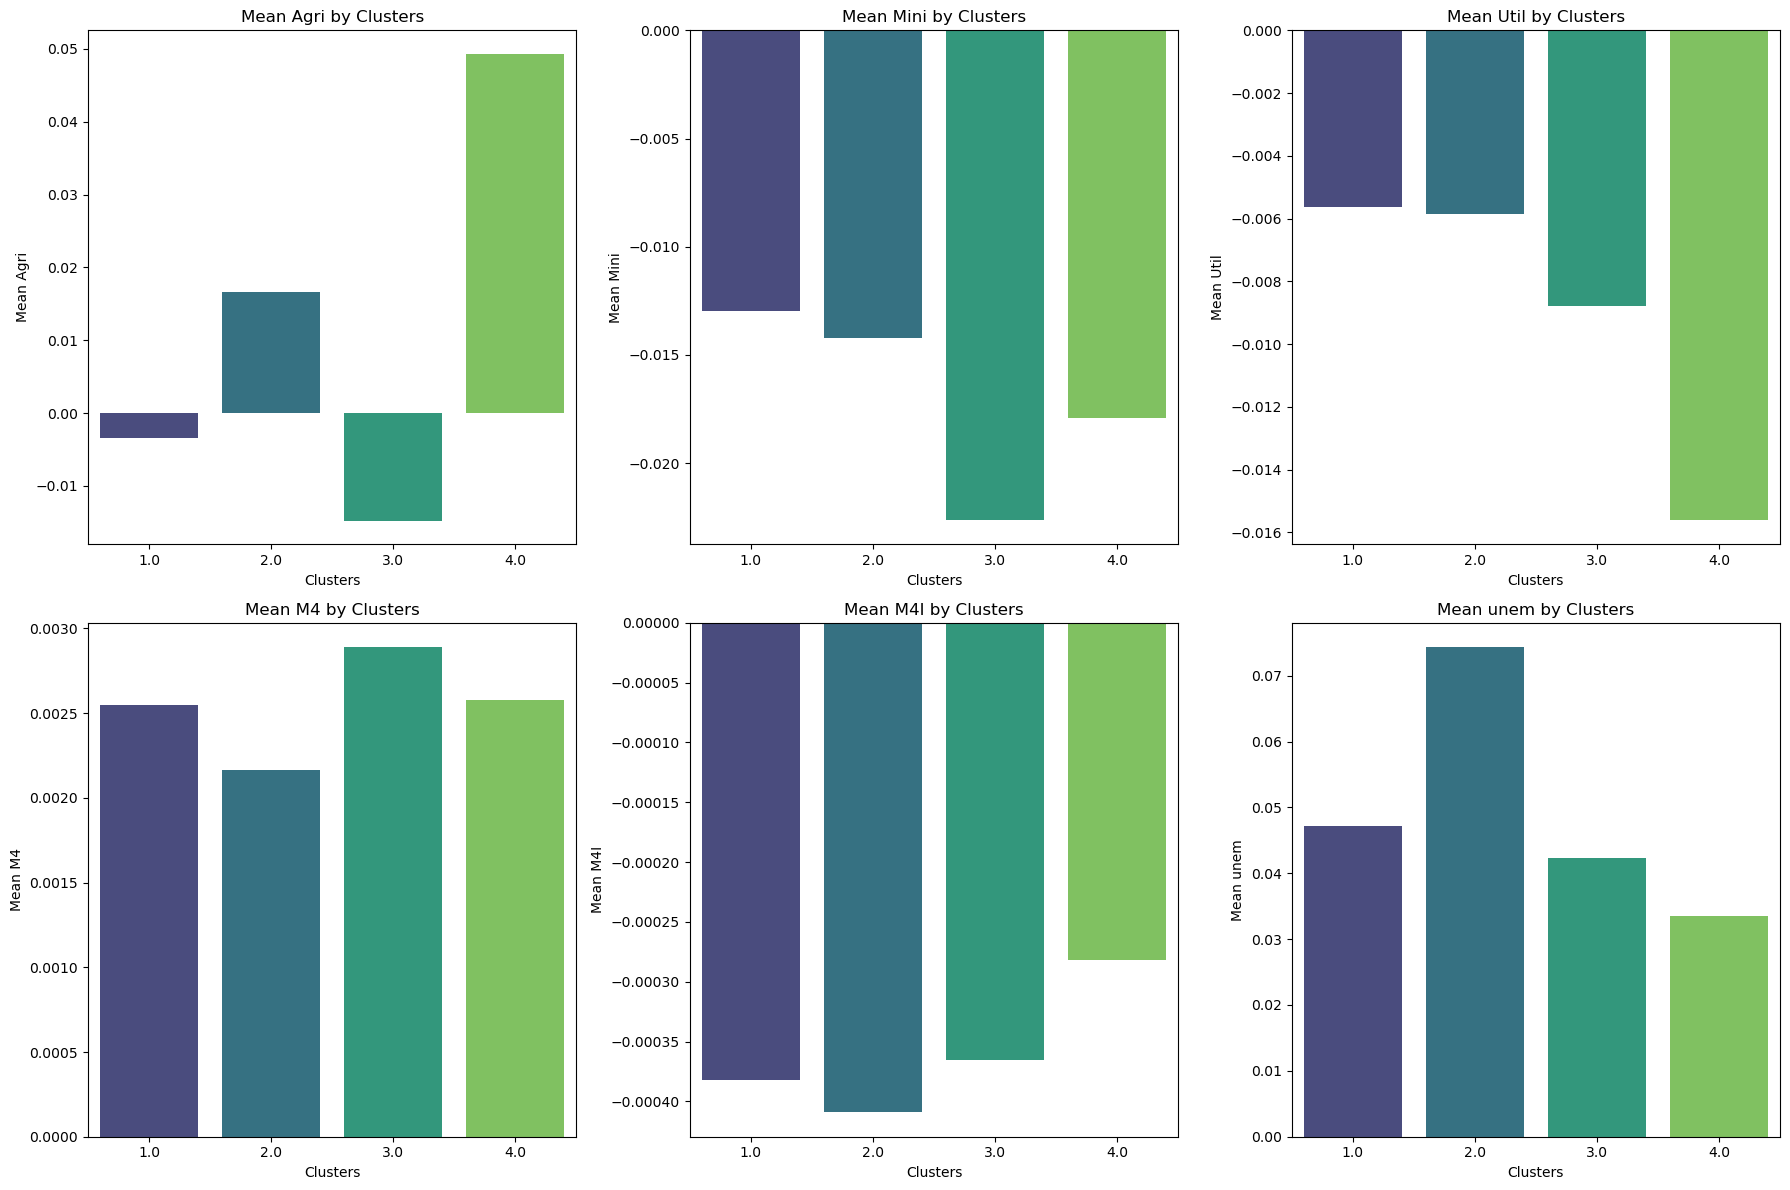

In [30]:
# List of variables to plot
variables = ['Agri', 'Mini', 'Util', 'M4', 'M4I', 'unem']

# Set up the plot grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))
axes = axes.flatten()

# Plot each variable
for i, var in enumerate(variables):
    sns.barplot(x='clusters', y=var, data=mean_values_by_clusters, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Mean {var} by Clusters')
    axes[i].set_xlabel('Clusters')
    axes[i].set_ylabel(f'Mean {var}')

# Adjust layout
plt.tight_layout()
plt.show()

Looking at the bar graphs above, the variable that has nearly similar mean by clusters appear to be the monetary variables and the unemployment rates

### Panel Regressions

The dataframe that would be used for the panel regressions is the full dataframe which includes clusters. It is named df

In [31]:
df = full_df_cluster.reset_index()

df['index'] = range(1, len(df) + 1)

In [32]:
df = df.set_index(['FIPS', 'index'])

In [33]:
df.to_csv('full_df_clusters.csv', index=True)

Now we create new columns in the dataframe 'df' to represent dummies for clusters, with cluster 1 being omitted to avoid mulitcolinearity

In [34]:
# Convert 'clusters' column to dummy variables, dropping the first category
df = pd.get_dummies(df, columns=['clusters'], drop_first=True)

# List all the dummy variables created
cluster_dummies = [col for col in df.columns if col.startswith('clusters_')]

Now we start the regressions by using the stepwise selection methods. First we use the forward selection method.

#### Forward Selection Method

We create three model formulas for this method. The first model will include clusters as dummies in the regressions, the second model will include a time effect and the final model will include both entity and time effects. The dependent variable for the models will be unemployment rates. For each model, the best will be chosen based on the smallest AIC. The results of each model will be saved in a dictionary named 'formula_model_dict' 

In [35]:
pd.set_option('display.max_colwidth', None)
# results_df

After selecting the best model based on the lowest AIC, we now output each of the model summaries and plot relevant plots.


Best model with clusters included:
                          PanelOLS Estimation Summary                           
Dep. Variable:                   unem   R-squared:                        0.2727
Estimator:                   PanelOLS   R-squared (Between):              0.3397
No. Observations:               26823   R-squared (Within):               0.2722
Date:                Wed, May 29 2024   R-squared (Overall):              0.2727
Time:                        13:31:54   Log-likelihood                -4.313e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1257.0
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                 F(8,26815)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):            

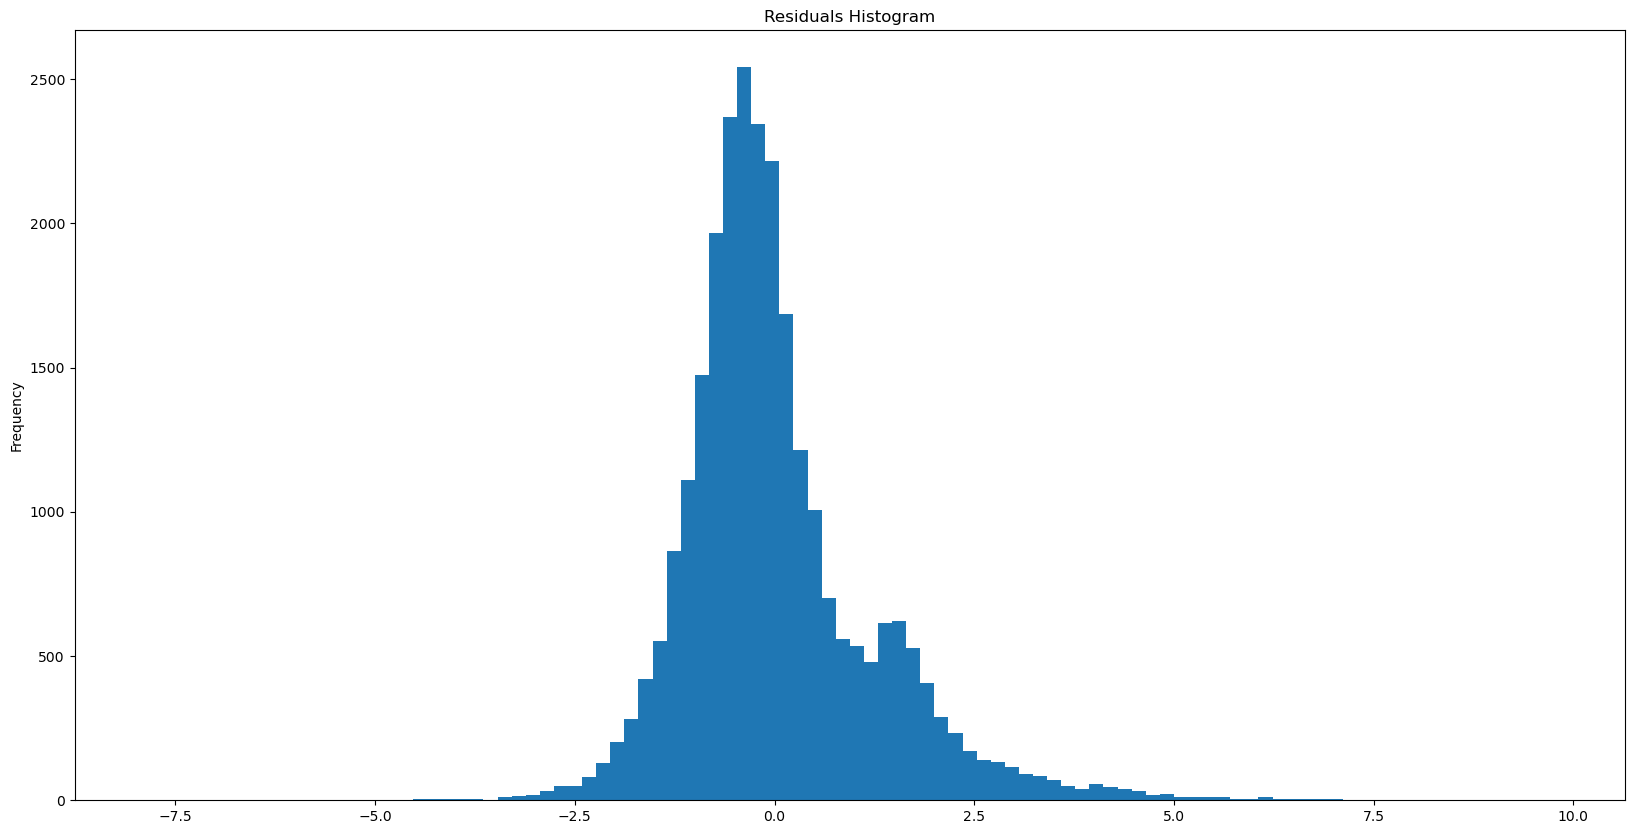

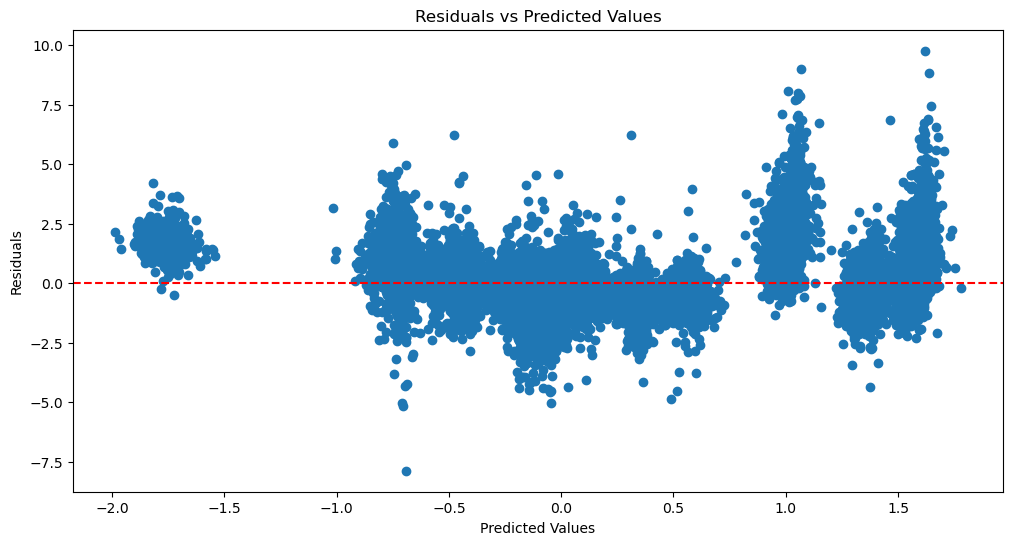

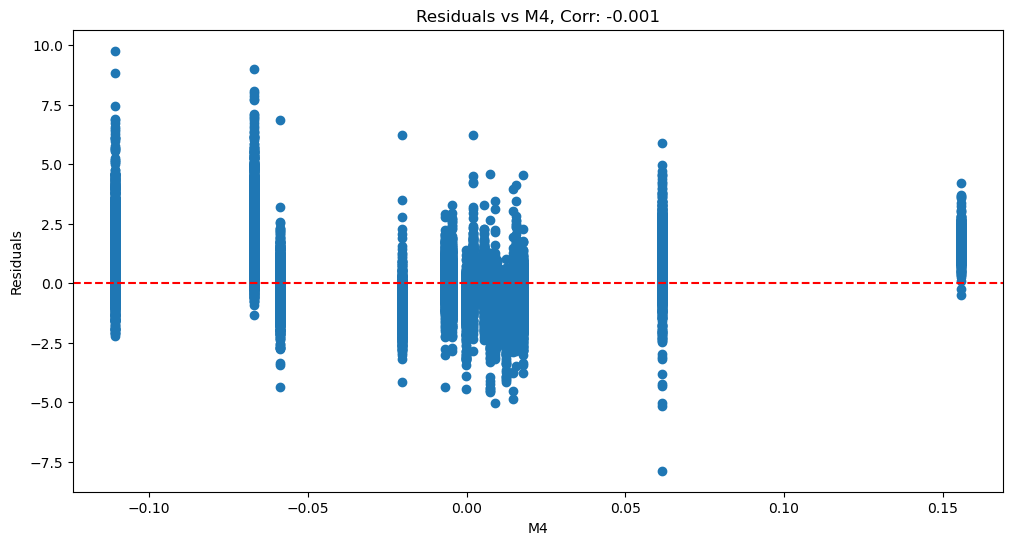

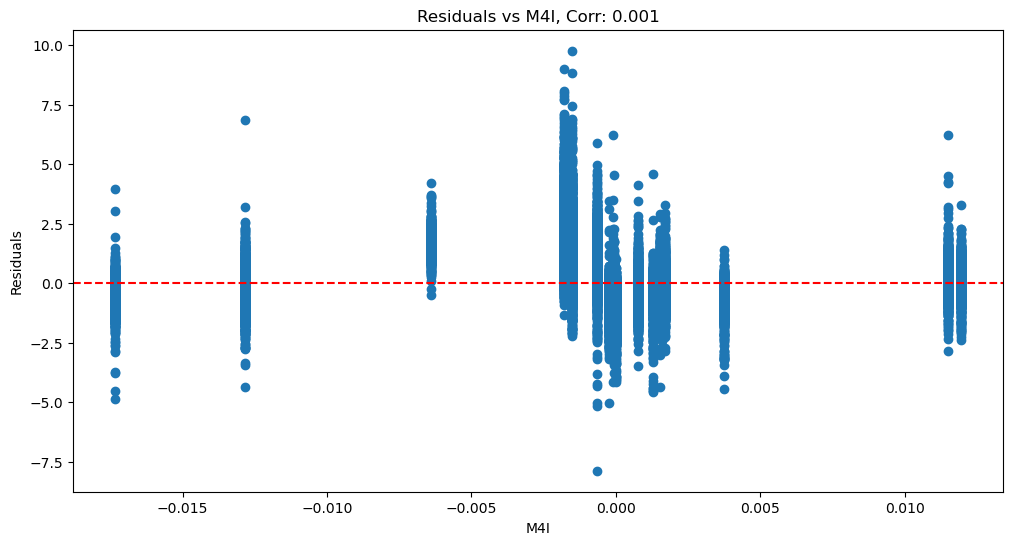

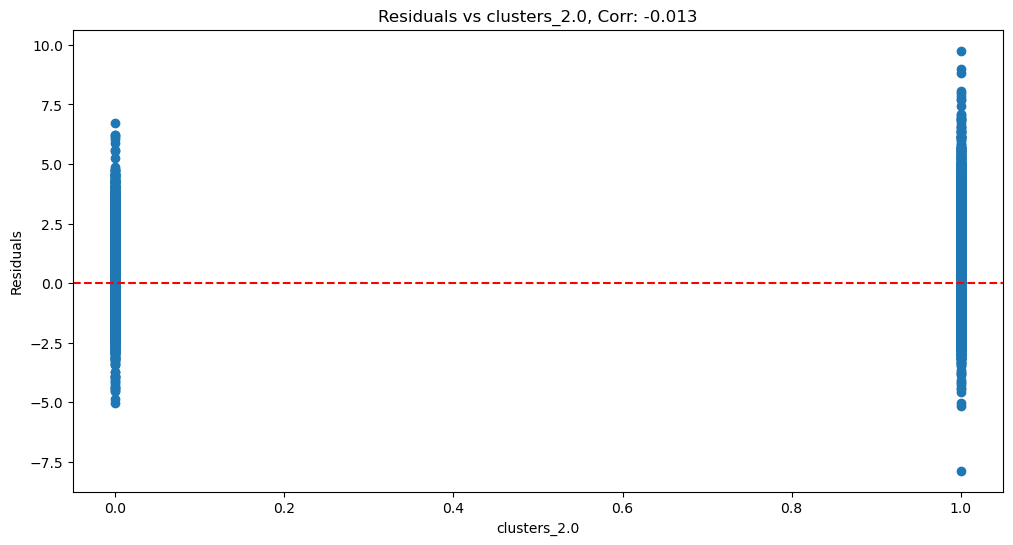

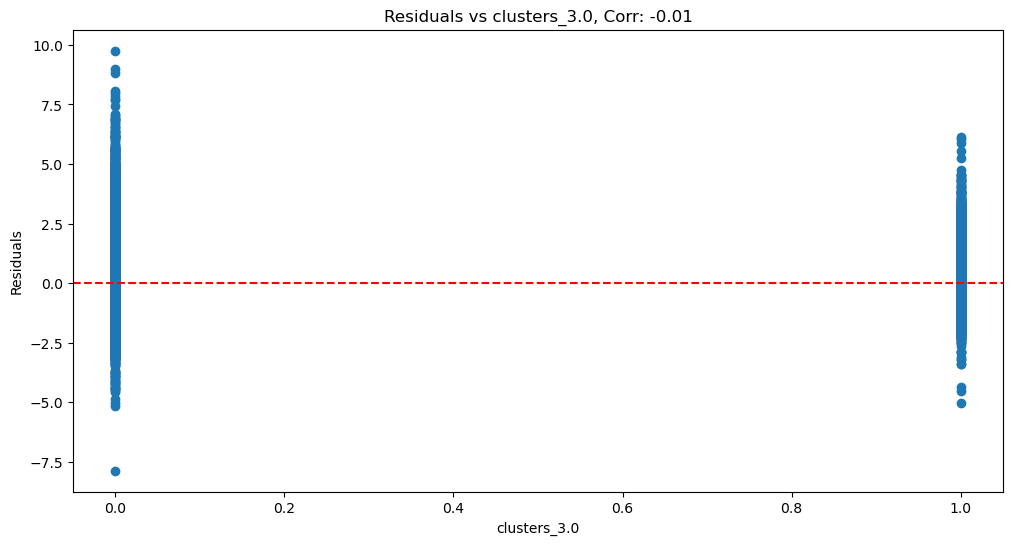

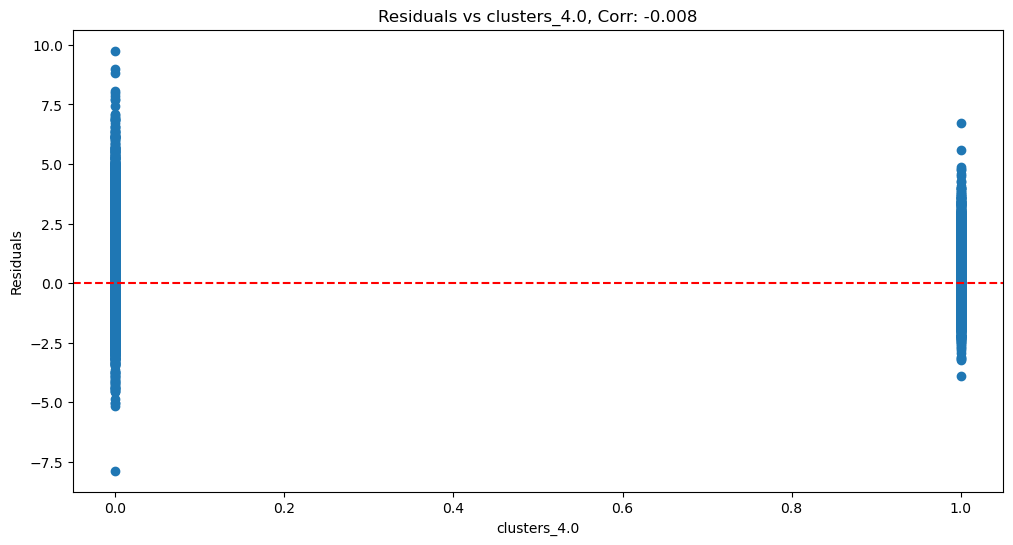

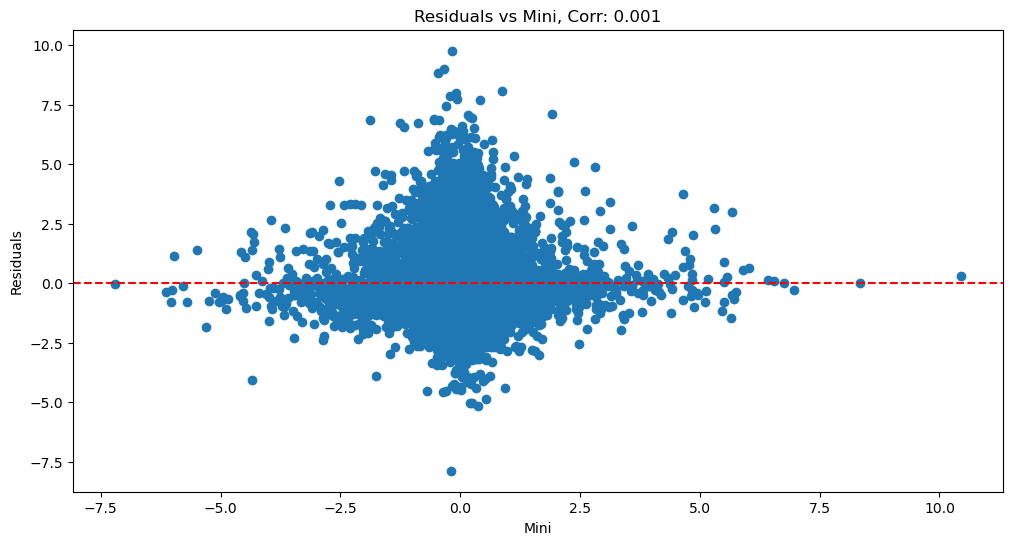

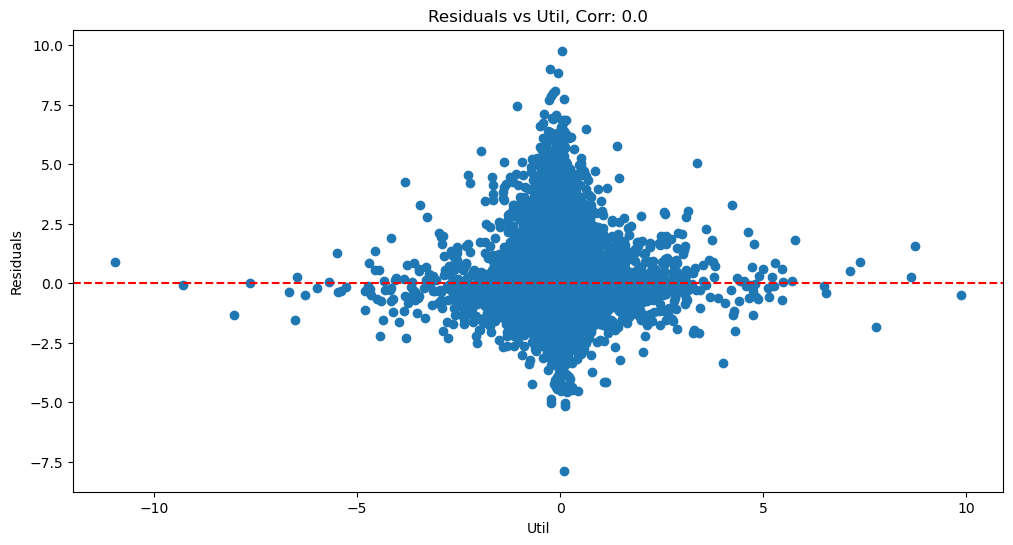

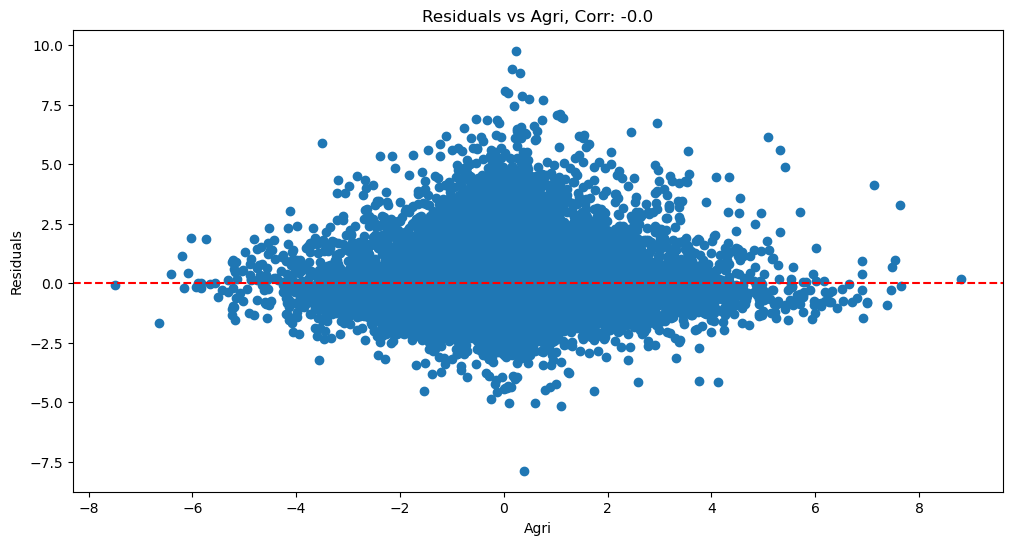

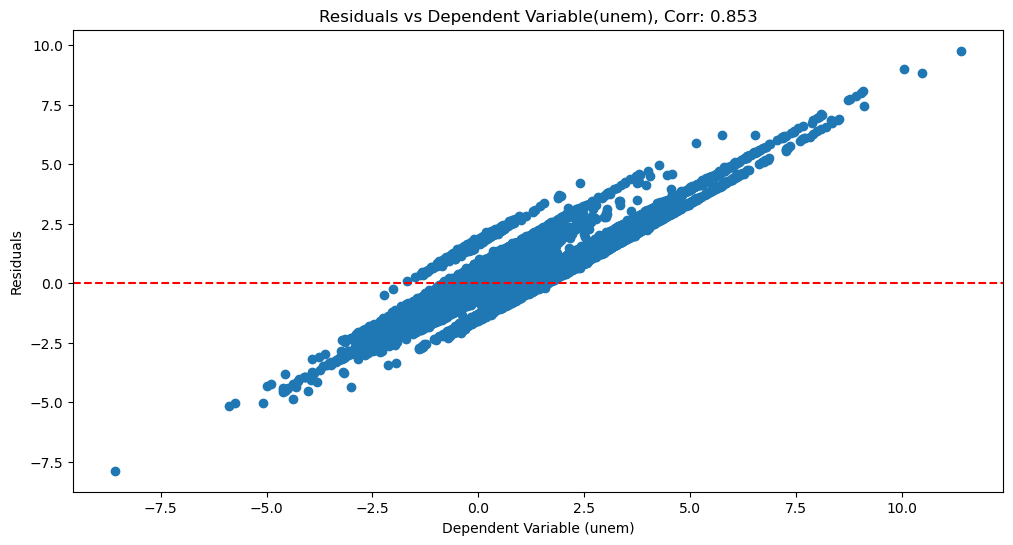


Best model with entity effects only:
                          PanelOLS Estimation Summary                           
Dep. Variable:                   unem   R-squared:                        0.2722
Estimator:                   PanelOLS   R-squared (Between):              0.3228
No. Observations:               26823   R-squared (Within):               0.2722
Date:                Wed, May 29 2024   R-squared (Overall):              0.2709
Time:                        13:31:56   Log-likelihood                -4.254e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2285.3
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                 F(4,24442)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):          

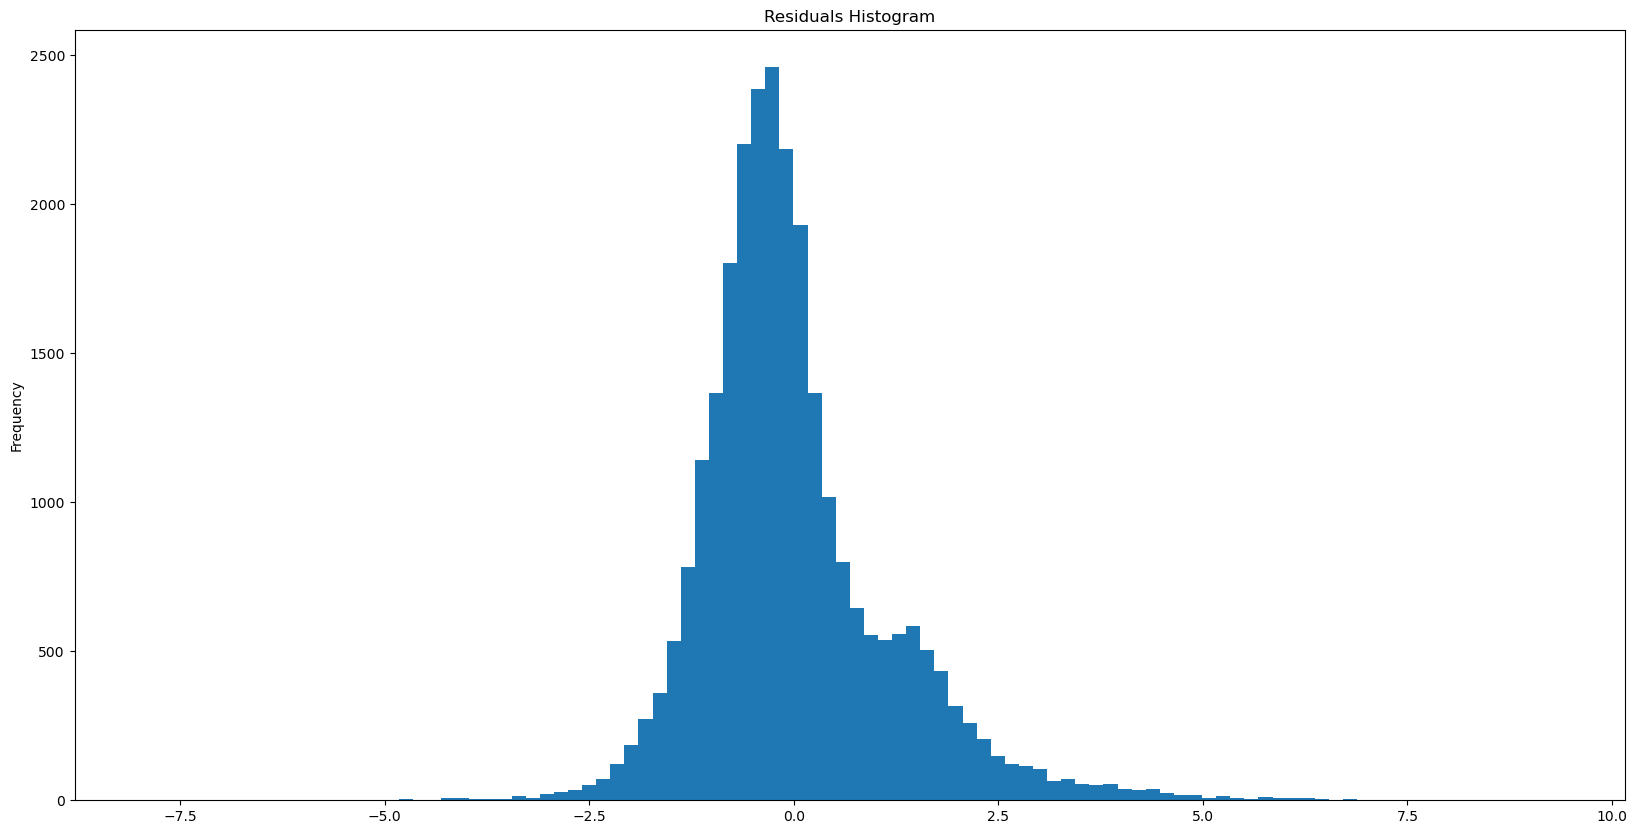

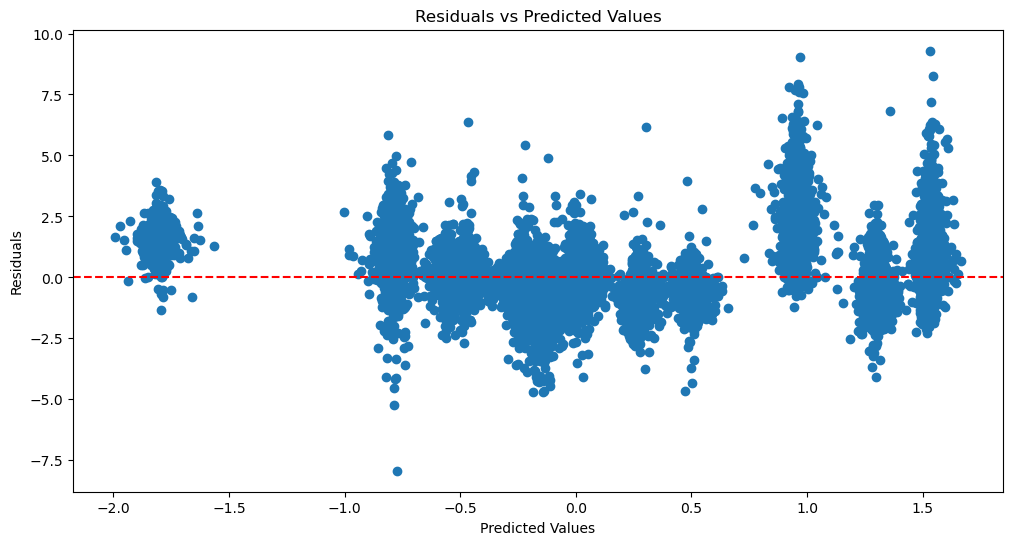

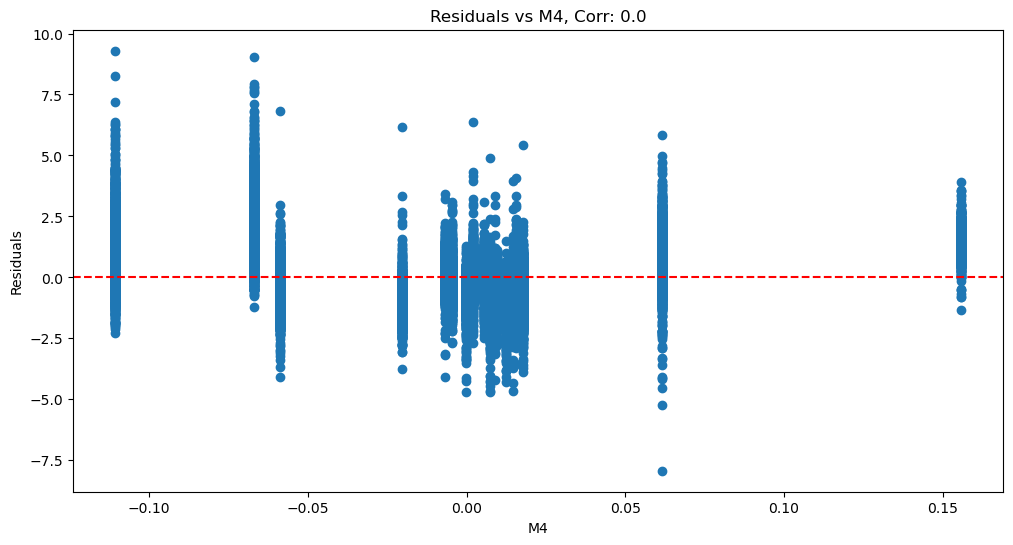

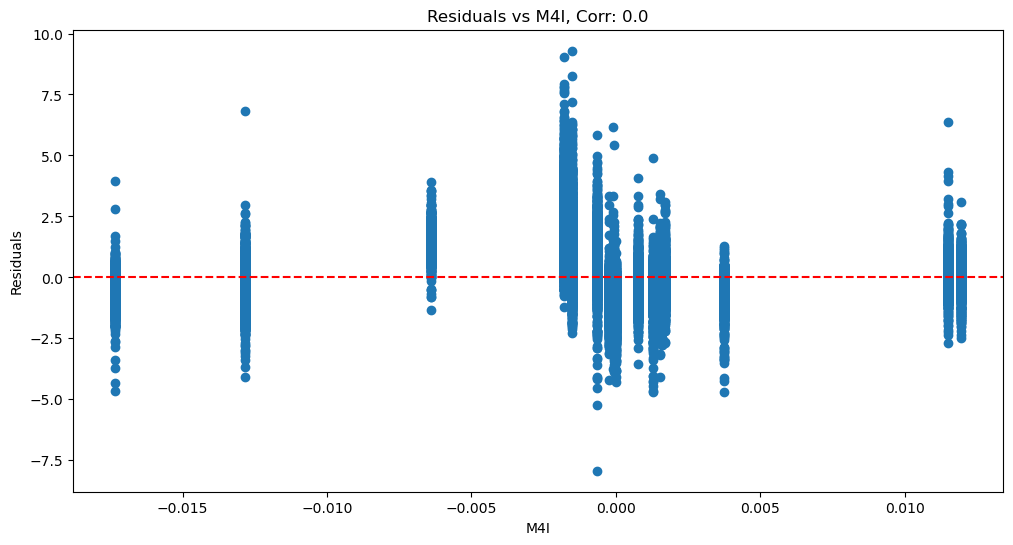

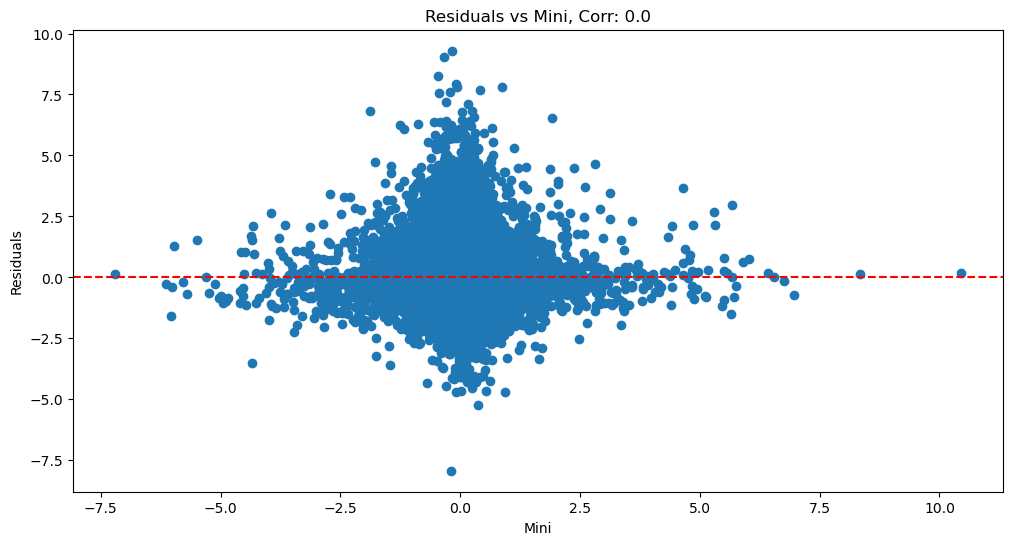

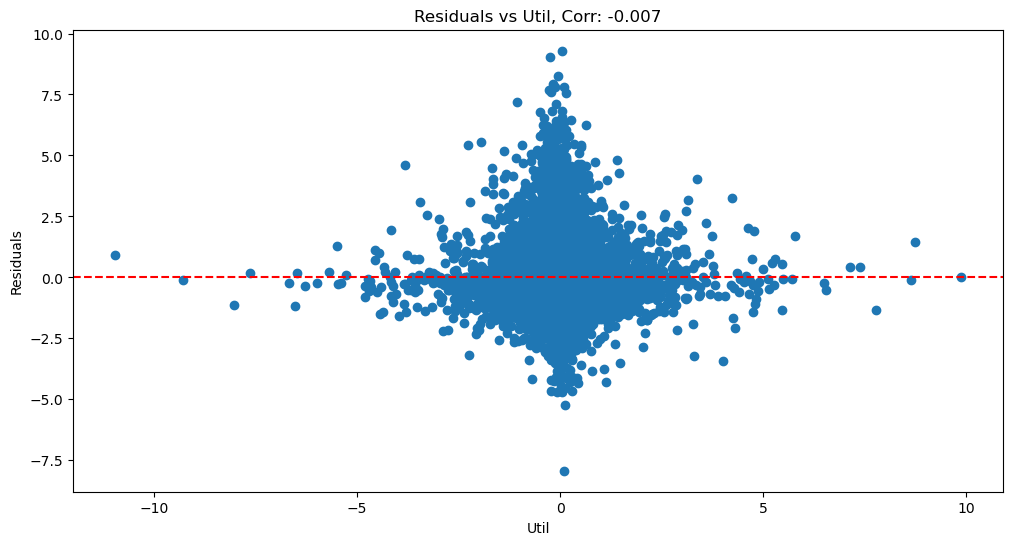

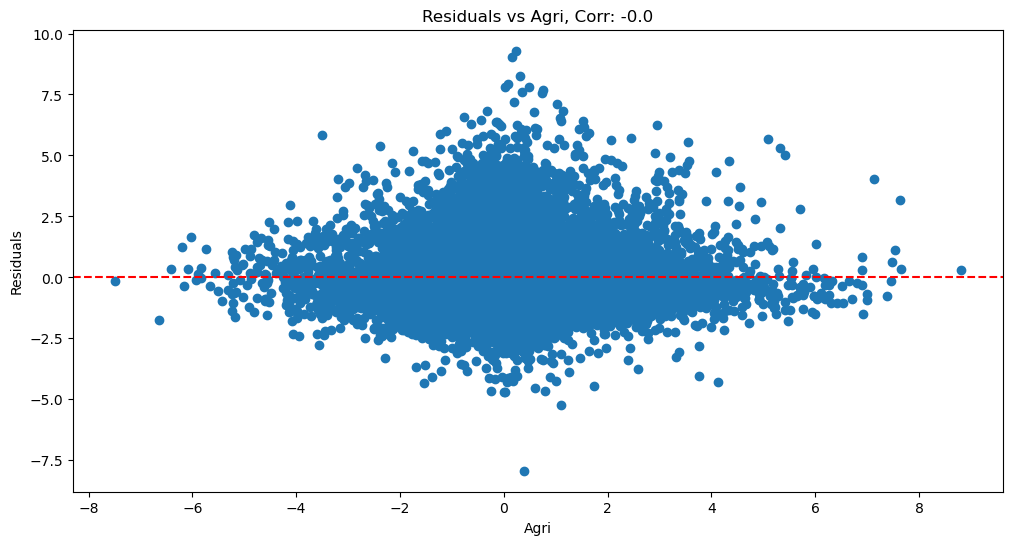

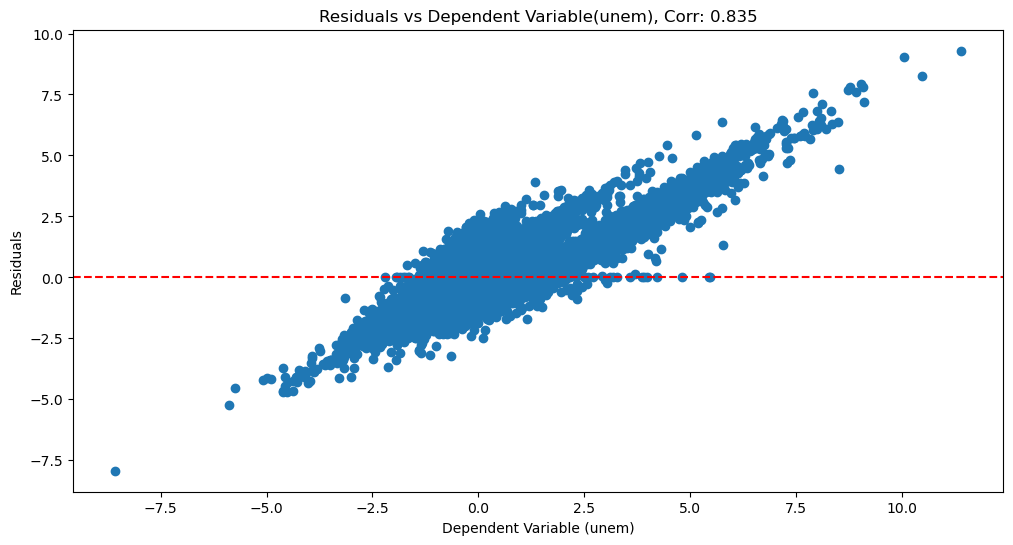


Best model with time effects only:
                          PanelOLS Estimation Summary                           
Dep. Variable:                   unem   R-squared:                        0.6762
Estimator:                   PanelOLS   R-squared (Between):              0.6775
No. Observations:               26823   R-squared (Within):               0.6779
Date:                Wed, May 29 2024   R-squared (Overall):              0.6762
Time:                        13:31:57   Log-likelihood                -3.228e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2665.1
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                F(21,26802)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):            

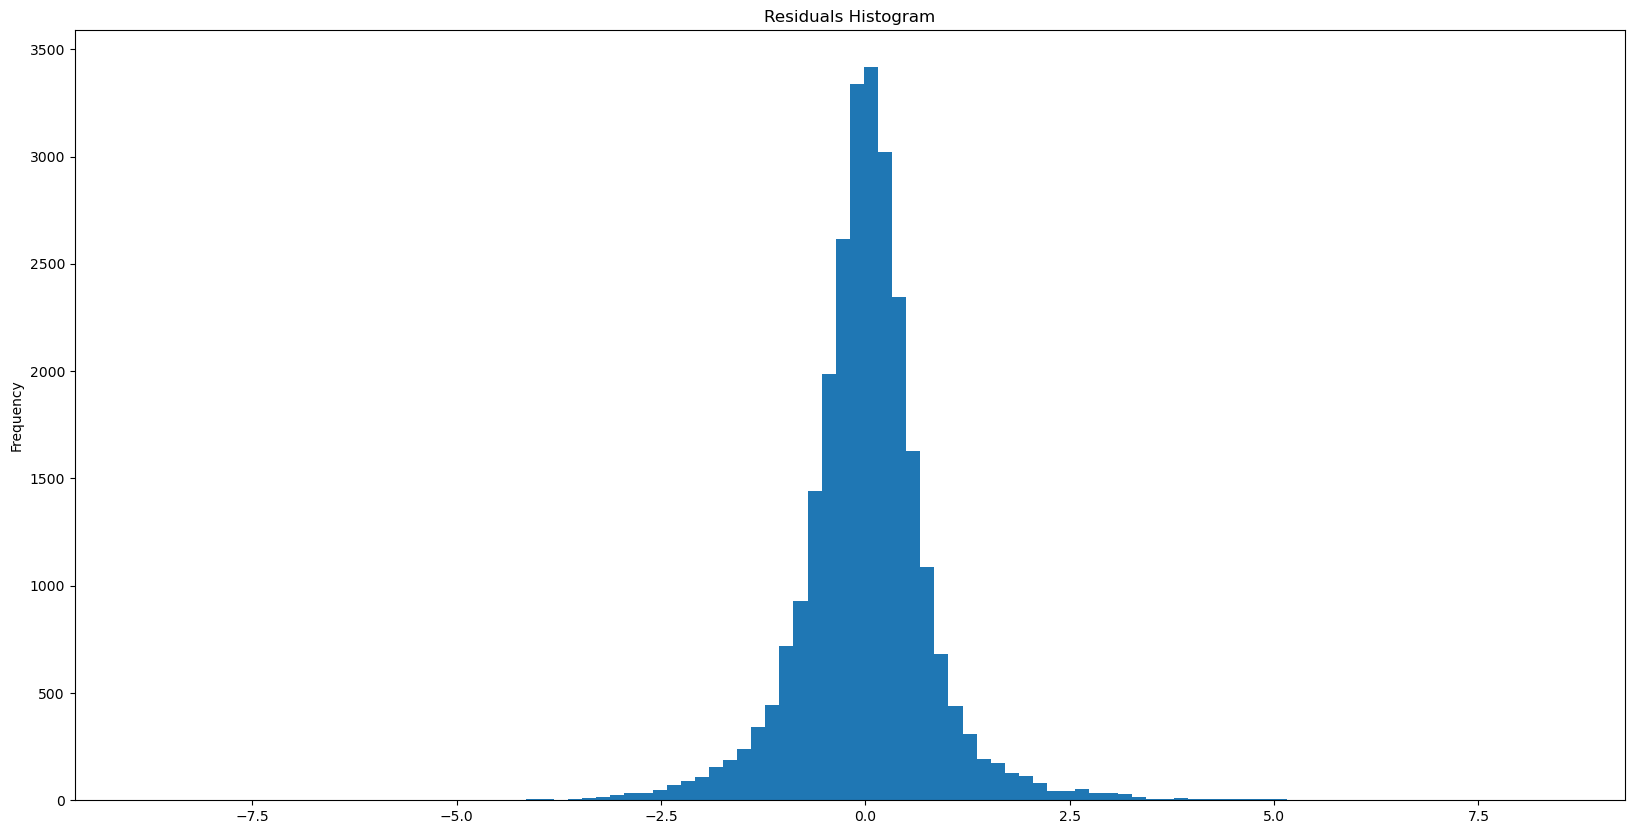

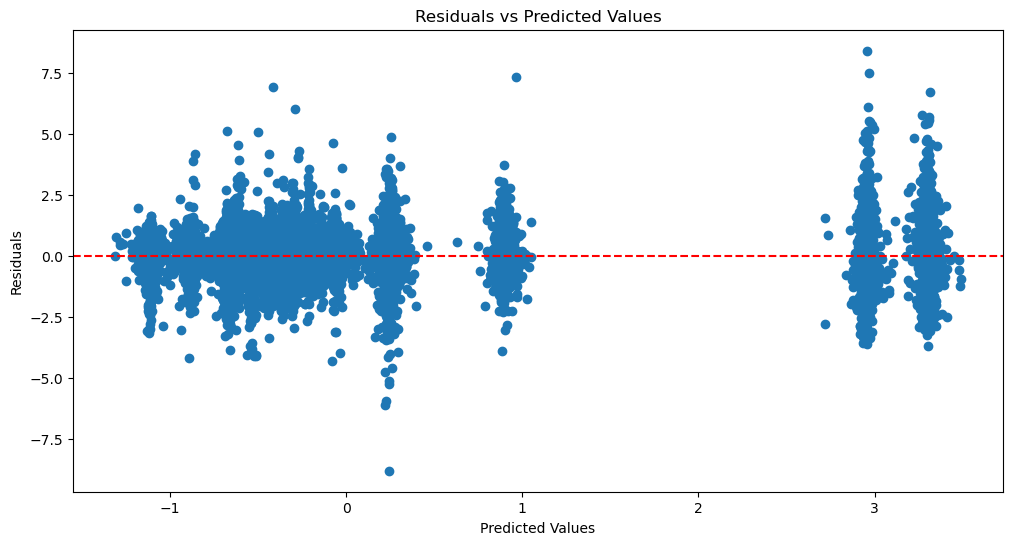

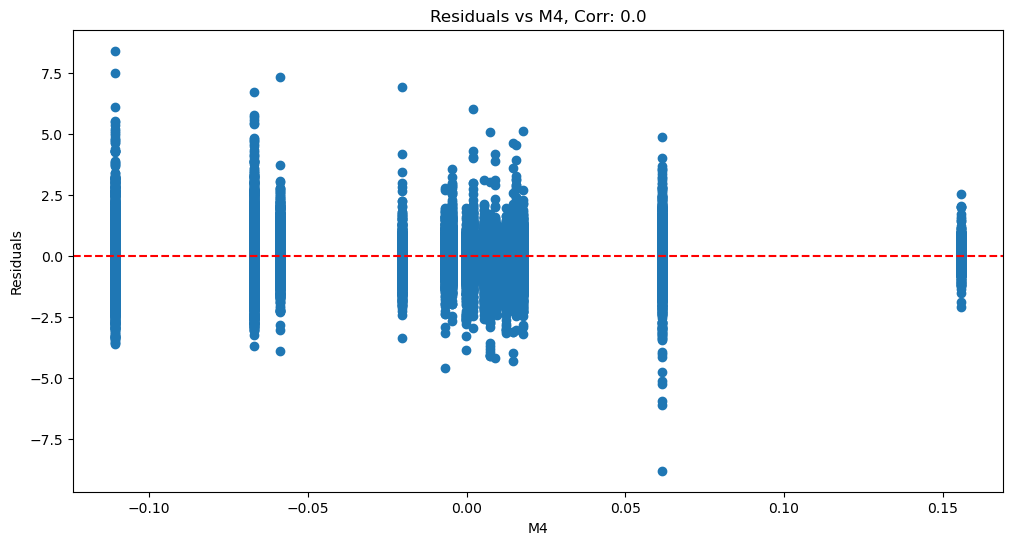

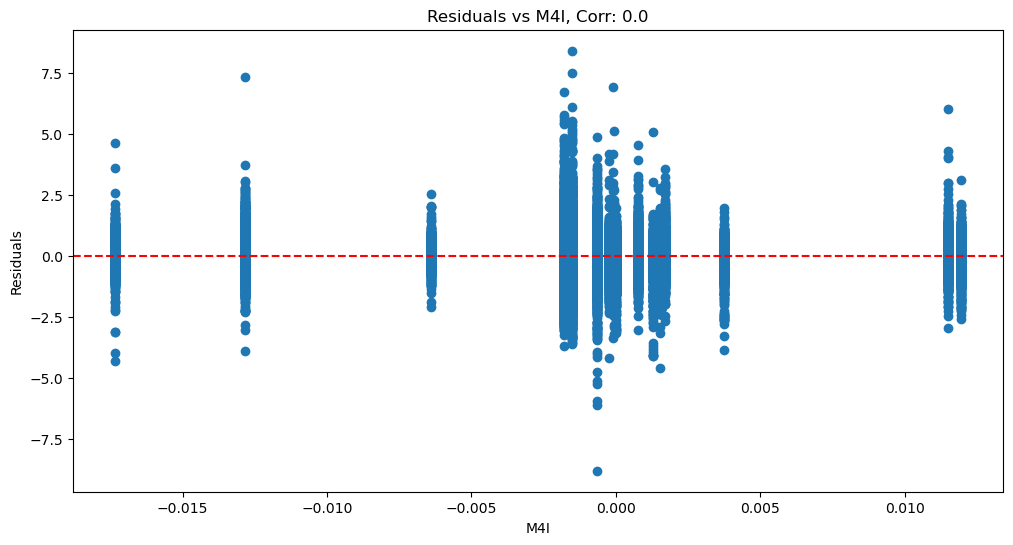

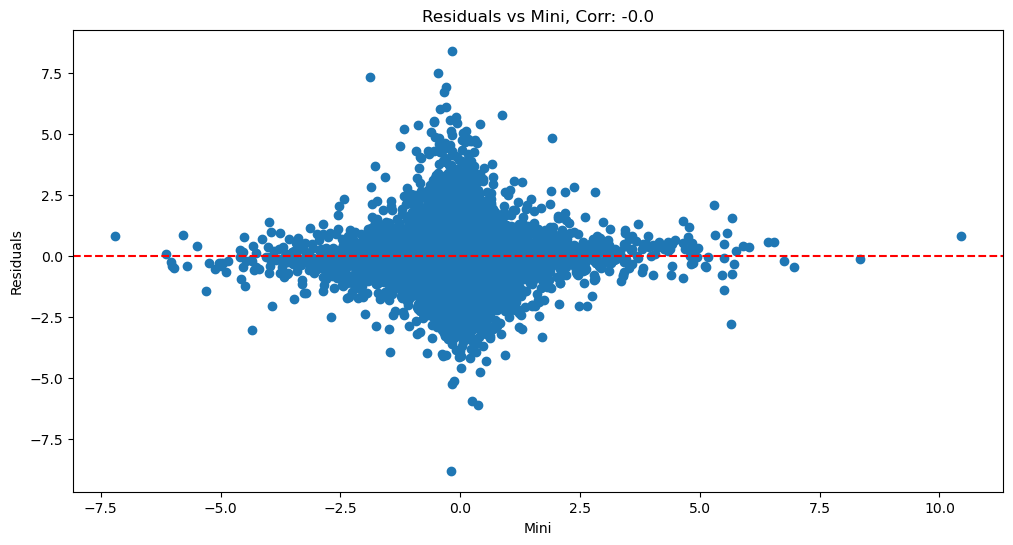

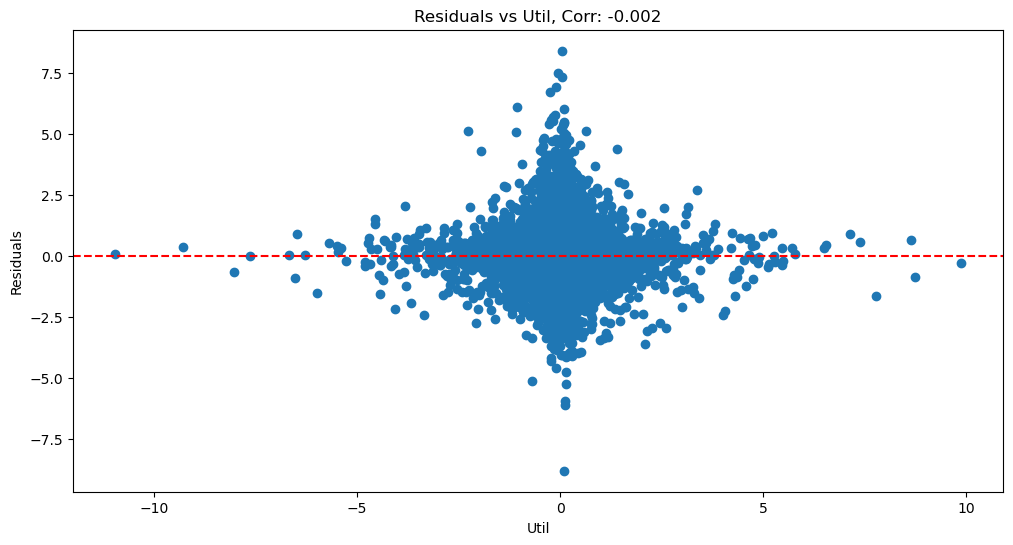

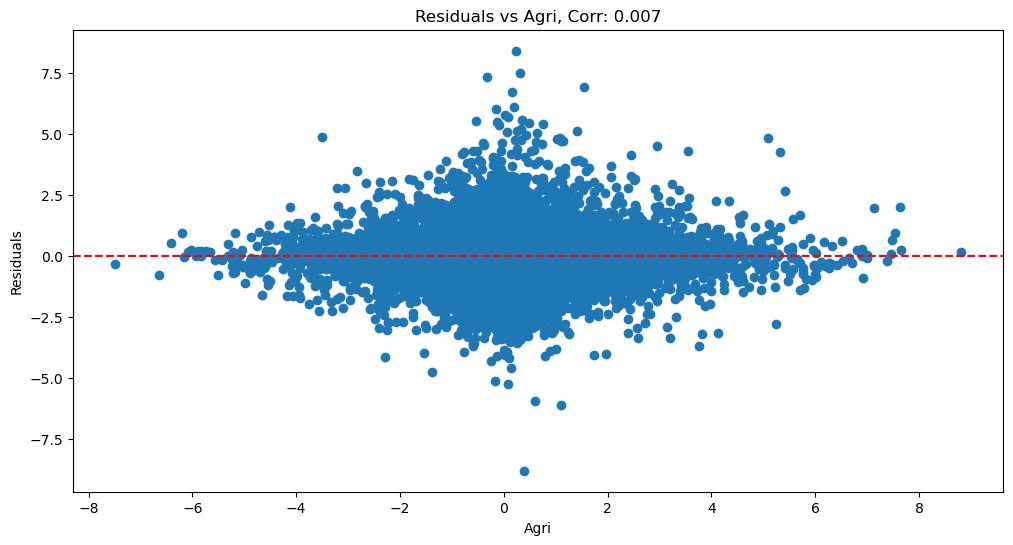

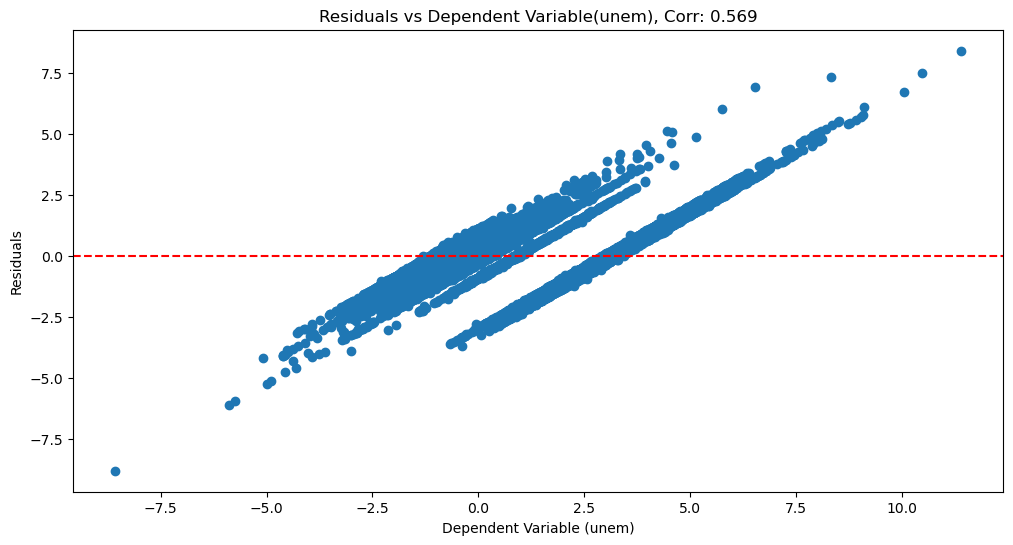


Best model with clusters and time effects:
                          PanelOLS Estimation Summary                           
Dep. Variable:                   unem   R-squared:                        0.6762
Estimator:                   PanelOLS   R-squared (Between):              0.6786
No. Observations:               26823   R-squared (Within):               0.6779
Date:                Wed, May 29 2024   R-squared (Overall):              0.6762
Time:                        13:31:58   Log-likelihood                -3.228e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2332.4
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                F(24,26799)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):    

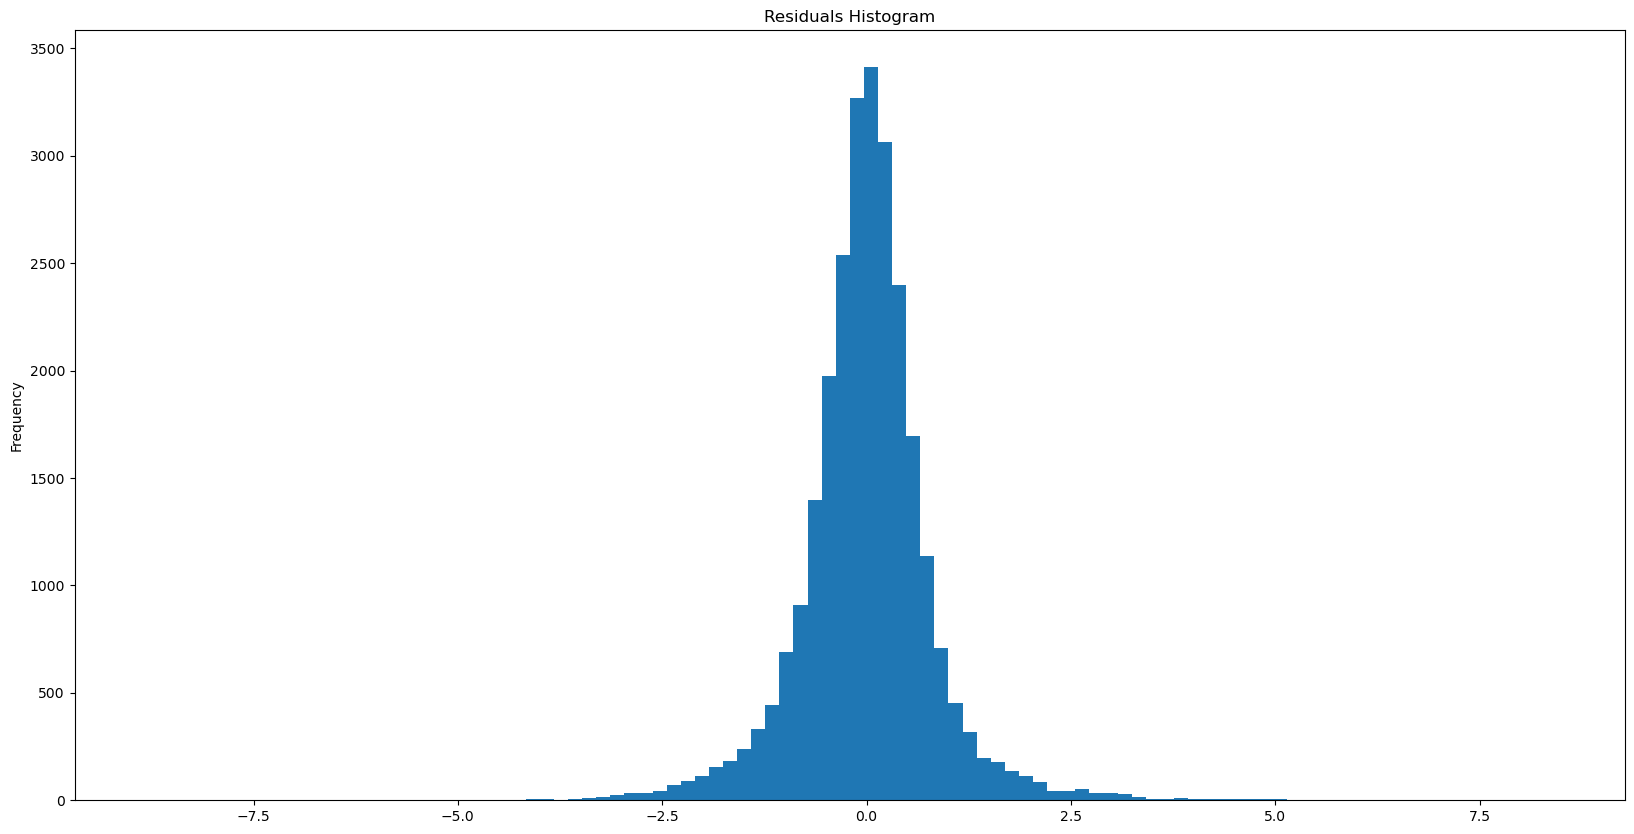

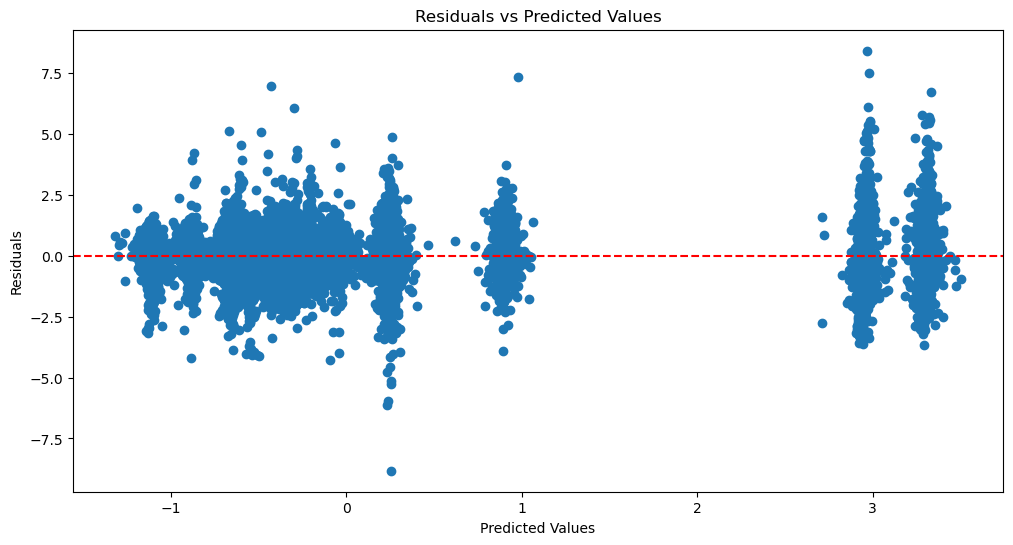

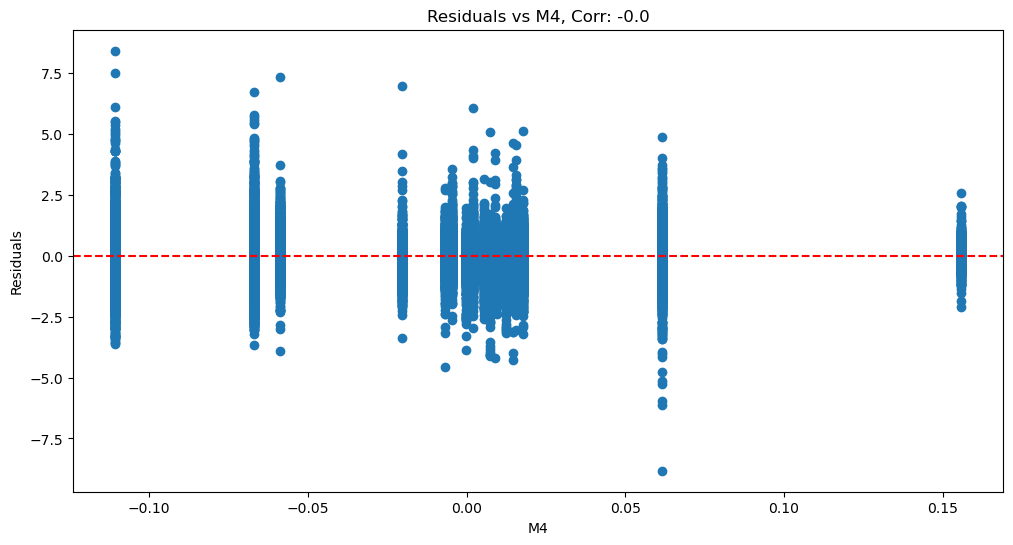

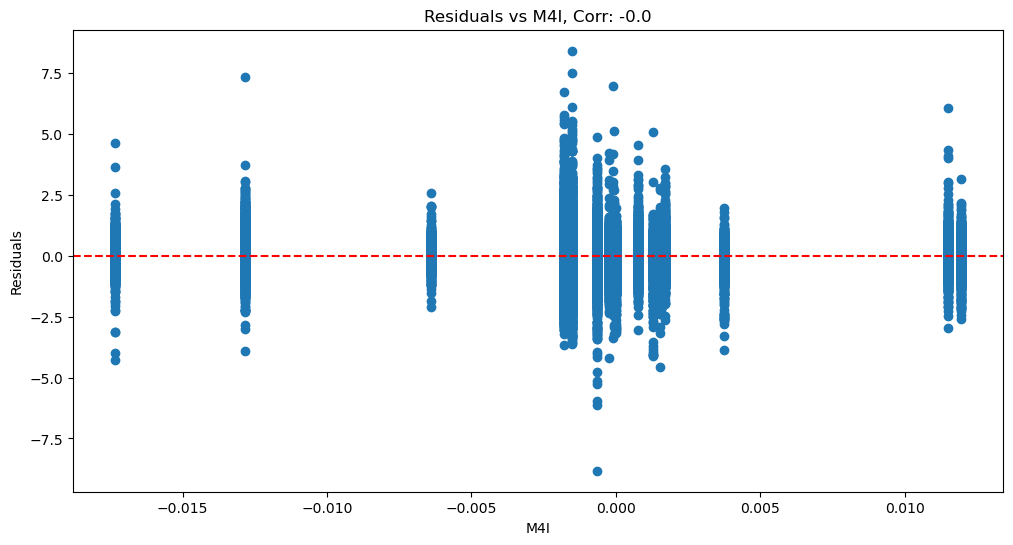

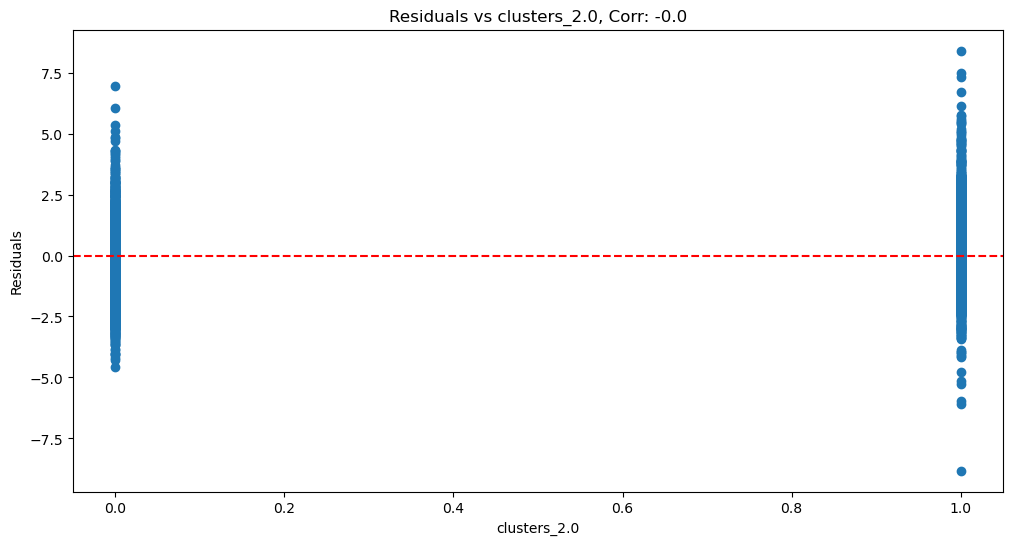

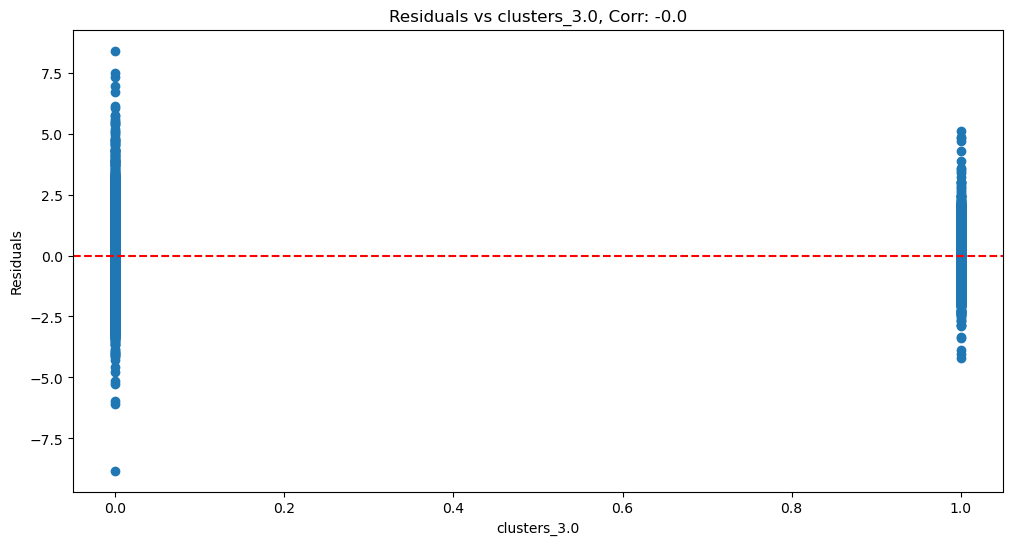

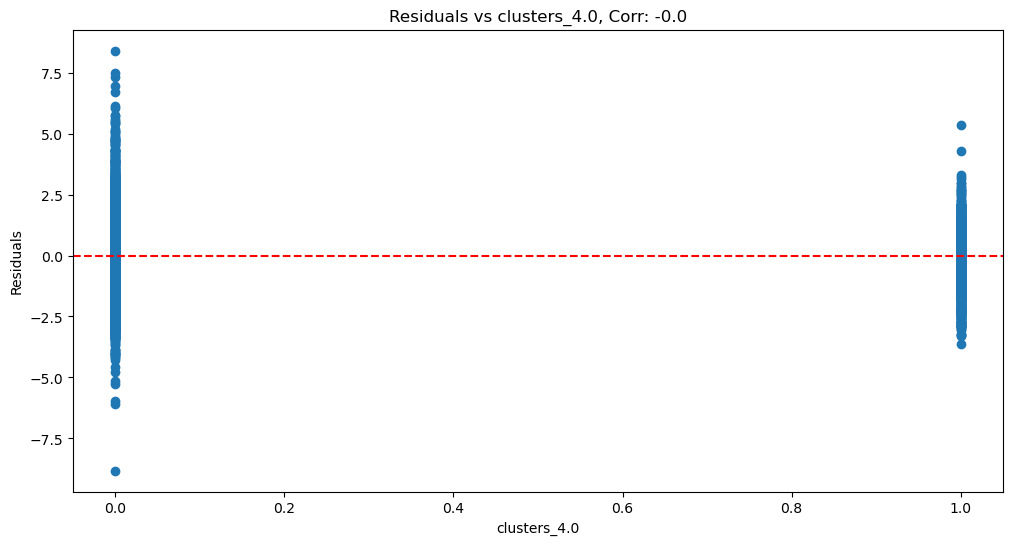

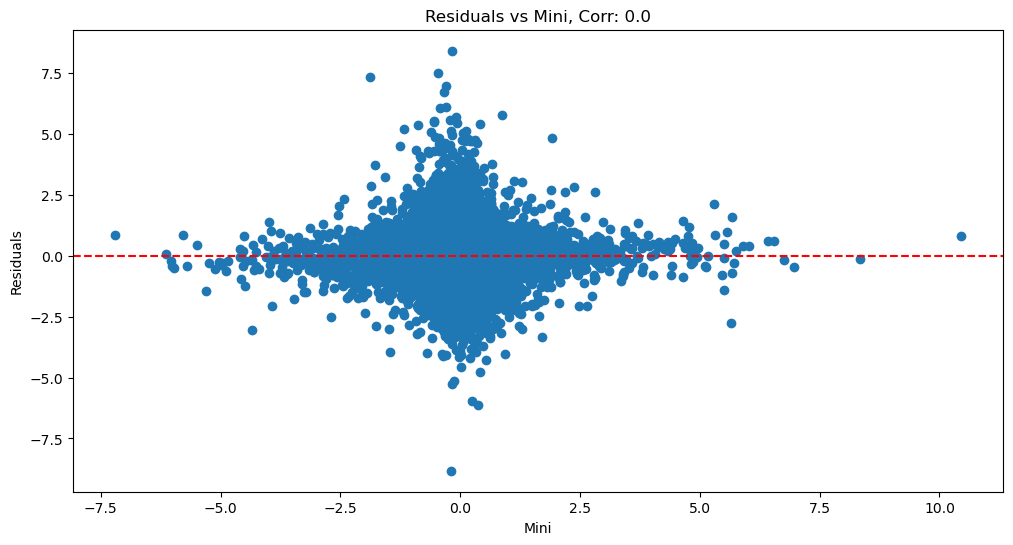

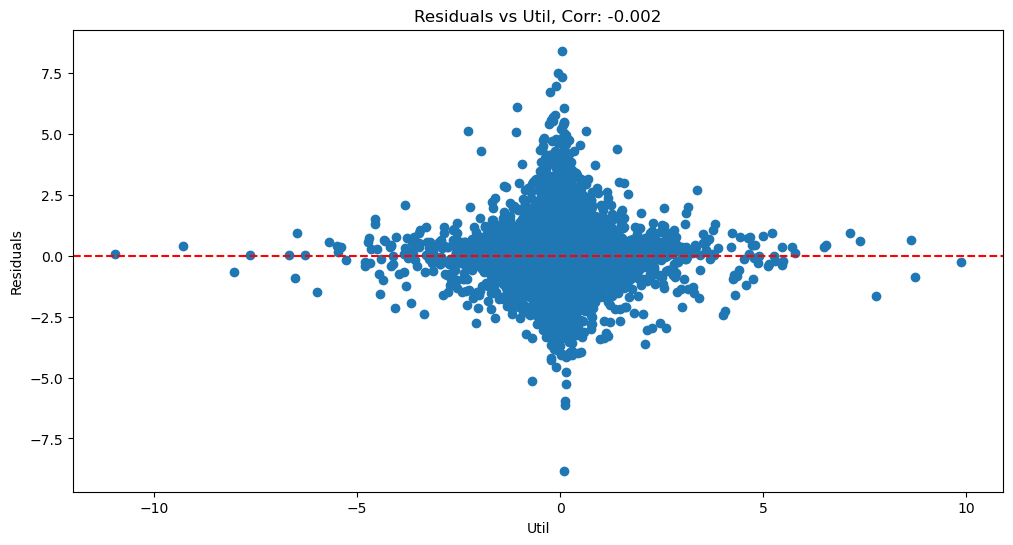

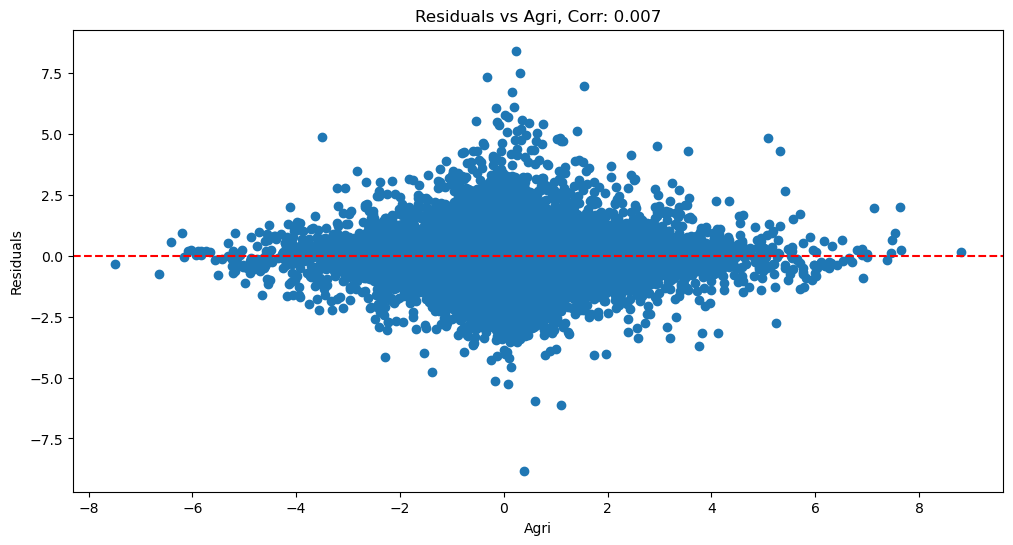

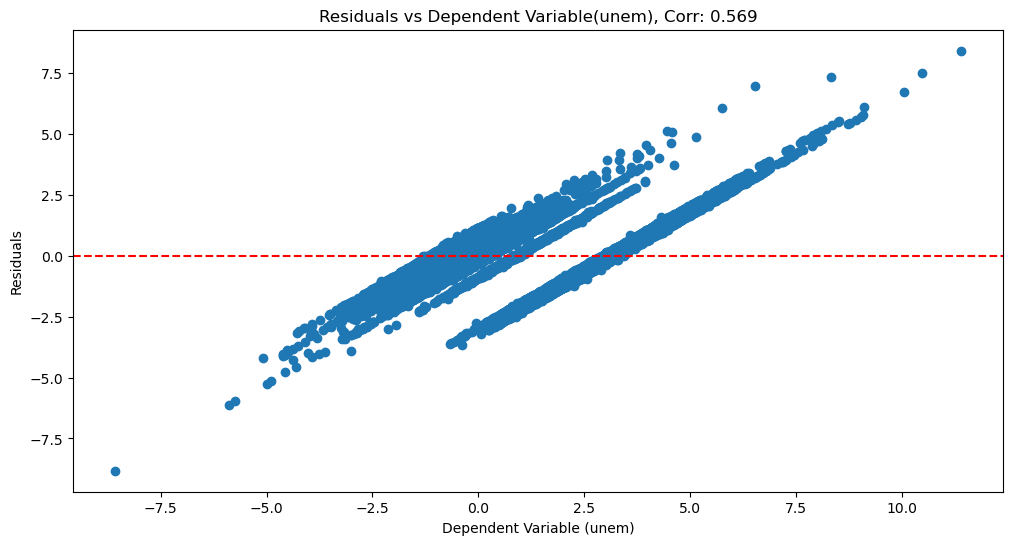


Best model with entity and time effects:
                          PanelOLS Estimation Summary                           
Dep. Variable:                   unem   R-squared:                        0.6779
Estimator:                   PanelOLS   R-squared (Between):              0.3118
No. Observations:               26823   R-squared (Within):               0.6779
Date:                Wed, May 29 2024   R-squared (Overall):              0.6219
Time:                        13:31:59   Log-likelihood                 -3.16e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2856.3
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                F(18,24428)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):      

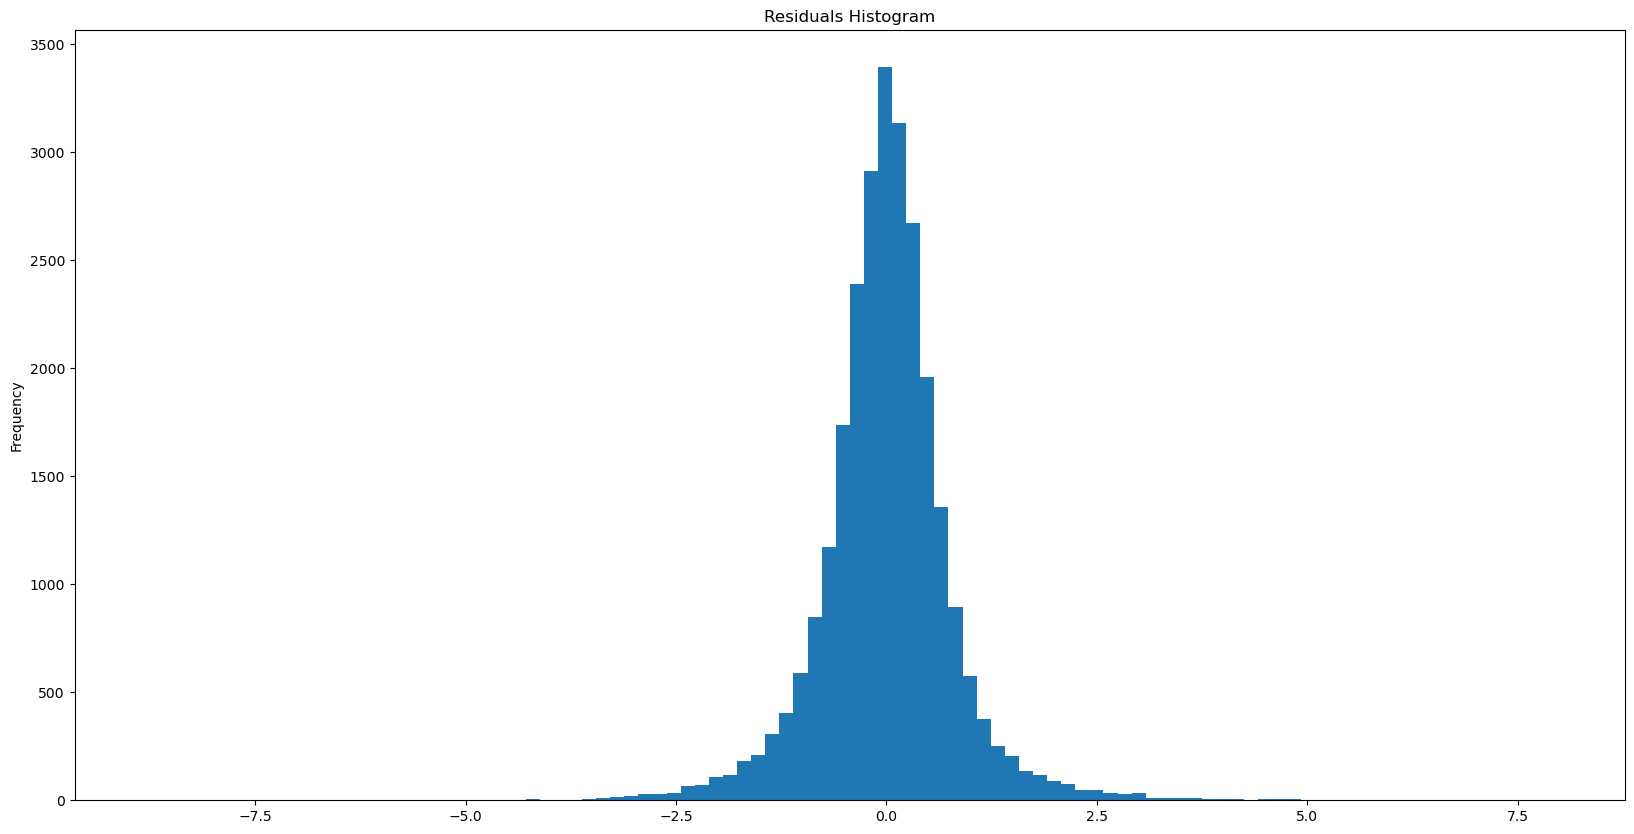

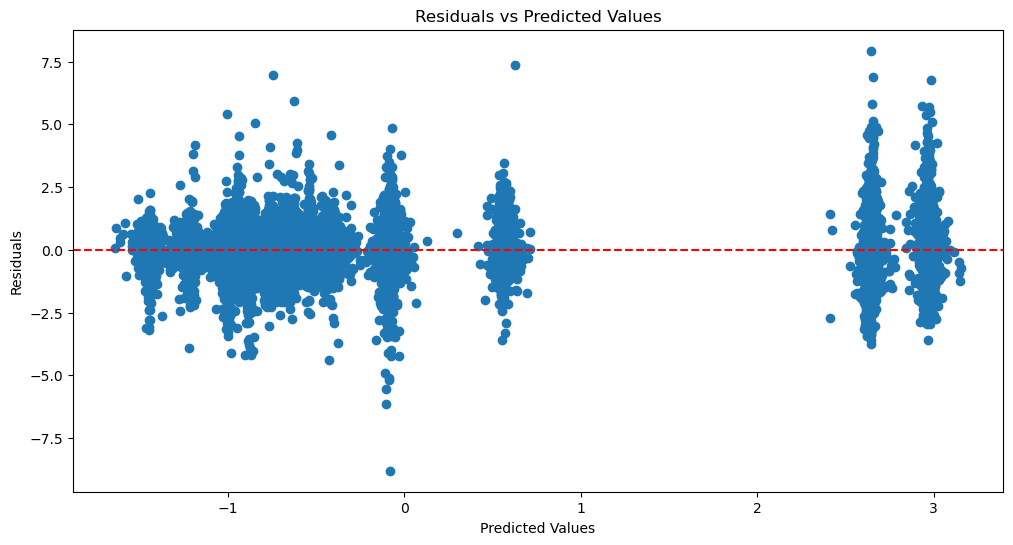

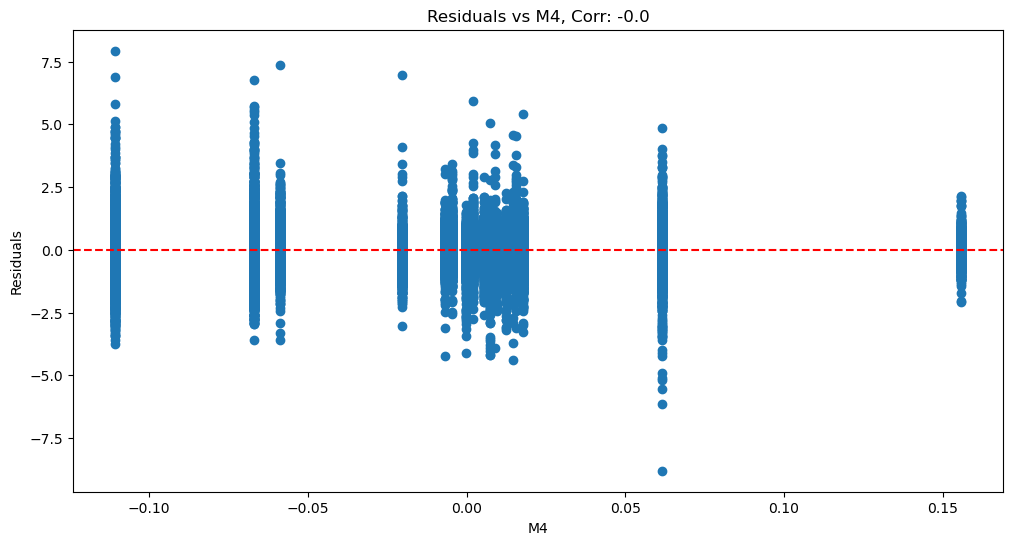

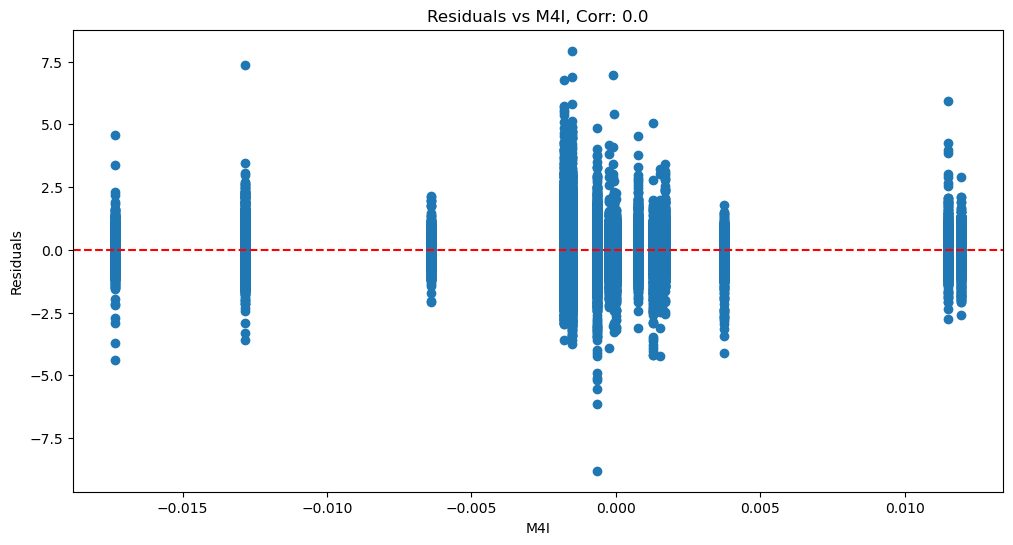

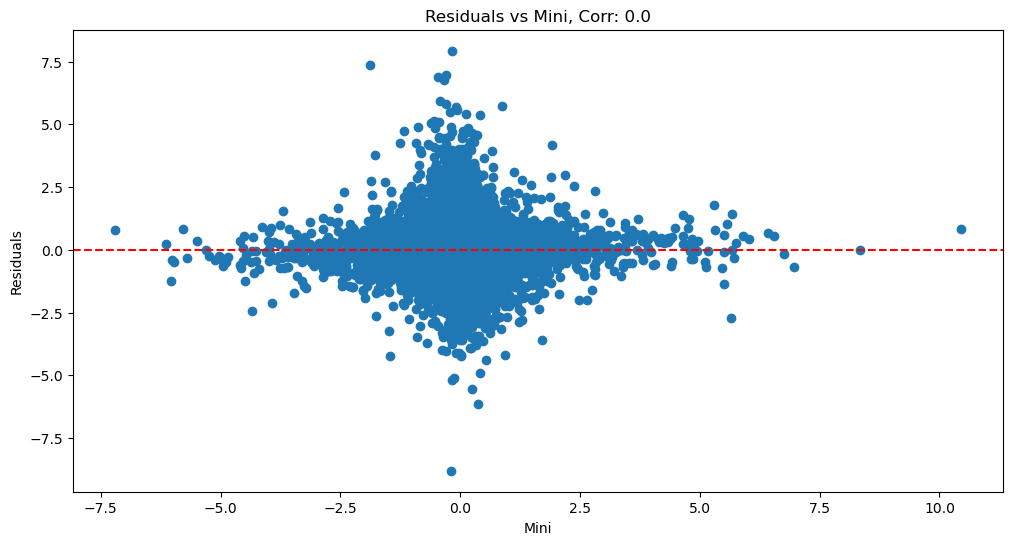

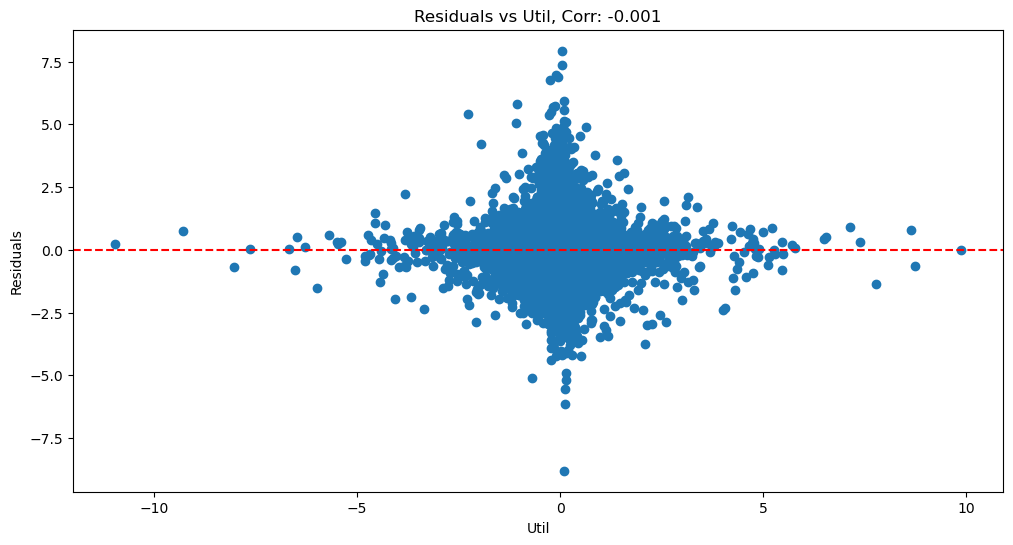

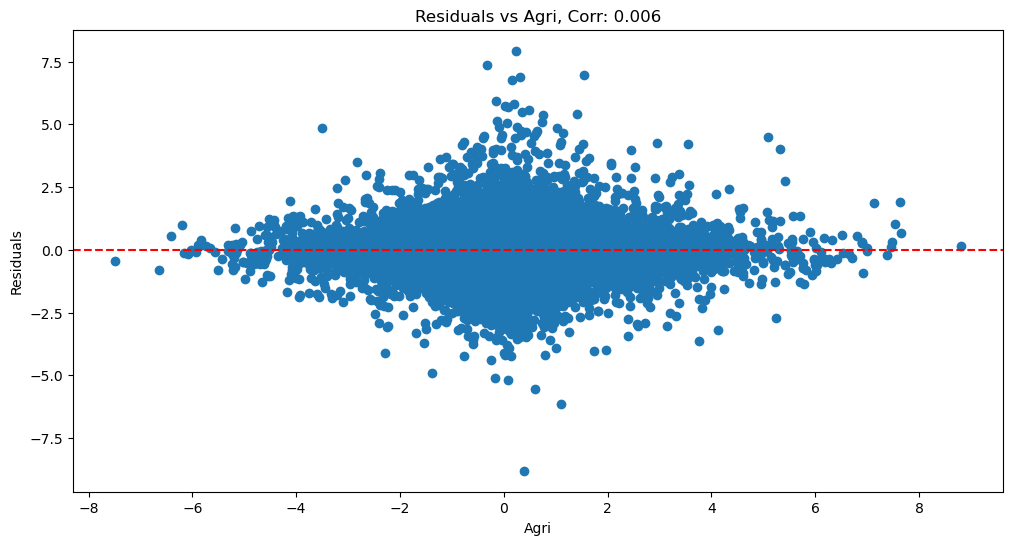

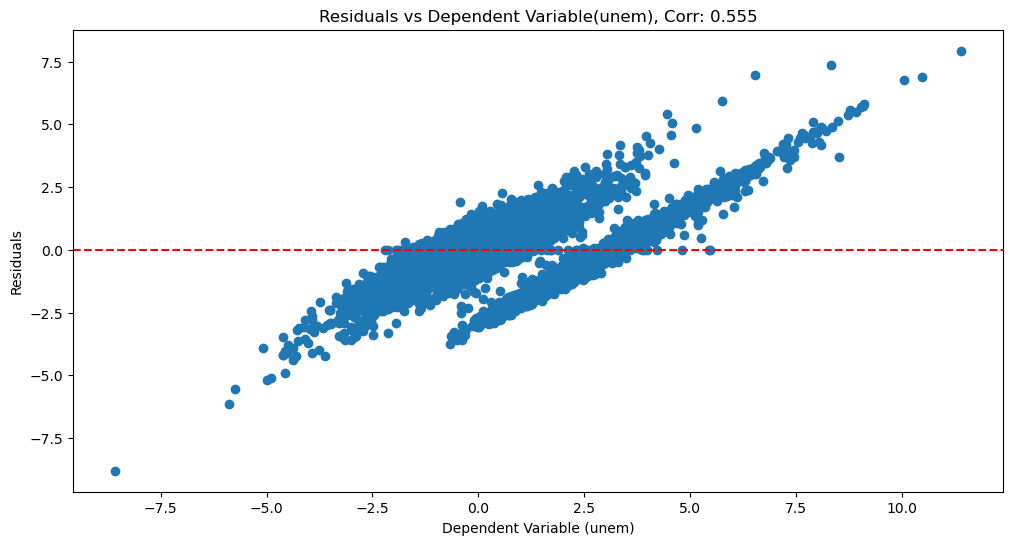

In [40]:
# List of potential predictors excluding clusters, M4, and M4I
potential_predictors = ['Mini', 'Util', 'Agri']
dependent_var = ['unem']

# Run forward stepwise selection for the three cases

# Including clusters only
fixed_predictors_1 = ['M4', 'M4I'] + cluster_dummies
best_model_1, best_aic_1, results_df_1 = forward_stepwise_selection(df, 'unem', fixed_predictors_1, potential_predictors)

# Including entity effects only
fixed_predictors_2 = ['M4', 'M4I', 'EntityEffects']
best_model_2, best_aic_2, results_df_2 = forward_stepwise_selection(df, 'unem', fixed_predictors_2, potential_predictors)

# Including time effects only
fixed_predictors_3 = ['M4', 'M4I', 'C(TimePeriod)']
best_model_3, best_aic_3, results_df_3 = forward_stepwise_selection(df, 'unem', fixed_predictors_3, potential_predictors)

# Including cluster and time effects
fixed_predictors_4 = ['M4', 'M4I', 'C(TimePeriod)'] + cluster_dummies
best_model_4, best_aic_4, results_df_4 = forward_stepwise_selection(df, 'unem', fixed_predictors_4, potential_predictors)

# Including entity and time effects
fixed_predictors_5 = ['M4', 'M4I', 'EntityEffects', 'C(TimePeriod)']
best_model_5, best_aic_5, results_df_5 = forward_stepwise_selection(df, 'unem', fixed_predictors_5, potential_predictors)


# Fit the best models and get their summaries
best_models = [best_model_1, best_model_2, best_model_3, best_model_4, best_model_5]
fixed_predictors_list = [fixed_predictors_1, fixed_predictors_2, fixed_predictors_3,
                        fixed_predictors_4, fixed_predictors_5]

model_names = ['Best model with clusters included', 
               'Best model with entity effects only',
               'Best model with time effects only',
               'Best model with clusters and time effects',
               'Best model with entity and time effects']

formula_model_dict = {
    'Models with cluster included': results_df_1,
    'Models with entity effects only': results_df_2,
    'Models with time effects only': results_df_3,
    'Models with clusters and time effects': results_df_4,
    'Models with entity and time effects': results_df_5}


for i, best_model in enumerate(best_models):
    print(f'\n{model_names[i]}:')
#     print(f'\nBest model (case {i+1}):')
    # Panel OLS regressions
    results_fw = get_model_summary(best_model, df, 'PanelOLS')
    print(results_fw.summary)


    # Plot the regression diagnostics for the panel regressions
    plot_residuals_vs_predicted(results_fw, df)
    plot_residuals_vs_independent_vars(results_fw, df, fixed_predictors_list[i], potential_predictors)
    plot_residuals_vs_dependent_var(results_fw, df)
   

### Checking the effects of including effects and the effect of M4 variables

First we create time dummy variables and join it to the dataframe

In [49]:
# Creating dummy variables for TimePeriod
time_dummies = pd.get_dummies(df['TimePeriod'], drop_first=True)
df = df.join(time_dummies)

Now we fit the regression with the time dummies only

In [85]:
# Define the independent variables excluding M4 and M4I
independent_vars_time = list(time_dummies.columns)

# Create the model
model_time = PanelOLS(df['unem'], df[independent_vars_time], entity_effects=True)
results_time = model_time.fit(cov_type='clustered', cluster_entity=True)

print(results_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:                   unem   R-squared:                        0.6776
Estimator:                   PanelOLS   R-squared (Between):              0.4572
No. Observations:               26823   R-squared (Within):               0.6776
Date:                Thu, May 30 2024   R-squared (Overall):              0.6429
Time:                        13:44:18   Log-likelihood                -3.162e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3019.9
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                F(17,24429)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):             820.92
                            

Now we fit the model using only the monetary variables. Here we also include entity effects

In [69]:
# Define the independent variables excluding time effects
independent_vars_m4 = ['M4', 'M4I']

# Create the model
model_m4 = PanelOLS(df['unem'], df[independent_vars_m4], entity_effects=True, time_effects=False)
results_m4 = model_m4.fit(cov_type='clustered', cluster_entity=True)

print(results_m4)


                          PanelOLS Estimation Summary                           
Dep. Variable:                   unem   R-squared:                        0.2717
Estimator:                   PanelOLS   R-squared (Between):              0.3203
No. Observations:               26823   R-squared (Within):               0.2717
Date:                Thu, May 30 2024   R-squared (Overall):              0.2704
Time:                        13:35:51   Log-likelihood                -4.255e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4560.3
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                 F(2,24444)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):             3333.9
                            

Next we attempt to include both in the model fitting (i.e, monetary variables and time dummies). However, this generates the error 'exog does not have full column rank. If you wish to proceed with model estimation irrespective of the numerical accuracy of coefficient estimates, you can set check_rank=False'. And thus, to avoid breaking the code, check_rank=False. The results indicate total insignificance of the monetary variables and the time dummies.

Including entity effects also throws the following error : 'The model cannot be estimated. The included effects have fully absorbed
one or more of the variables. This occurs when one or more of the dependent
variable is perfectly explained using the effects included in the model.

The following variables or variable combinations have been fully absorbed
or have become perfectly collinear after effects are removed: M4 variables and the time dummies'.

In order to fit the regression however, we need to set drop_absorbed=True to automatically drop absorbed variables. Doing this gives a better result (in terms of significance), but results in  a negative between $R^2$.

In [102]:
# Define the independent variables excluding time effects
independent_vars_m4_time = ['M4', 'M4I'] + list(time_dummies.columns)

# Create the model
model_m4_time = PanelOLS(df['unem'], df[independent_vars_m4_time], 
                         entity_effects=True, check_rank=False, drop_absorbed=True)
results_m4_time = model_m4_time.fit(cov_type='clustered', cluster_entity=True)

print(results_m4_time)


                          PanelOLS Estimation Summary                           
Dep. Variable:                   unem   R-squared:                        0.6776
Estimator:                   PanelOLS   R-squared (Between):             -0.5813
No. Observations:               26823   R-squared (Within):               0.6776
Date:                Thu, May 30 2024   R-squared (Overall):              0.4941
Time:                        14:04:32   Log-likelihood                -3.162e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      3019.9
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                F(17,24429)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):             820.92
                            

### Remarks

The results of the global variables indicate that the monetary variables are perfectly collinear with the time period (time dummies). This makes the inclusion of time effects impossible. However, this was not also the reason for the difficulty in the time effects. Results also indicate that any inclusion of time effects even in the absence of the monetary variables, and or clusters, there appears to be perfect collinearity between the variables and time (i.e, Agriculture, Utilities, Mining all have perfect collinearity with time).

The conclusion will be to ignore time effects and work with the results from entity effects and without entity effects, which depends on the result of clusters inclusion.

#### VIF calculation

Calculate VIF to identify multicollinearity. This was done because the model would not run if all variables were included, it throws the error 'exog variables do not have full column rank'. After calculating the vif, 'TimePeriod' was found to be the problematic variable in the regression. This variable was omitted in the pooled regression.

In [41]:
# Creating a dataframe for VIF calculation
X = df[['M4', 'M4I', 'Mini', 'Util', 'Agri', 'clusters_2.0', 'clusters_3.0', 'clusters_4.0', 'TimePeriod']]
#X['Intercept'] = 1  # Add intercept for VIF calculation

# Calculating VIF for each variable
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

       Variable       VIF
0            M4  1.011141
1           M4I  1.004900
2          Mini  1.002934
3          Util  1.001503
4          Agri  1.006895
5  clusters_2.0  1.827654
6  clusters_3.0  1.545541
7  clusters_4.0  1.375324
8    TimePeriod  2.754241


#### Pooled OLS regression

Now we perform the pooled OLS regression, omitting TimePeriod

                          PooledOLS Estimation Summary                          
Dep. Variable:                   unem   R-squared:                        0.2727
Estimator:                  PooledOLS   R-squared (Between):              0.3397
No. Observations:               26823   R-squared (Within):               0.2722
Date:                Wed, May 29 2024   R-squared (Overall):              0.2727
Time:                        13:32:00   Log-likelihood                -4.313e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1257.0
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                 F(8,26815)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):             1257.0
                            

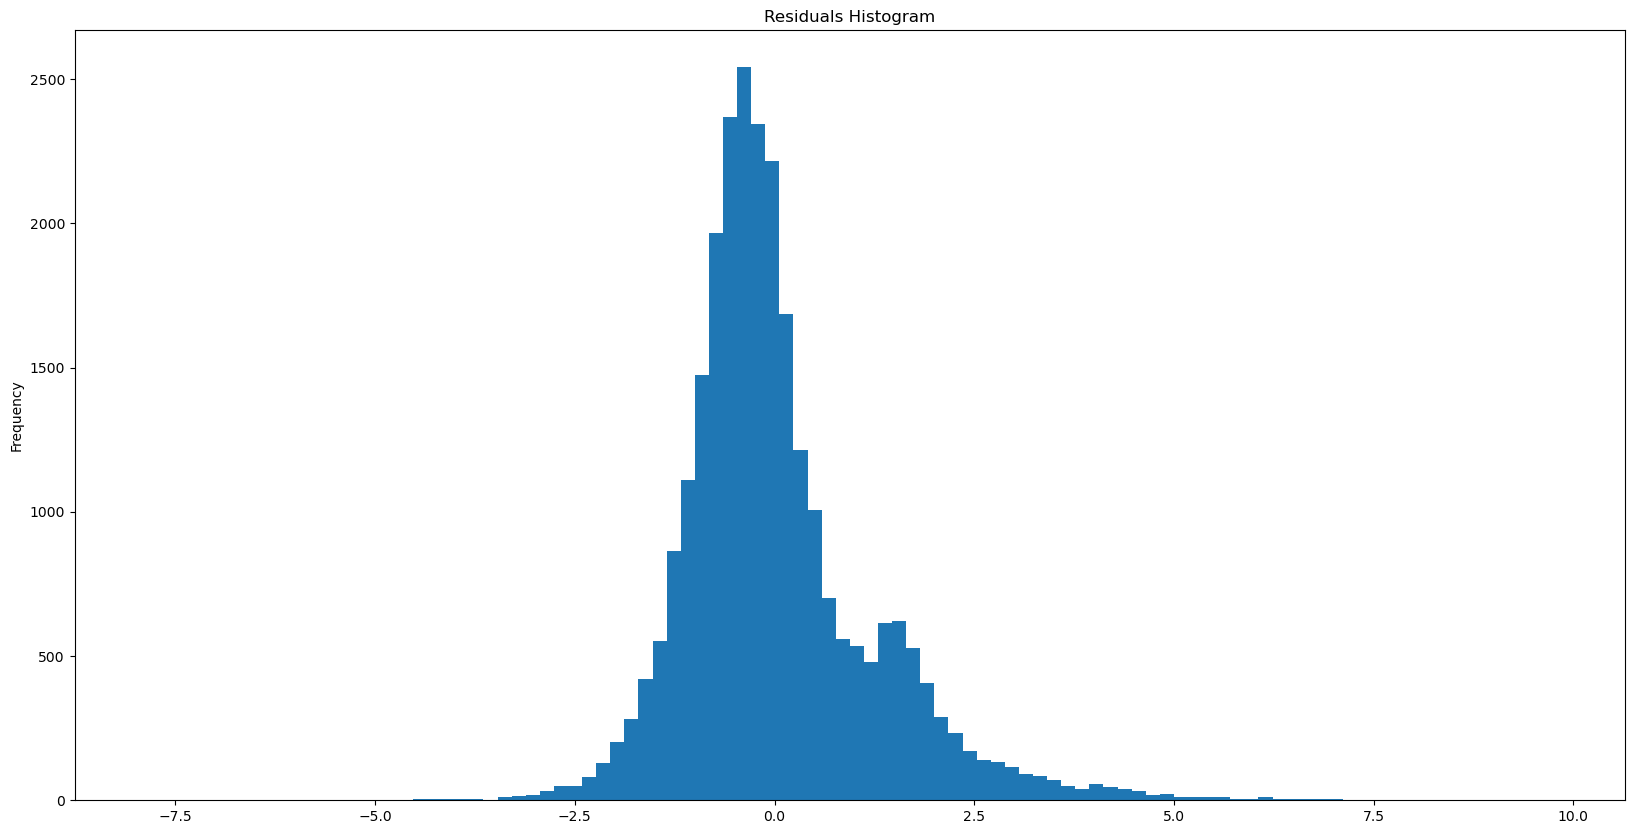

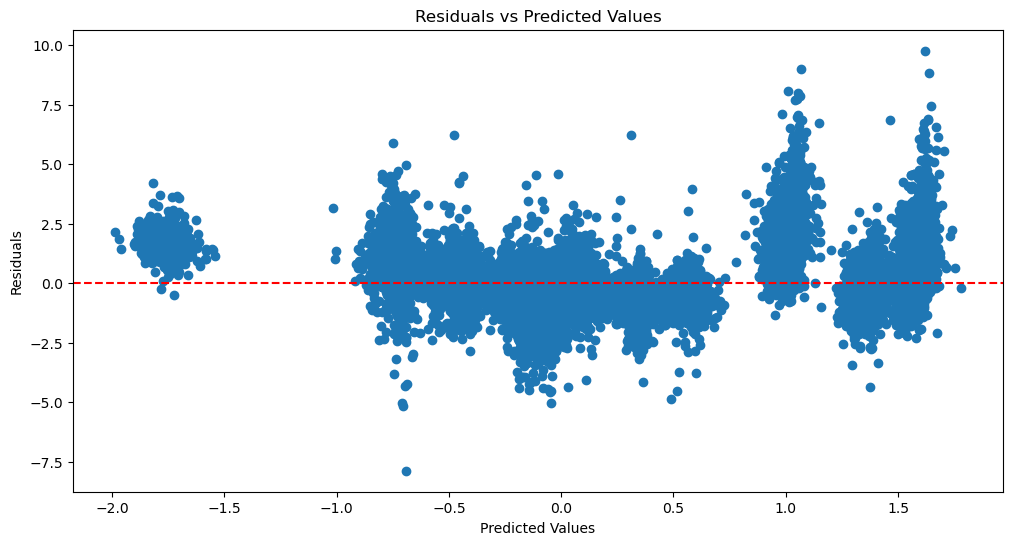

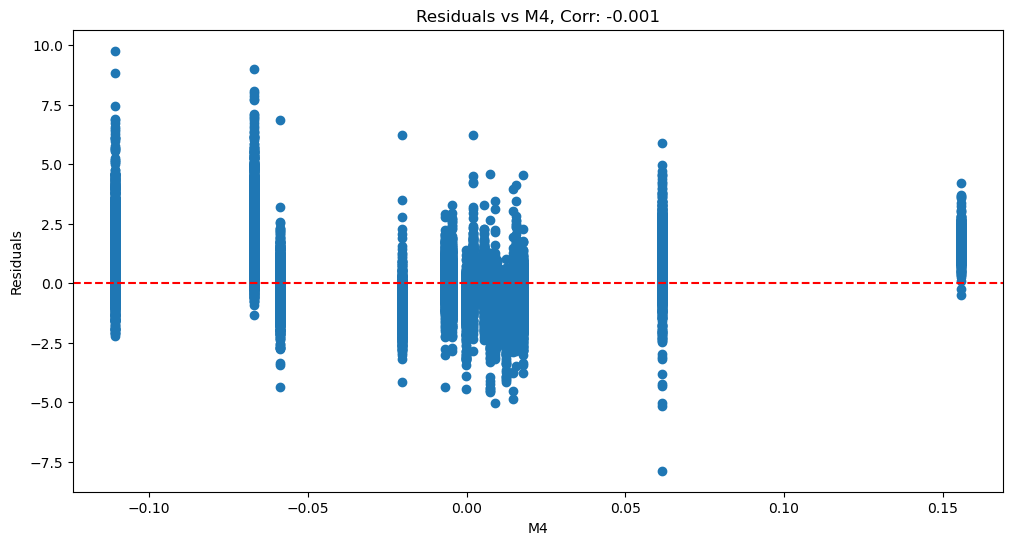

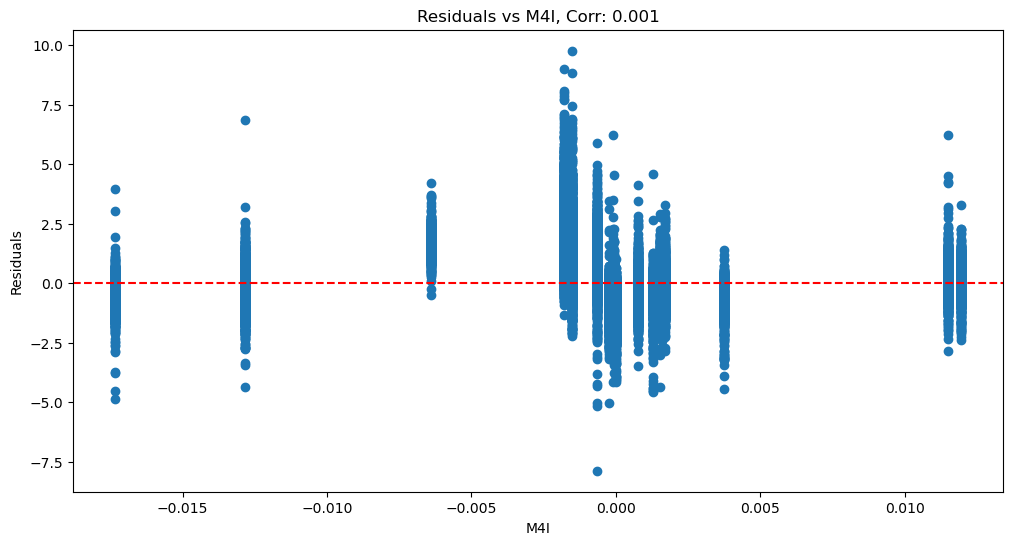

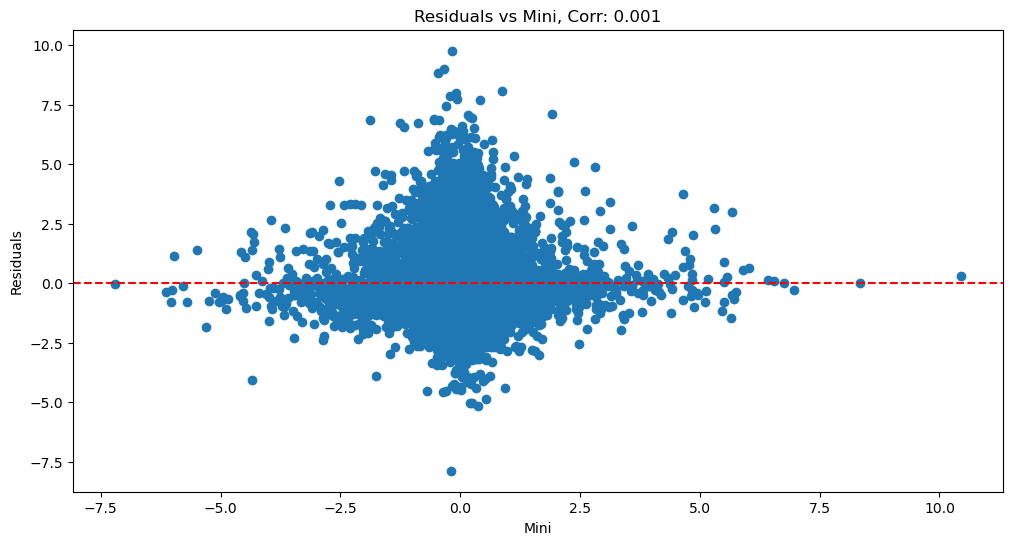

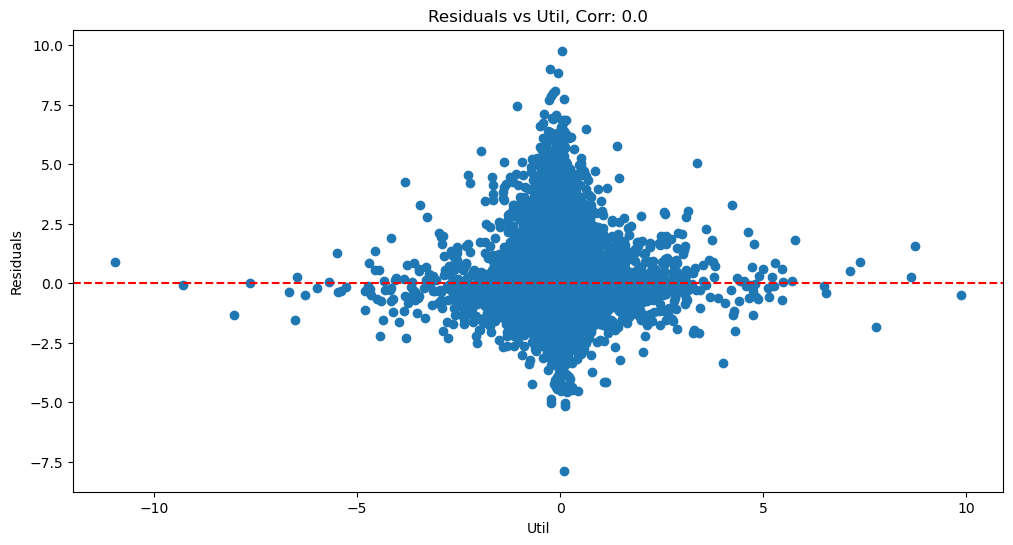

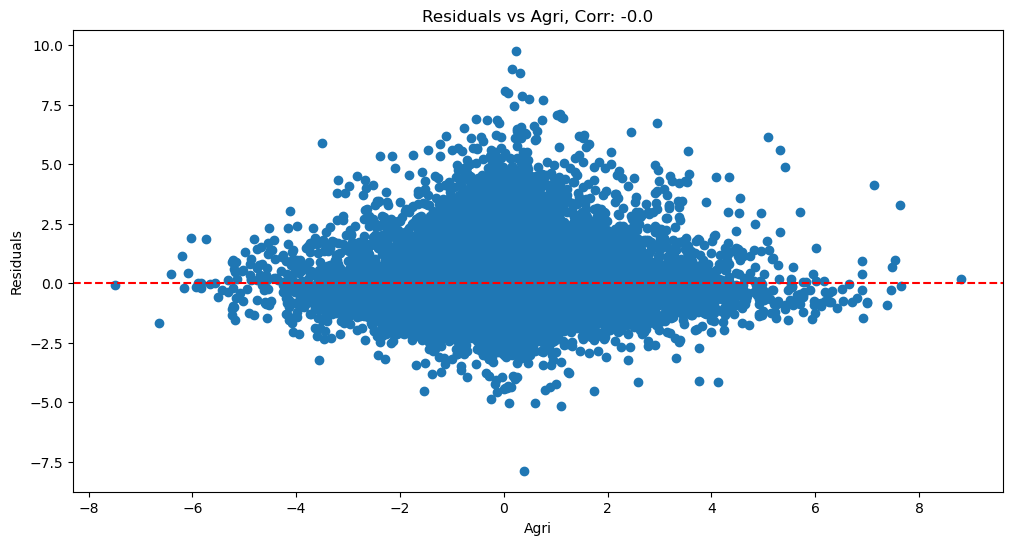

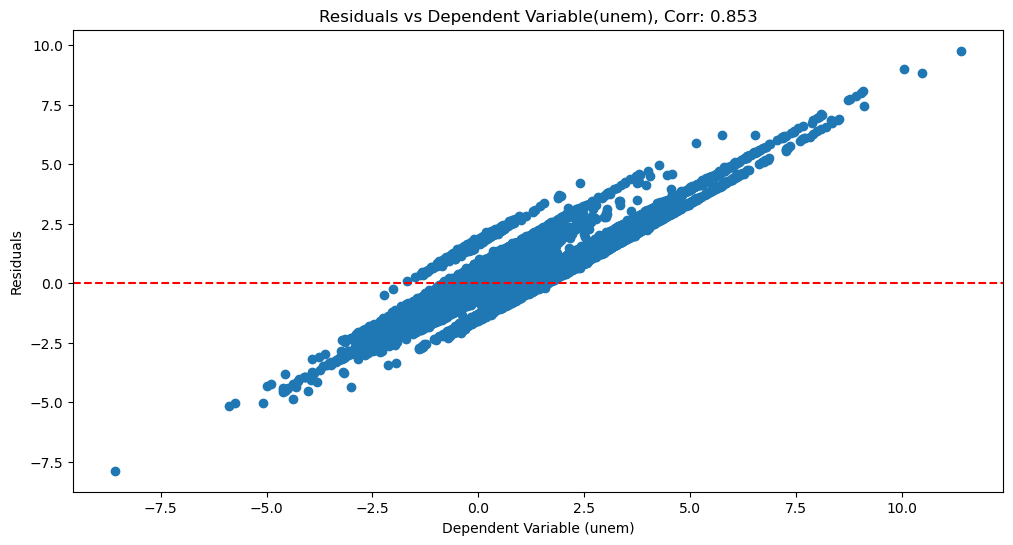

In [42]:
potential_predictors = ['Mini', 'Util', 'Agri']
dependent_var = ['unem']
fixed_predictors_1 = ['M4', 'M4I'] + cluster_dummies

pooled_formula = "unem ~ M4 + M4I + Mini + Util + Agri + clusters_2.0 + clusters_3.0 + clusters_4.0"

reg_pooled =PooledOLS.from_formula(formula = pooled_formula,
                                    data = df, check_rank=True)
results_pooled = reg_pooled.fit()
print(results_pooled.summary)

plot_residuals_vs_predicted(results_pooled, df)
plot_residuals_vs_independent_vars(results_pooled, df, fixed_predictors_list[i], potential_predictors)
plot_residuals_vs_dependent_var(results_pooled, df)
   

Comparing the forward selection results side by side.

In [43]:
# Store the summaries
summaries = {model_name: get_model_summary(model, df, 'PanelOLS') for model_name, model in zip(model_names, best_models)}

# Add the pooled model summary to the summaries dictionary
summaries['Pooled model'] = results_pooled
comparison = compare(summaries)

comparison

Model Comparison                                                                                                         
==================================================================================================================================================================================================================================
                          Best model with clusters included Best model with entity effects only Best model with time effects only Best model with clusters and time effects Best model with entity and time effects   Pooled model
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable                                          unem                                unem                              unem                                      unem                                    unem           unem
Estimator                                          PanelOLS                            PanelOLS                          PanelOLS                                  PanelOLS                                PanelOLS      PooledOLS
No. Observations                                      26823                               26823                             26823                                     26823                                   26823          26823
Cov. Est.                                        Unadjusted                          Unadjusted                        Unadjusted                                Unadjusted                              Unadjusted     Unadjusted
R-squared                                            0.2727                              0.2722                            0.6762                                    0.6762                                  0.6779         0.2727
R-Squared (Within)                                   0.2722                              0.2722                            0.6779                                    0.6779                                  0.6779         0.2722
R-Squared (Between)                                  0.3397                              0.3228                            0.6775                                    0.6786                                  0.3118         0.3397
R-Squared (Overall)                                  0.2727                              0.2709                            0.6762                                    0.6762                                  0.6219         0.2727
F-statistic                                          1257.0                              2285.3                            2665.1                                    2332.4                                  2856.3         1257.0
P-value (F-stat)                                     0.0000                              0.0000                            0.0000                                    0.0000                                  0.0000         0.0000
=======================                        ============                        ============                    ==============                            ==============                            ============   ============
M4                                                  -13.233                             -13.199                           -0.6228                                   -0.6232                                 -18.606        -13.233
                                                  (-92.813)                           (-89.415)                      (-4.561e-08)                              (-4.565e-08)                               (-121.74)      (-92.813)
M4I                                                 -40.668                             -39.704                           -0.0318                                   -0.0317                                 -380.96        -40.668
                   

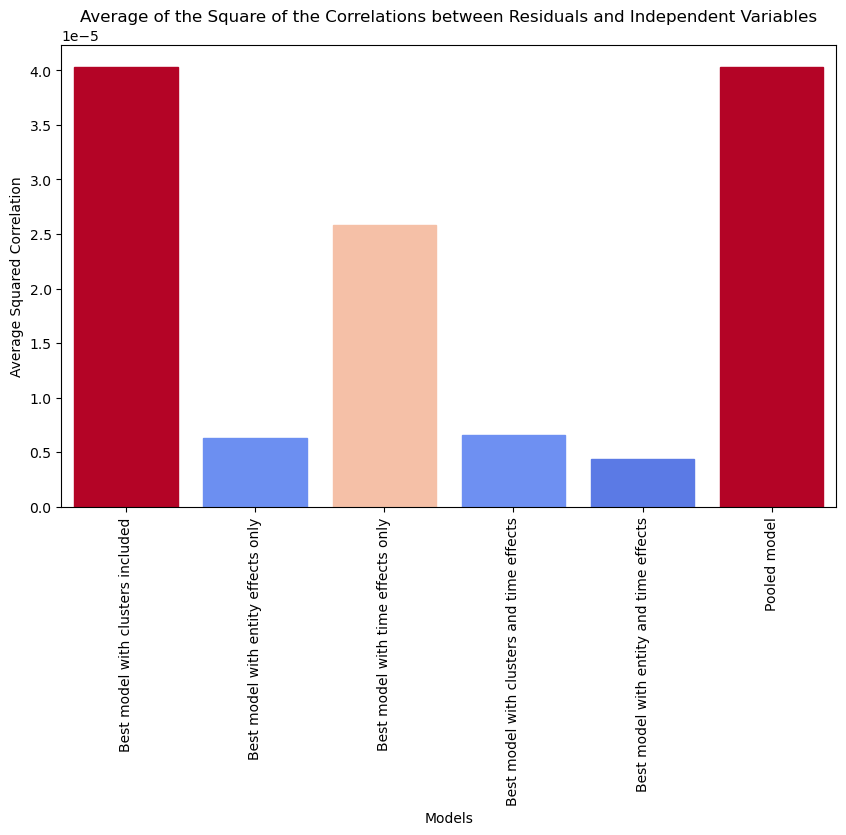

In [44]:
    # Calculate average squared correlations for each model
avg_squared_correlations = {}
    for name, summary in summaries.items():
        avg_corr, _ = calculate_avg_squared_correlations(summary, df, fixed_predictors_1 + potential_predictors)
        avg_squared_correlations[name] = avg_corr

# Create a bar chart
model_names = list(avg_squared_correlations.keys())
avg_squared_corr_values = list(avg_squared_correlations.values())

plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x=model_names, y=avg_squared_corr_values, palette='coolwarm')

# Color bars based on their height (average squared correlation value)
    for index, bar in enumerate(bar_plot.patches):
        bar.set_color(plt.cm.coolwarm(avg_squared_corr_values[index] / max(avg_squared_corr_values)))

plt.title('Average of the Square of the Correlations between Residuals and Independent Variables')
plt.xlabel('Models')
plt.ylabel('Average Squared Correlation')
plt.xticks(rotation=90)
plt.show()

Finally, we create a bar chart to display each of the formulas based on the best models by AIC.

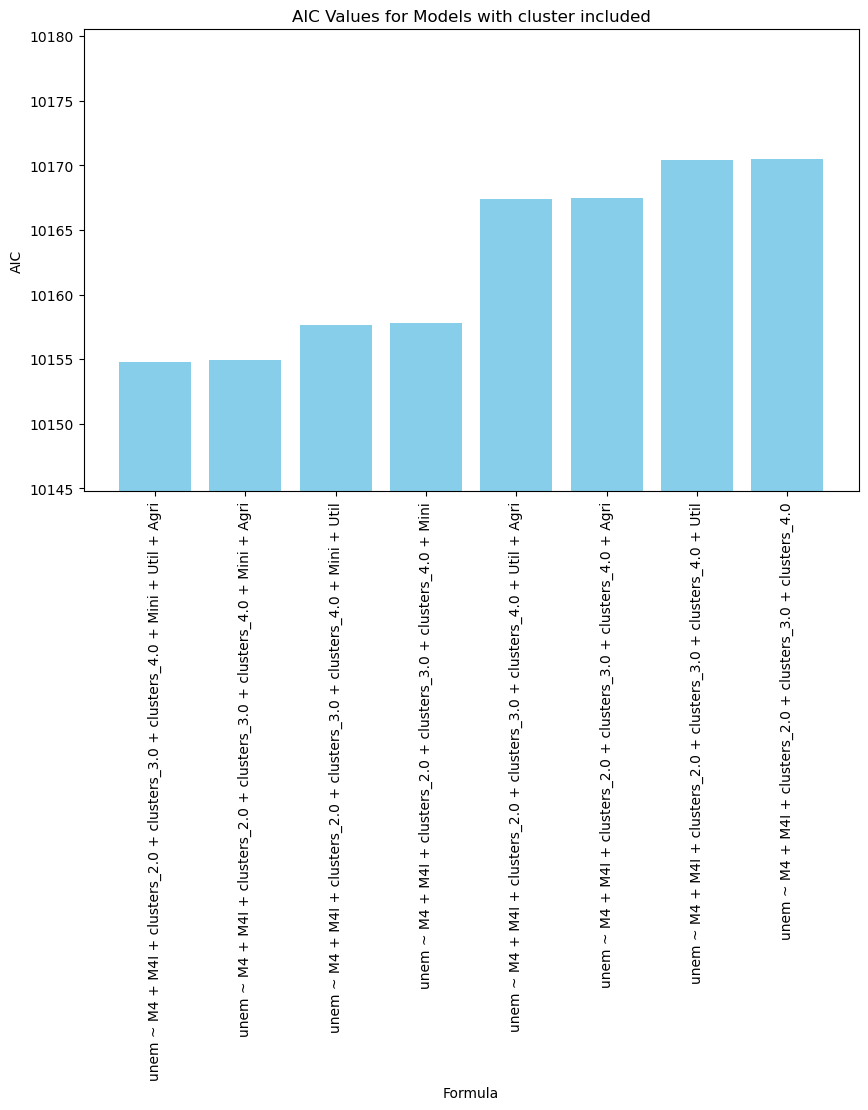

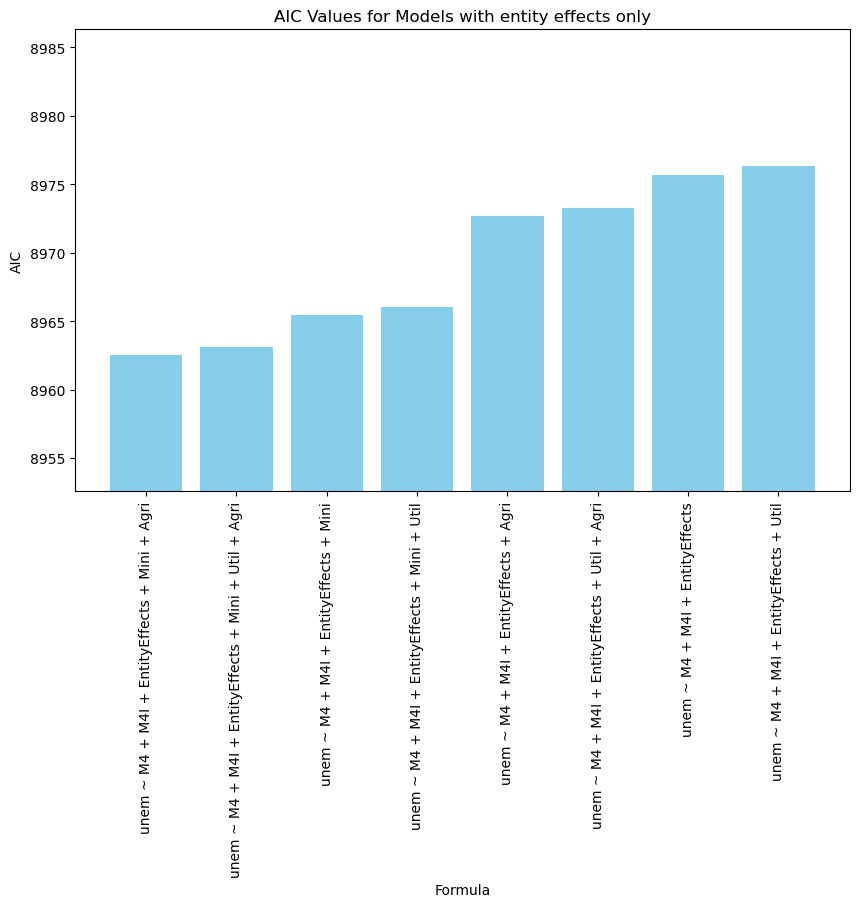

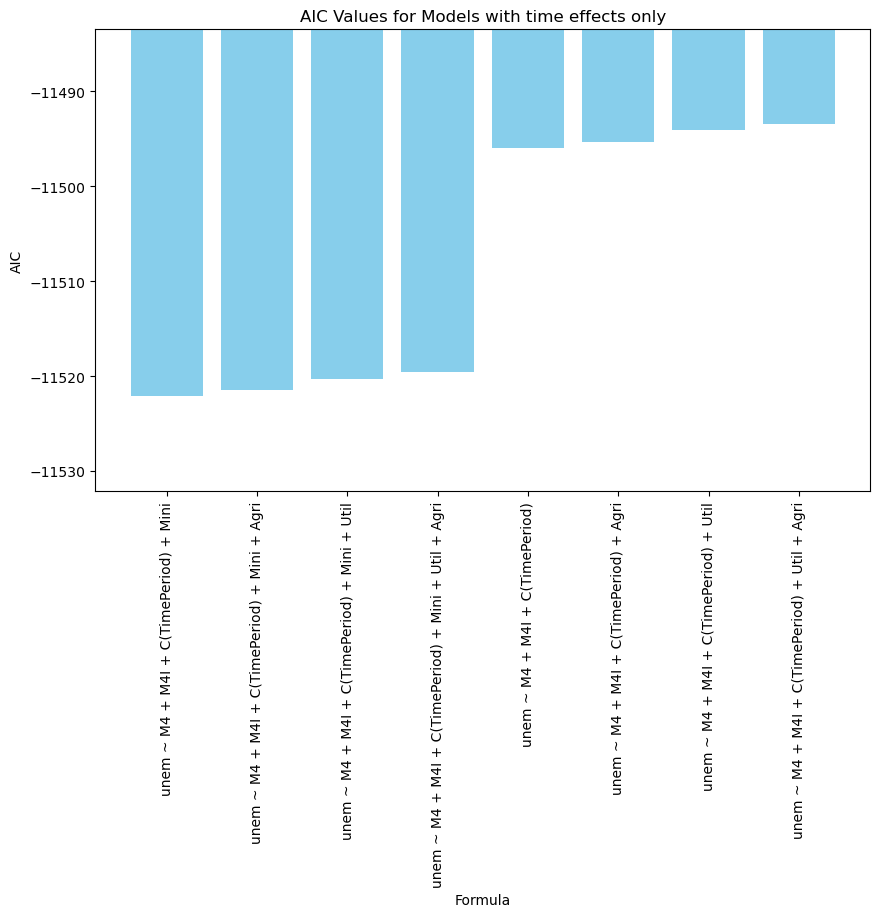

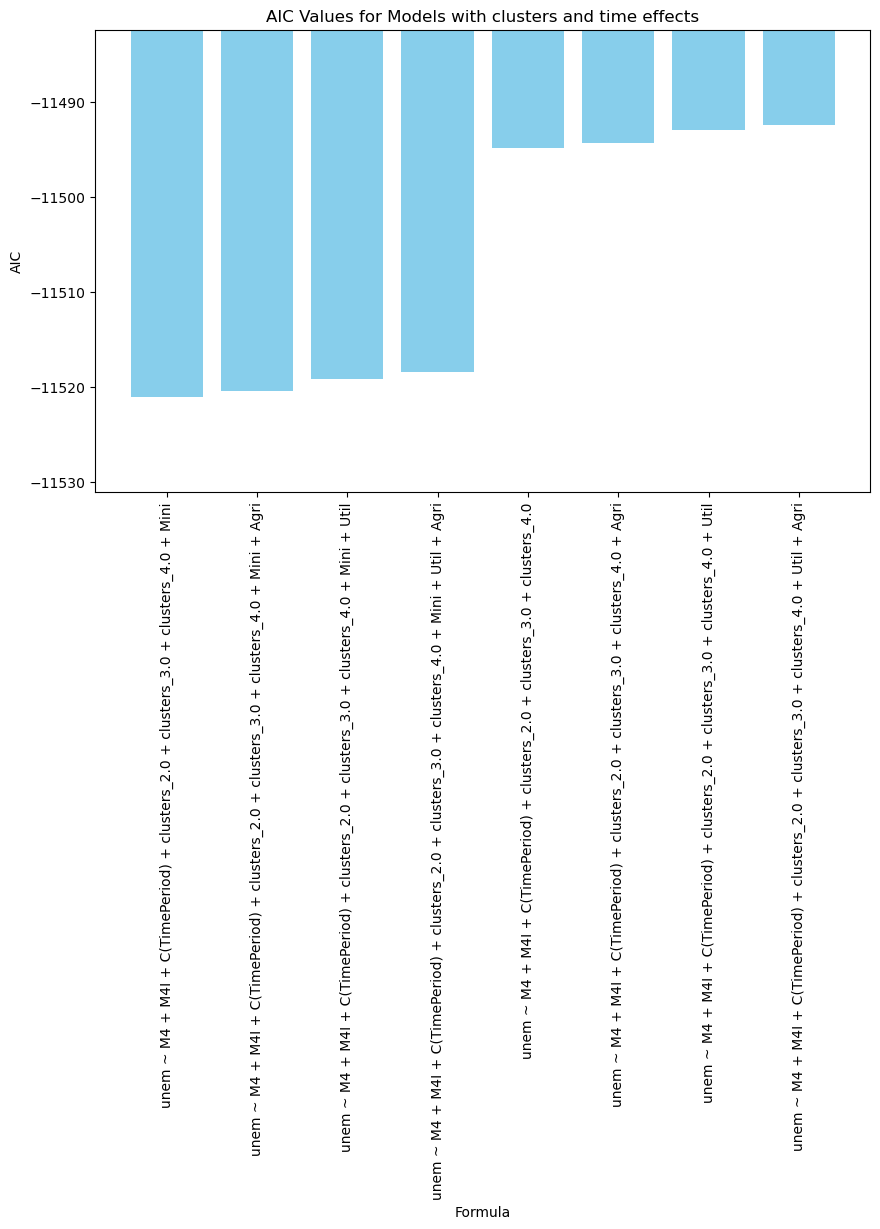

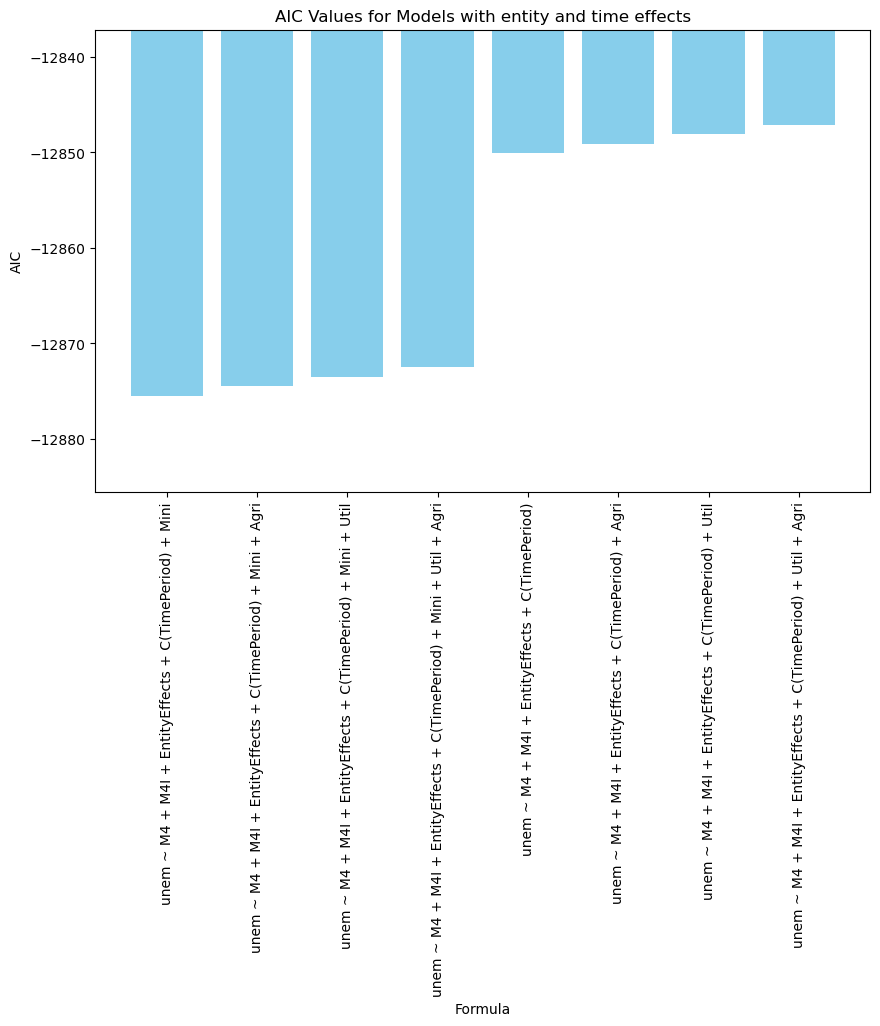

In [45]:
# Plot a bar chart for each dataframe
for key, data in formula_model_dict.items():
    plt.figure(figsize=(10, 6))
    plt.bar(data['Formula'], data['AIC'], color='skyblue')
    plt.xlabel('Formula')
    plt.ylabel('AIC')
    plt.title(f'AIC Values for {key}')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.ylim(min(data['AIC']) - 10, max(data['AIC']) + 10)
    plt.show()


Next, we move to the backward selection method and perform similar analysis as forward selection above

#### Backward Selection Method


Best model with clusters included:
                          PanelOLS Estimation Summary                           
Dep. Variable:                   unem   R-squared:                        0.2727
Estimator:                   PanelOLS   R-squared (Between):              0.3397
No. Observations:               26823   R-squared (Within):               0.2722
Date:                Wed, May 29 2024   R-squared (Overall):              0.2727
Time:                        13:32:04   Log-likelihood                -4.313e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1257.0
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                 F(8,26815)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):            

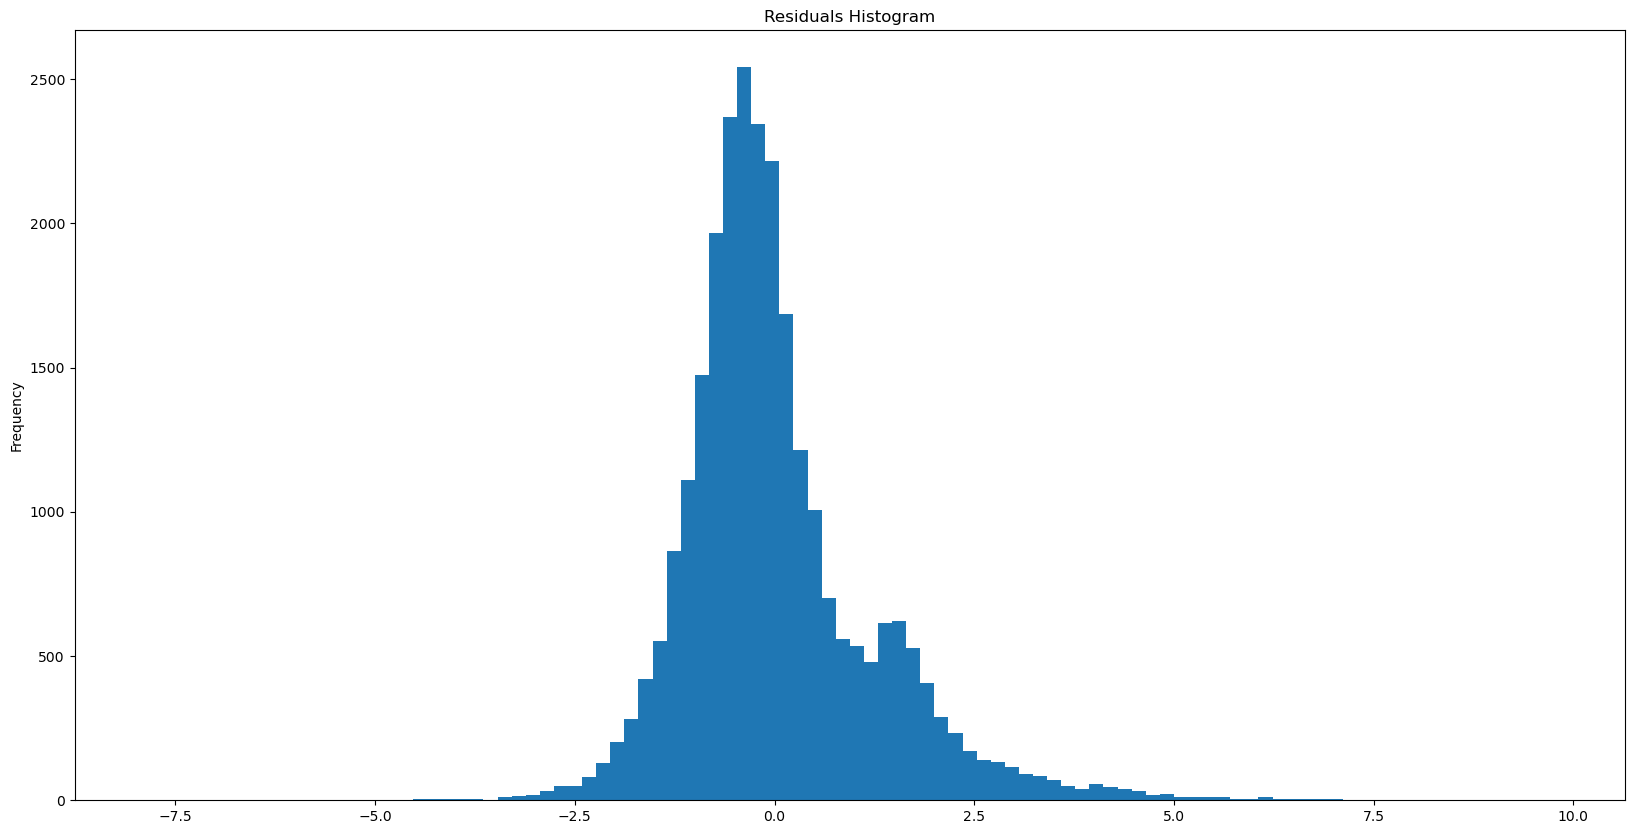

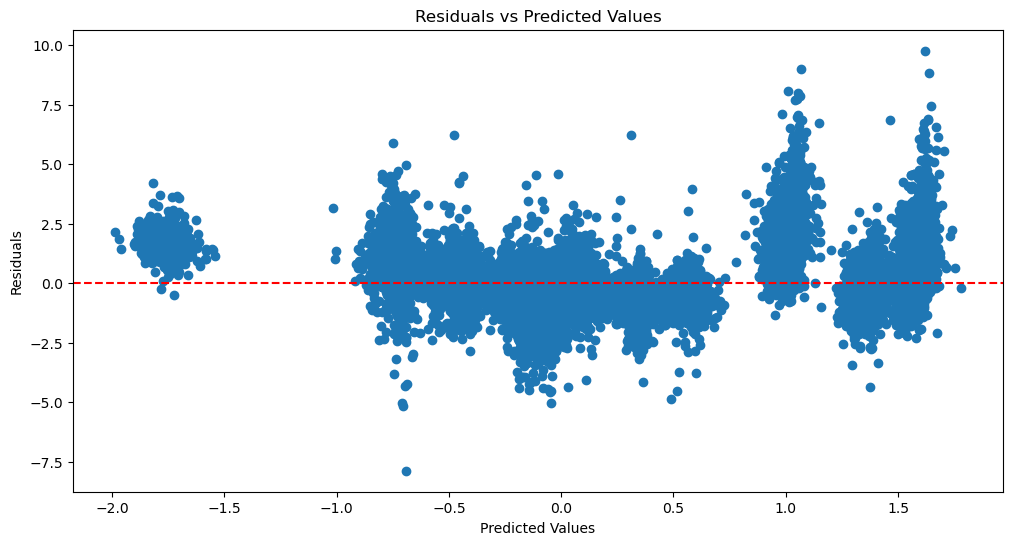

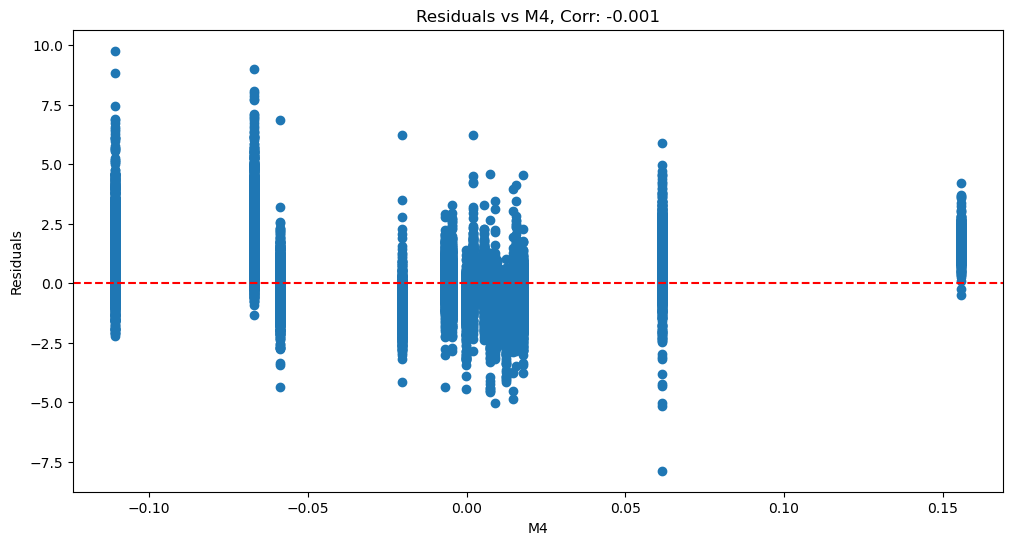

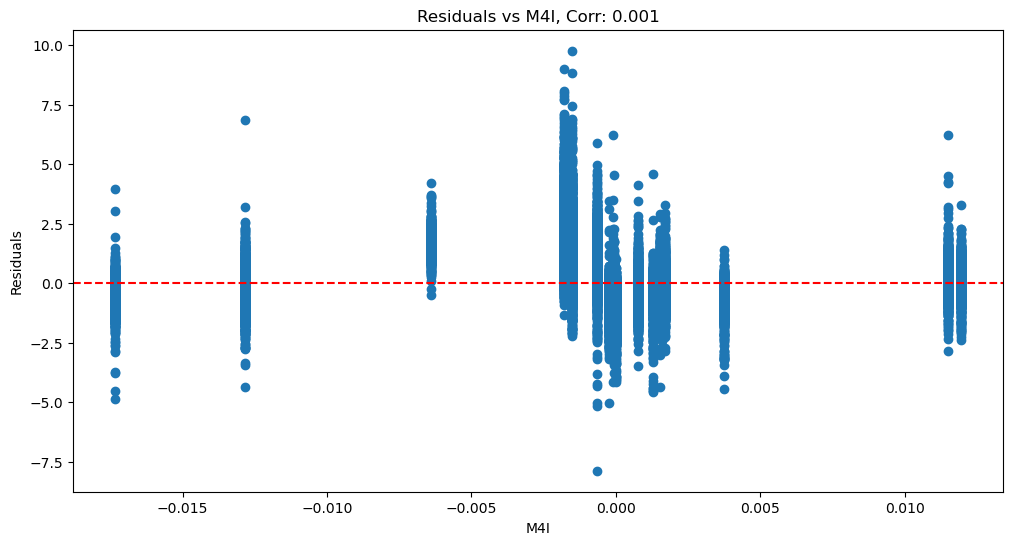

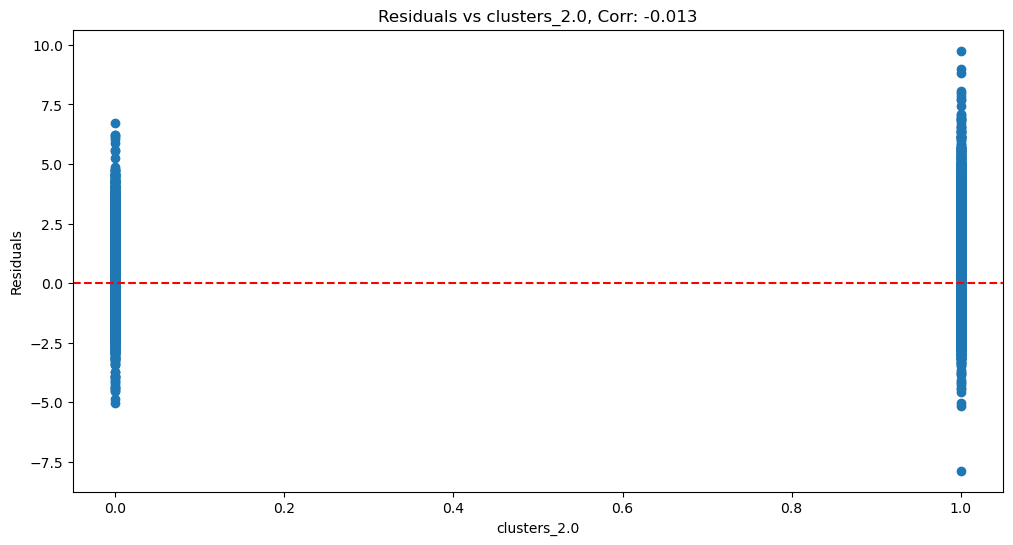

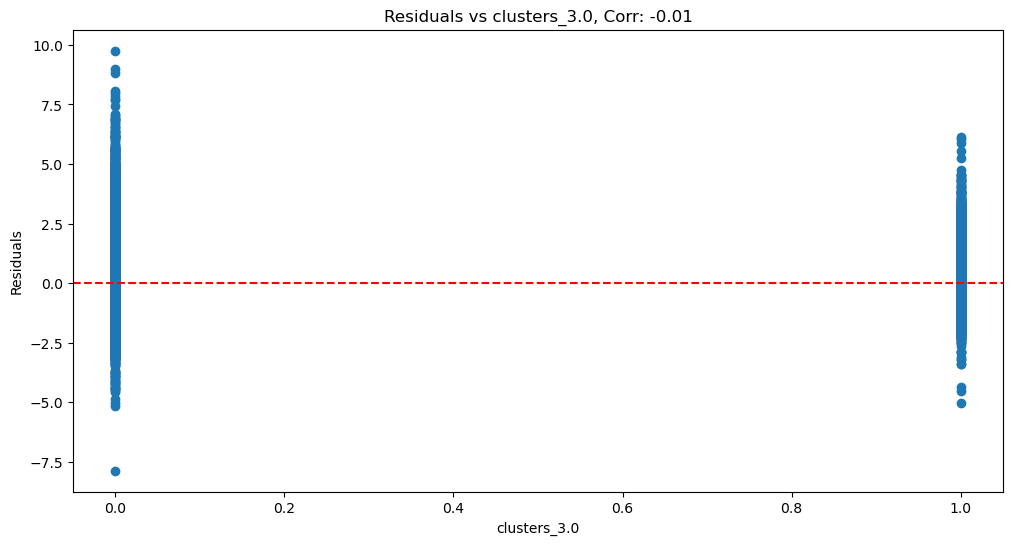

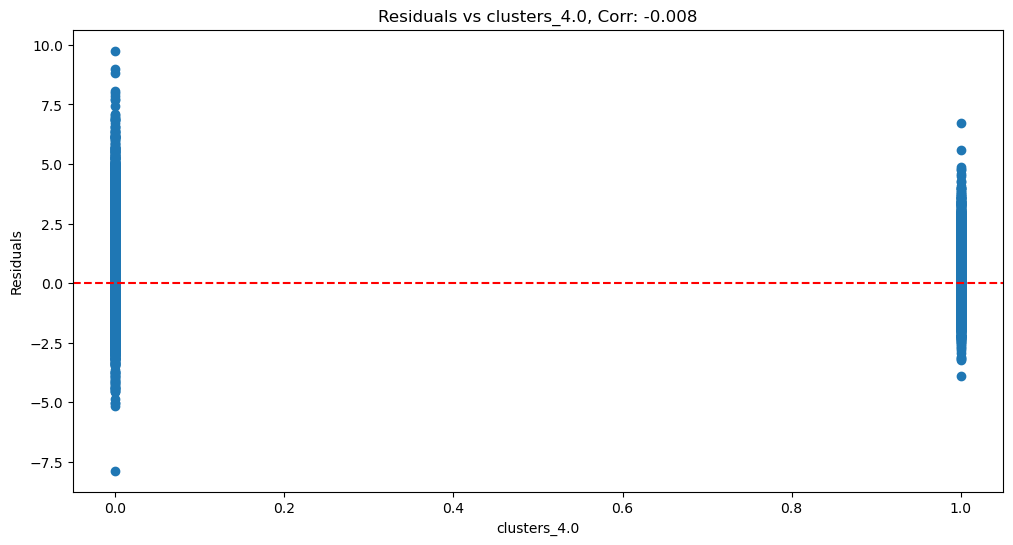

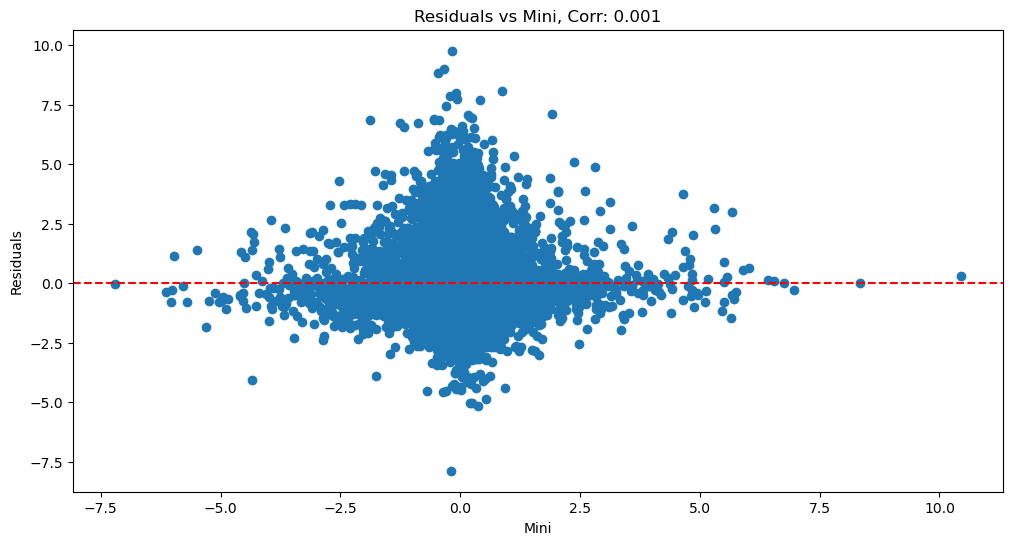

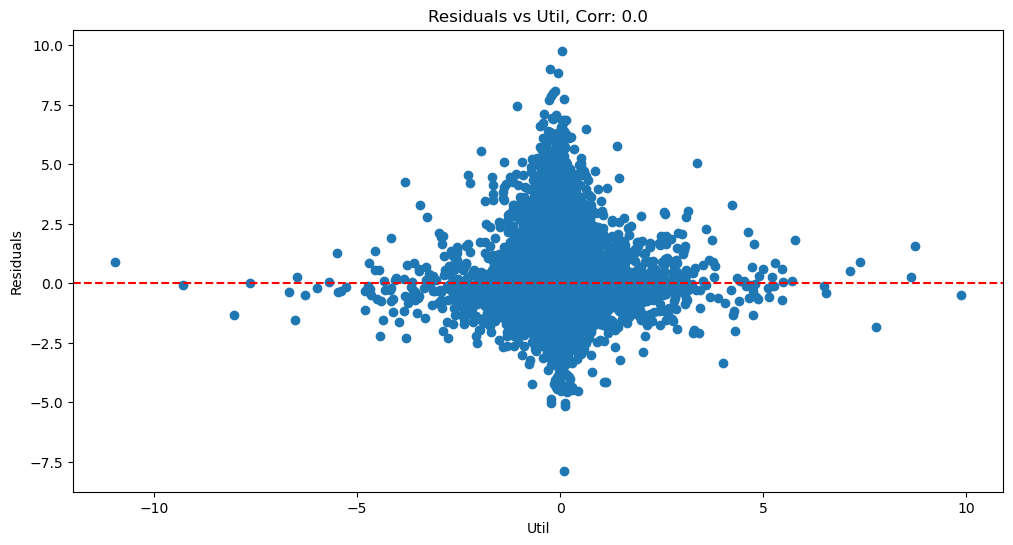

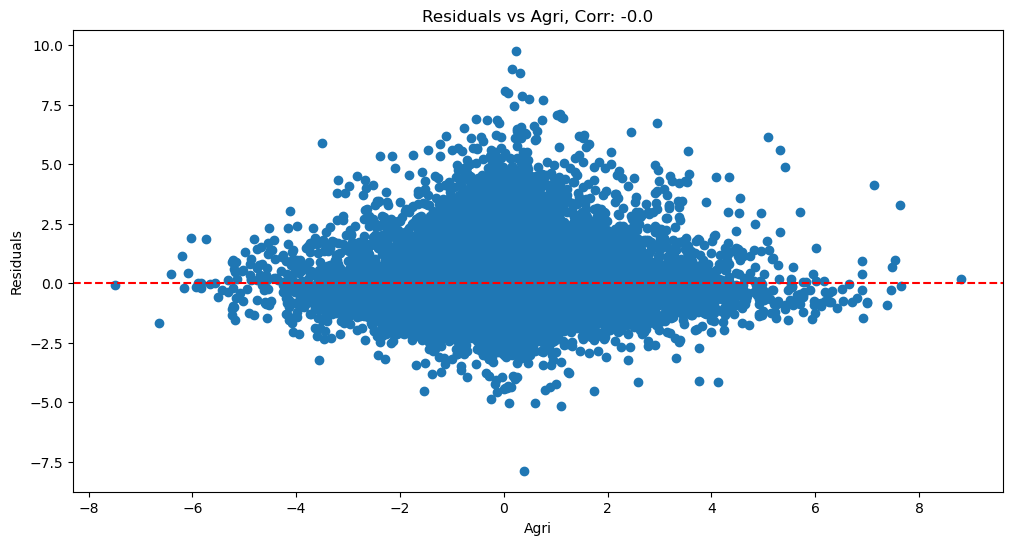

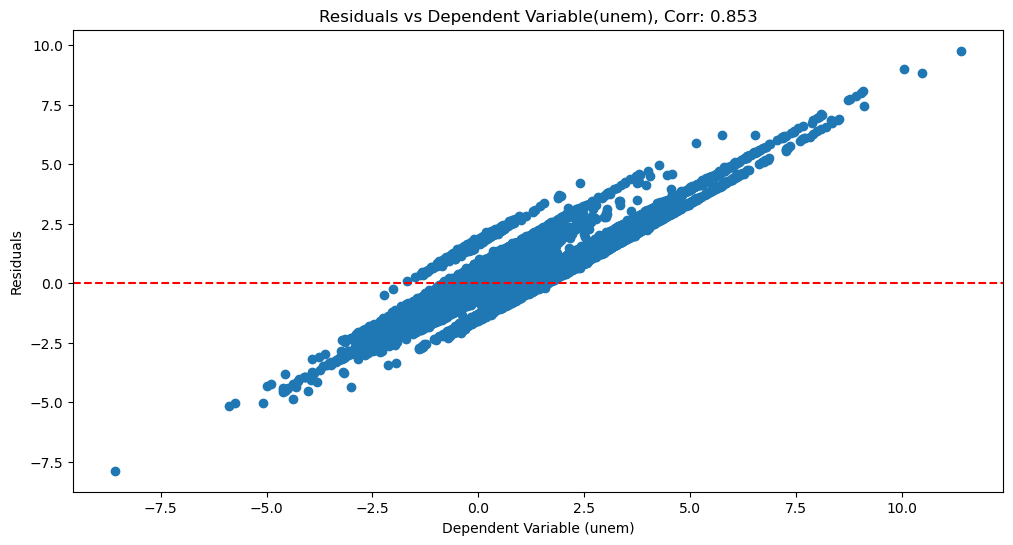


Best model with entity effects only:
                          PanelOLS Estimation Summary                           
Dep. Variable:                   unem   R-squared:                        0.2722
Estimator:                   PanelOLS   R-squared (Between):              0.3228
No. Observations:               26823   R-squared (Within):               0.2722
Date:                Wed, May 29 2024   R-squared (Overall):              0.2709
Time:                        13:32:05   Log-likelihood                -4.254e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2285.3
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                 F(4,24442)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):          

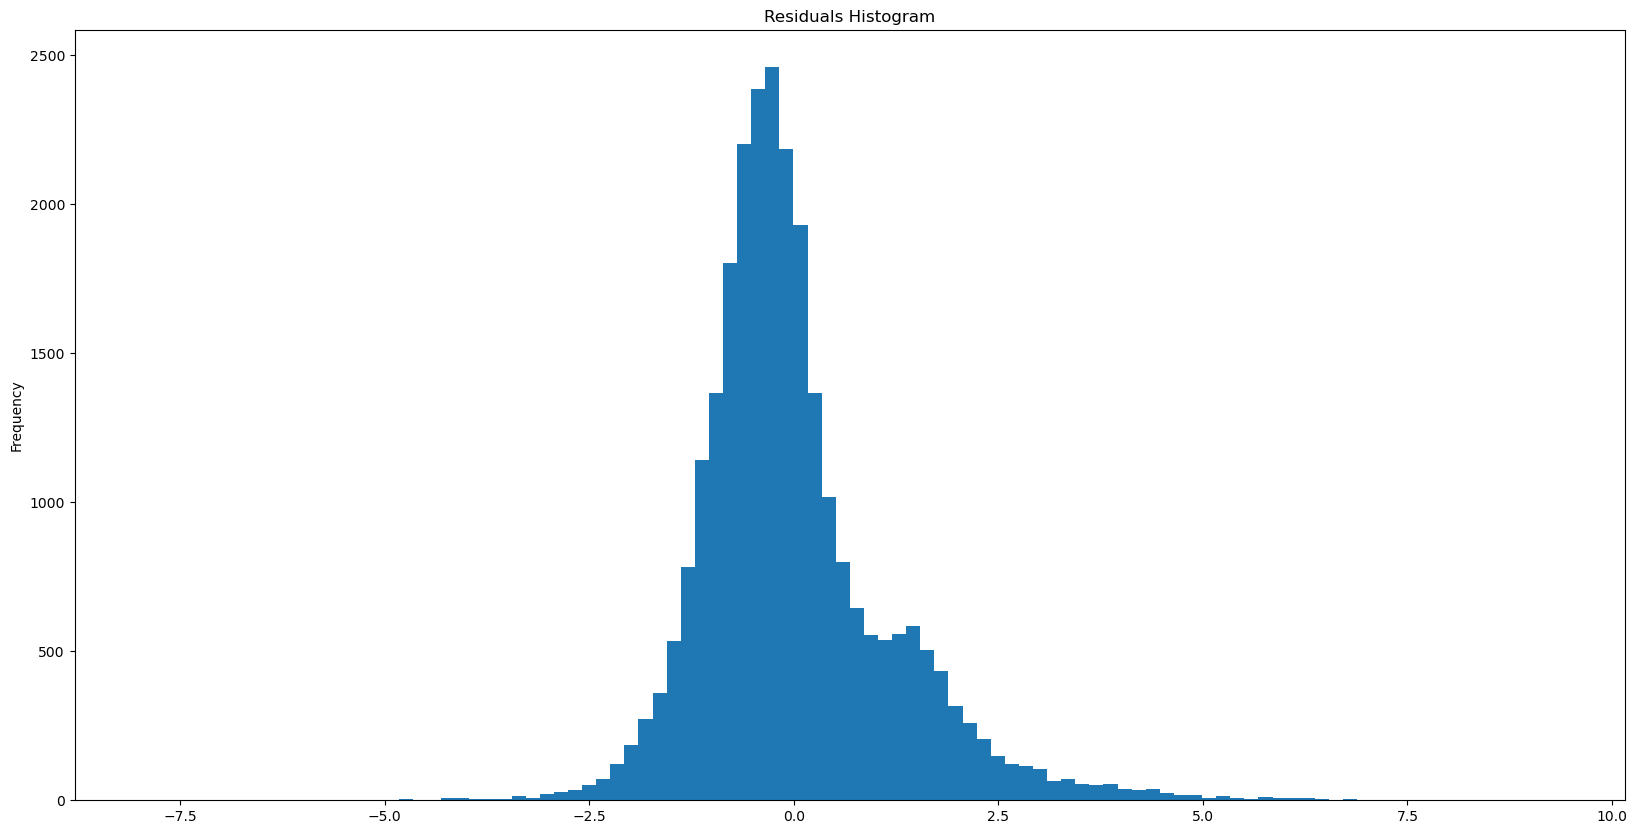

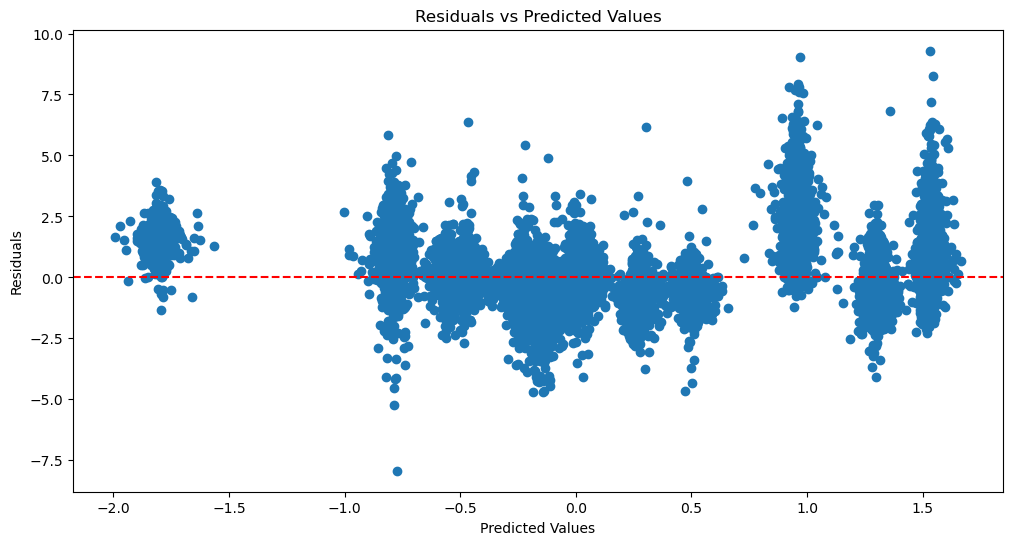

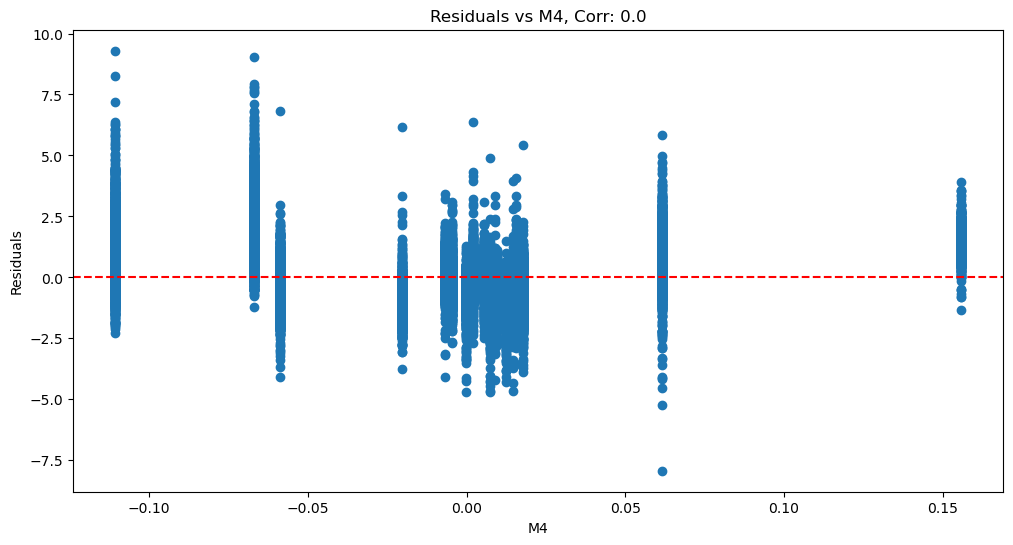

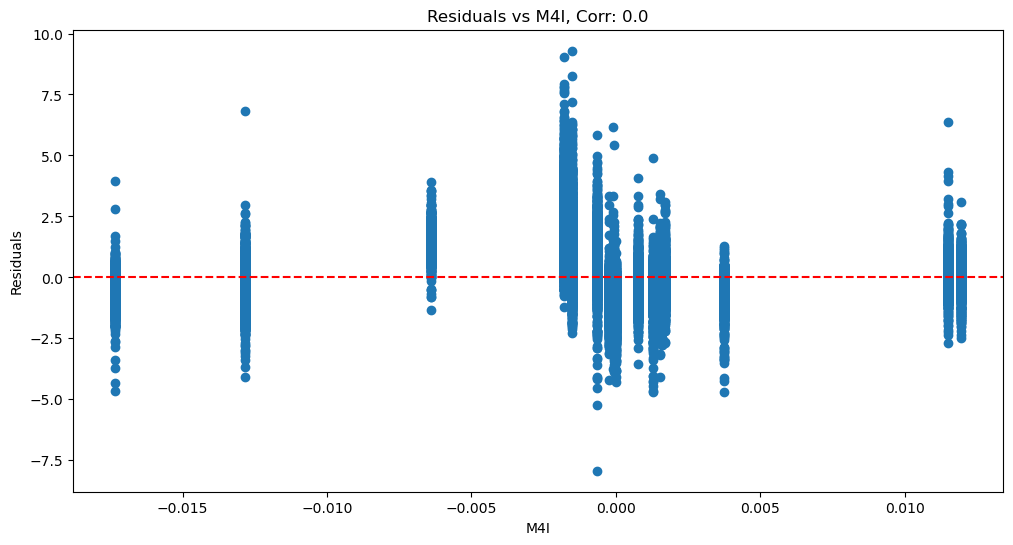

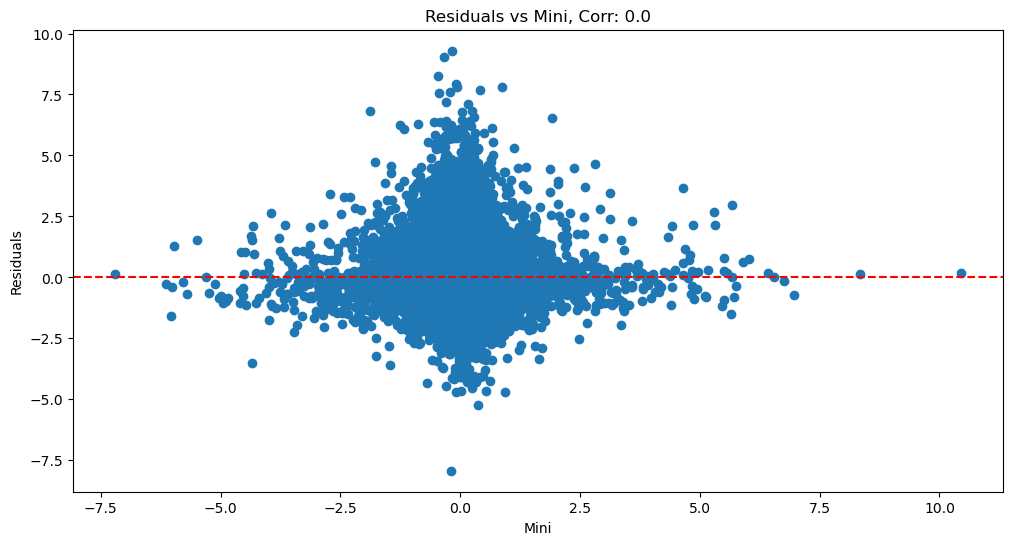

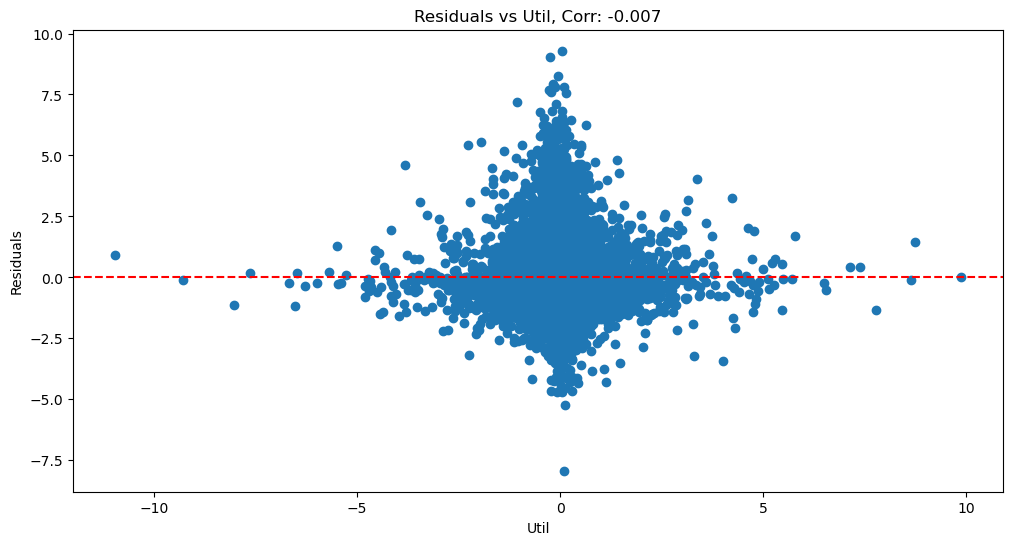

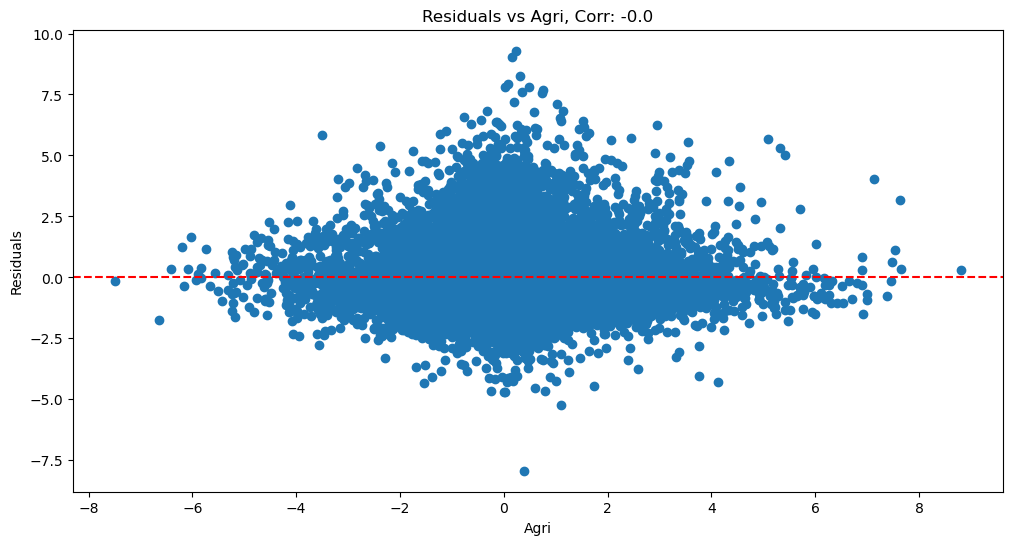

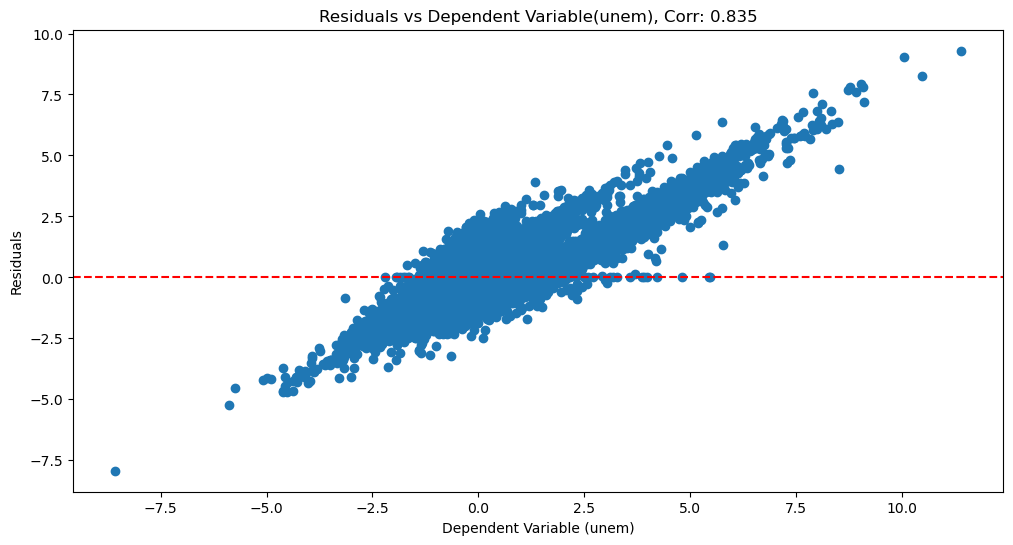


Best model with time effects only:
                          PanelOLS Estimation Summary                           
Dep. Variable:                   unem   R-squared:                        0.6762
Estimator:                   PanelOLS   R-squared (Between):              0.6775
No. Observations:               26823   R-squared (Within):               0.6779
Date:                Wed, May 29 2024   R-squared (Overall):              0.6762
Time:                        13:32:06   Log-likelihood                -3.228e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2665.1
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                F(21,26802)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):            

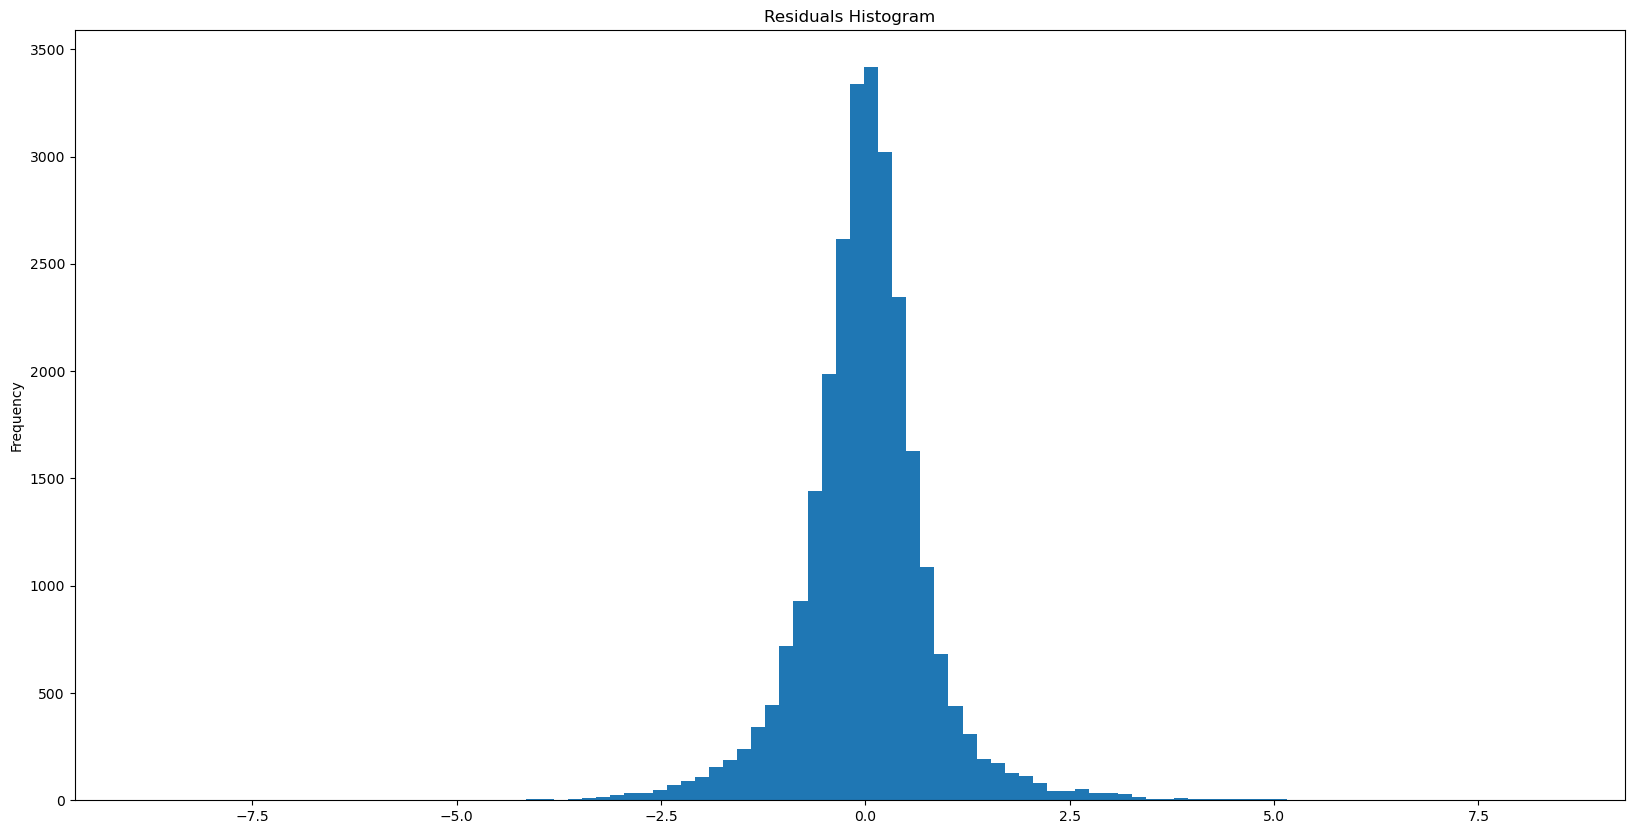

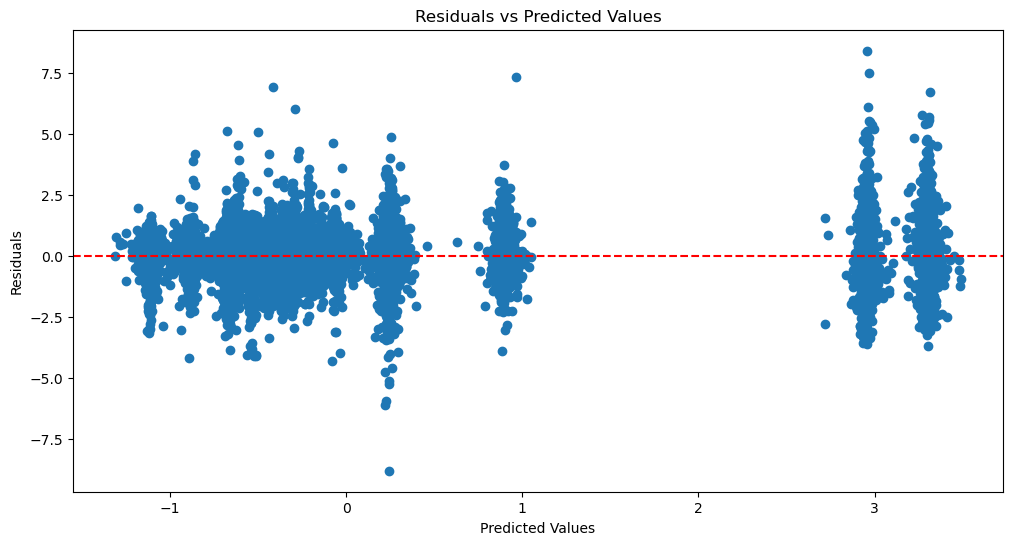

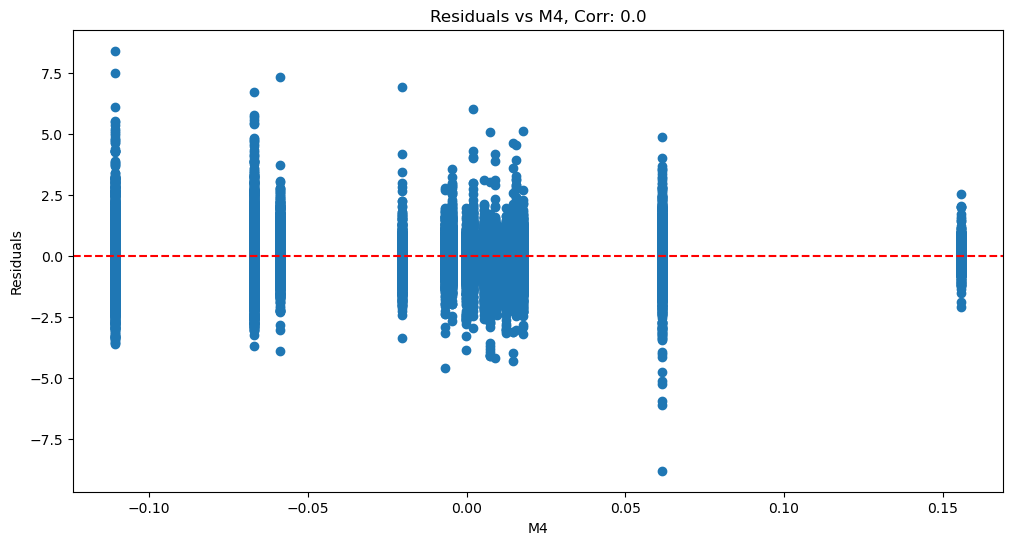

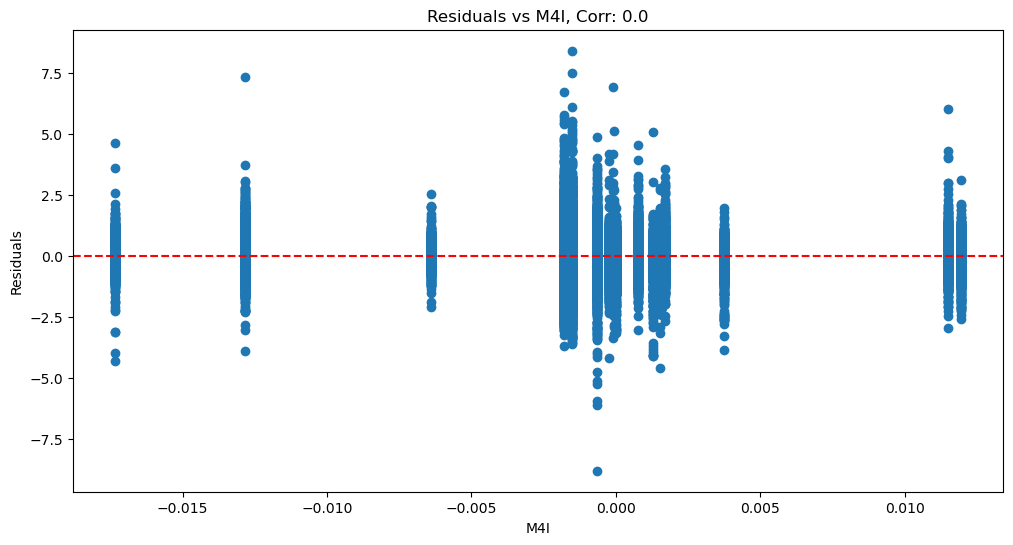

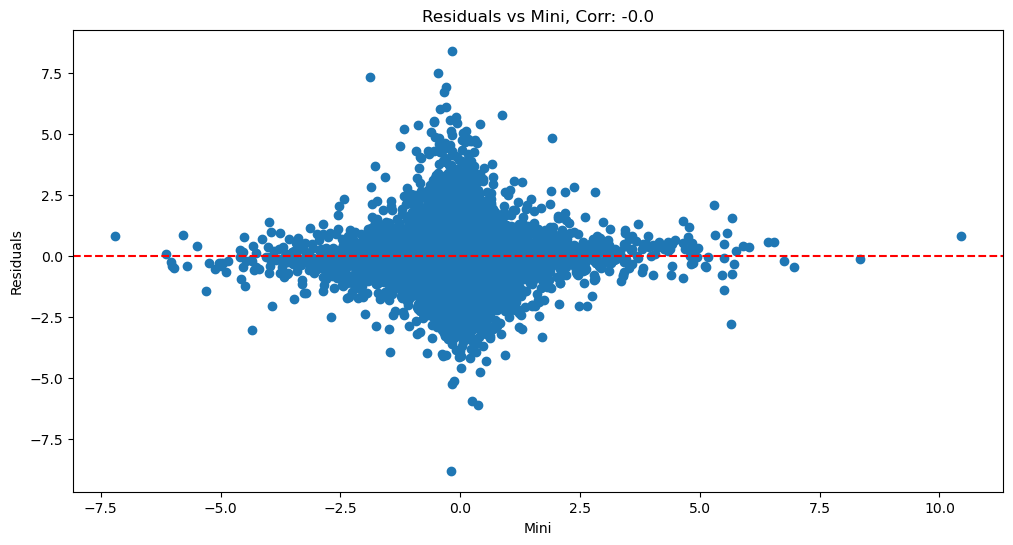

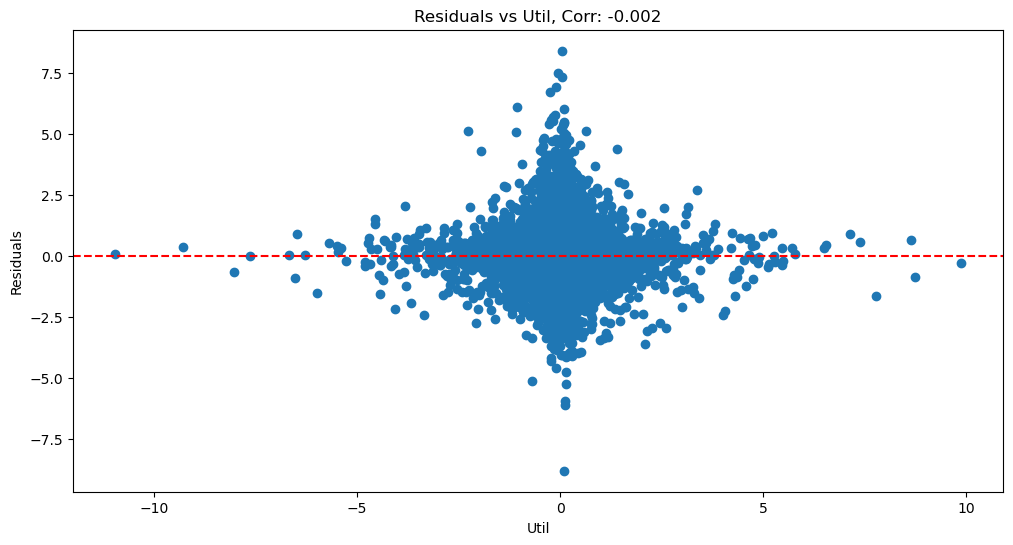

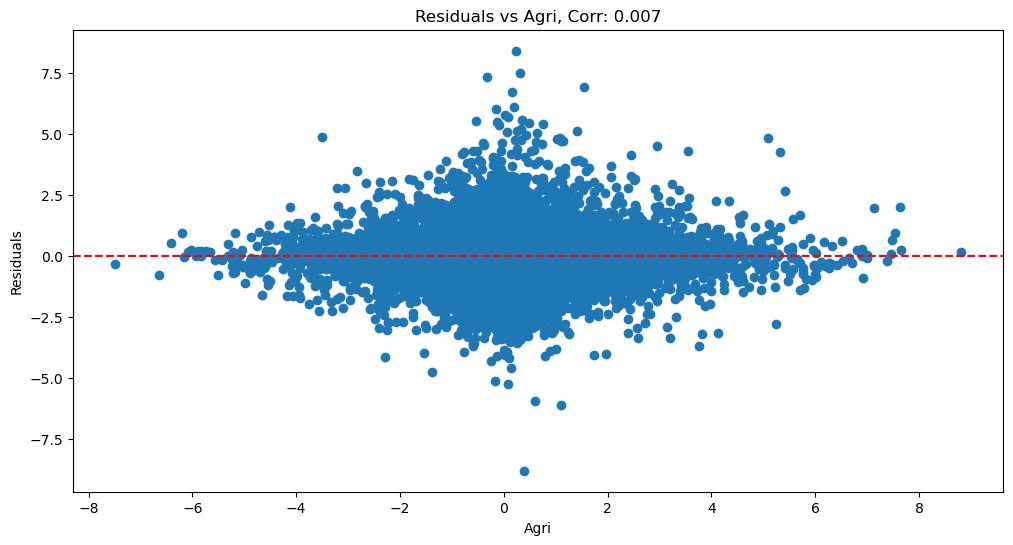

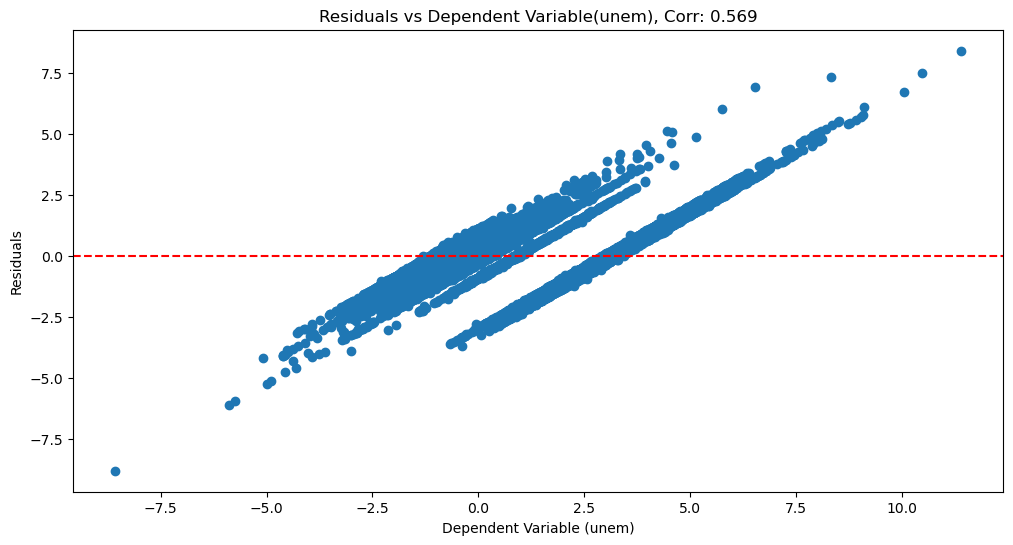


Best model with clusters and time effects:
                          PanelOLS Estimation Summary                           
Dep. Variable:                   unem   R-squared:                        0.6762
Estimator:                   PanelOLS   R-squared (Between):              0.6786
No. Observations:               26823   R-squared (Within):               0.6779
Date:                Wed, May 29 2024   R-squared (Overall):              0.6762
Time:                        13:32:07   Log-likelihood                -3.228e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2332.4
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                F(24,26799)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):    

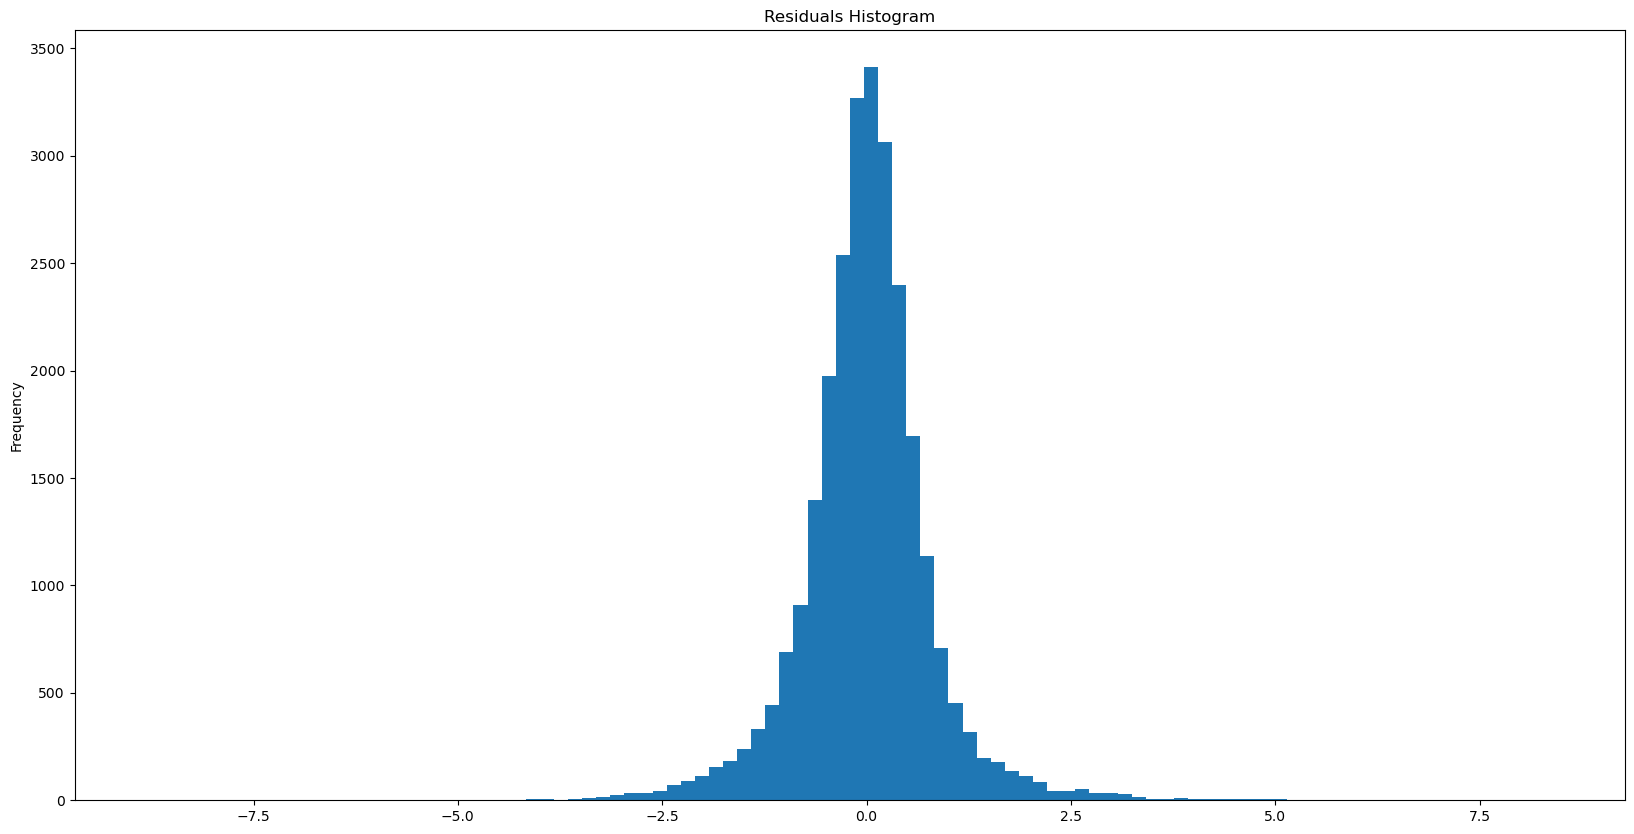

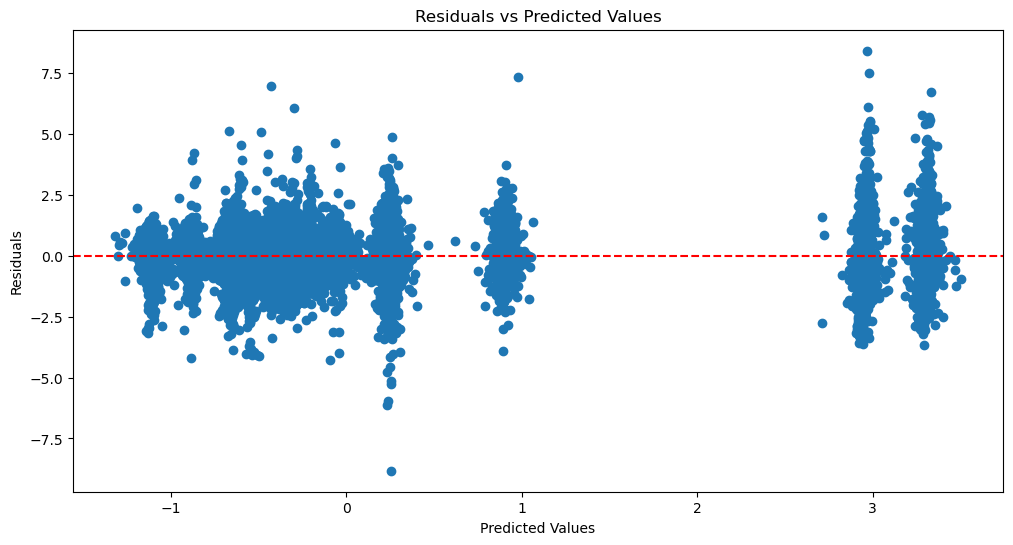

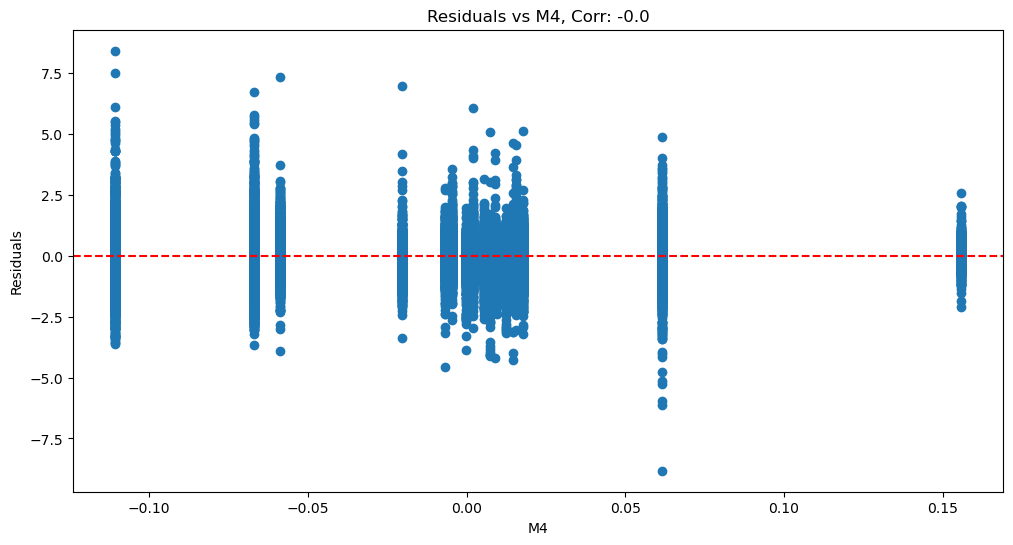

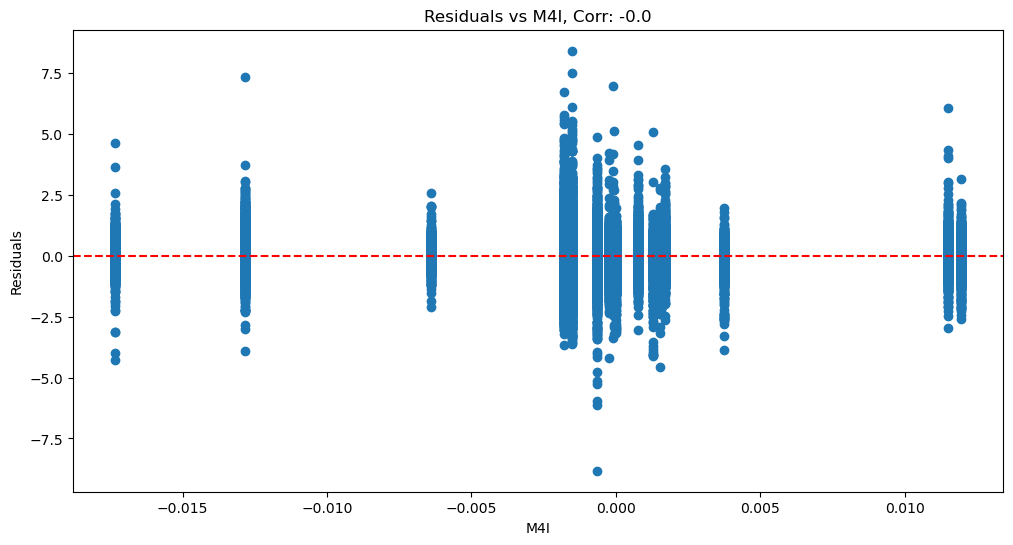

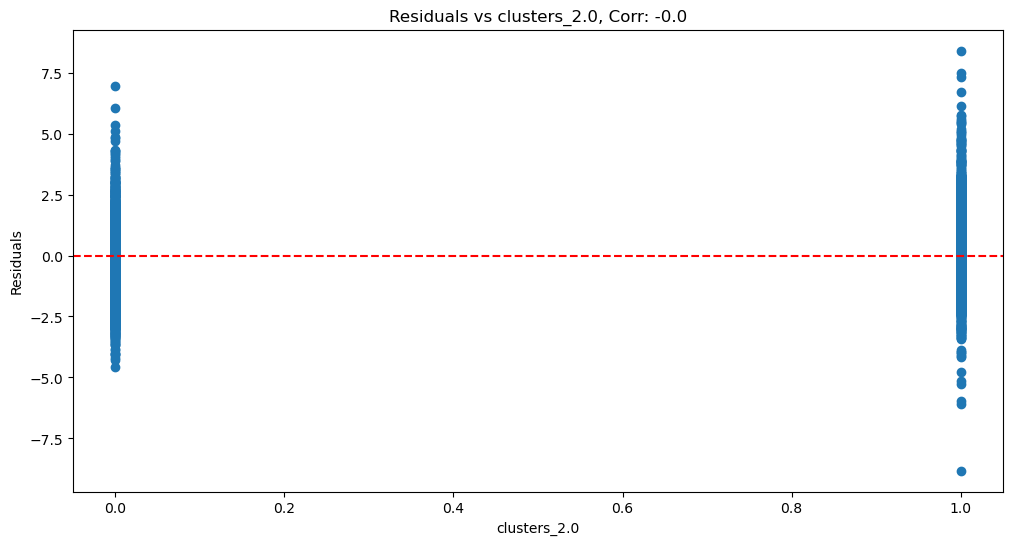

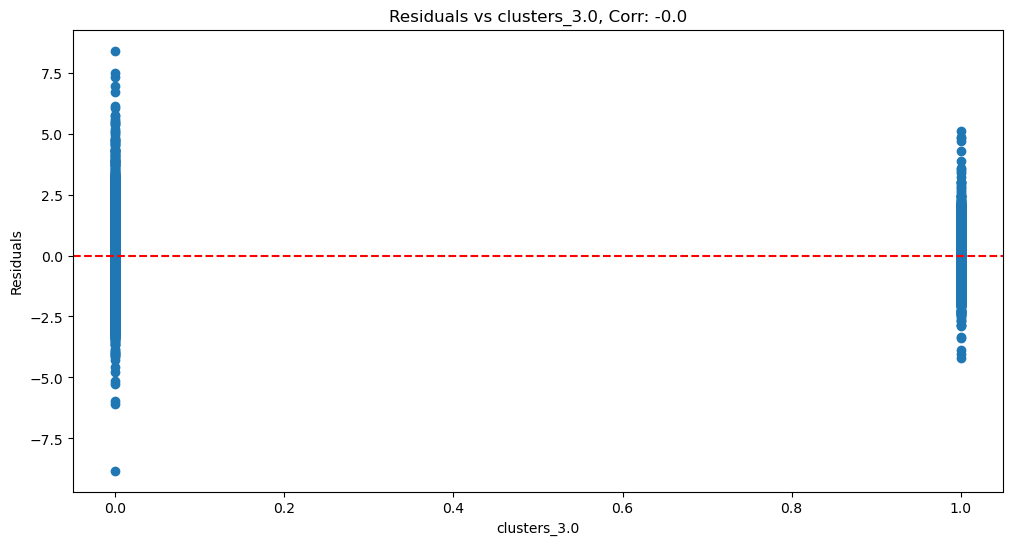

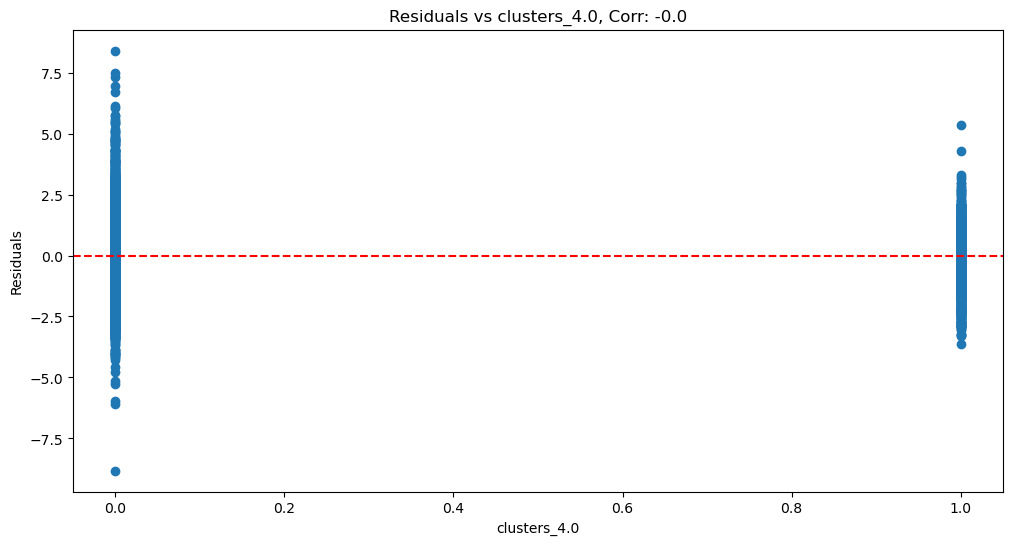

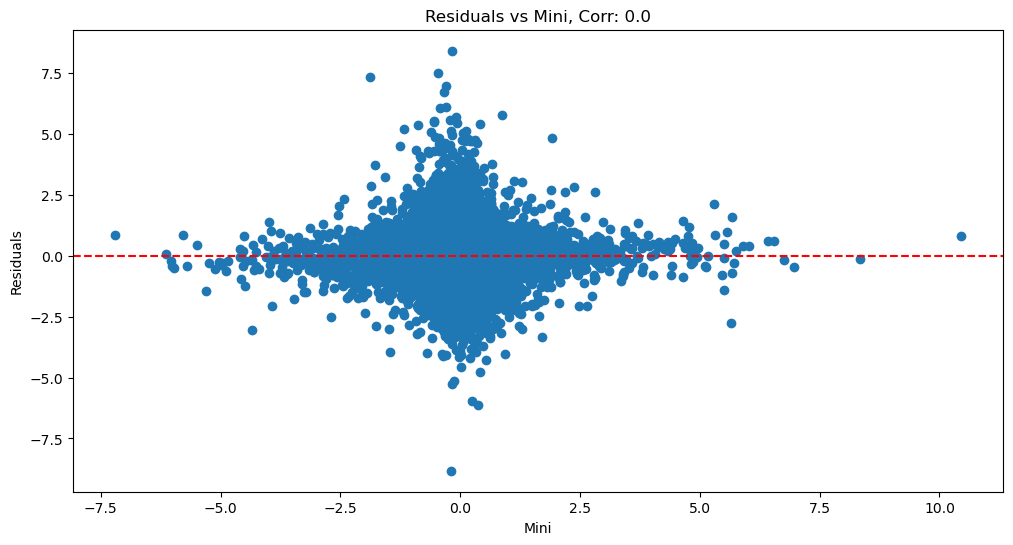

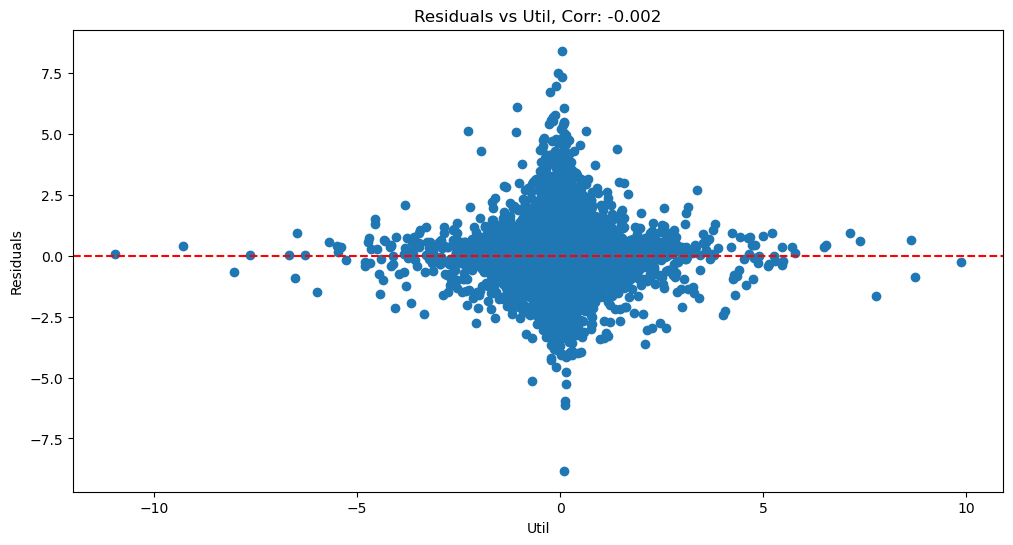

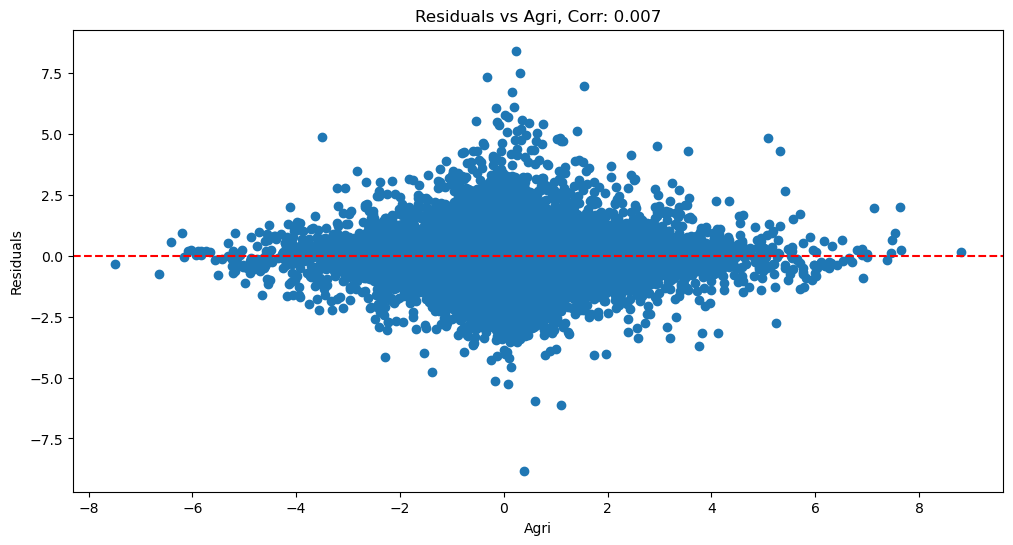

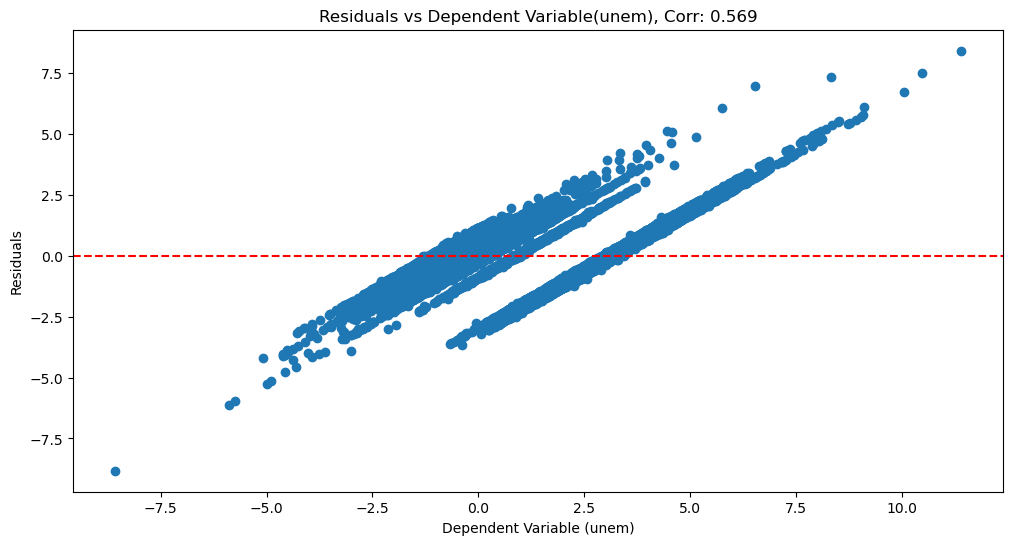


Best model with entity and time effects:
                          PanelOLS Estimation Summary                           
Dep. Variable:                   unem   R-squared:                        0.6779
Estimator:                   PanelOLS   R-squared (Between):              0.3118
No. Observations:               26823   R-squared (Within):               0.6779
Date:                Wed, May 29 2024   R-squared (Overall):              0.6219
Time:                        13:32:08   Log-likelihood                 -3.16e+04
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2856.3
Entities:                        2377   P-value                           0.0000
Avg Obs:                       11.284   Distribution:                F(18,24428)
Min Obs:                       1.0000                                           
Max Obs:                       18.000   F-statistic (robust):      

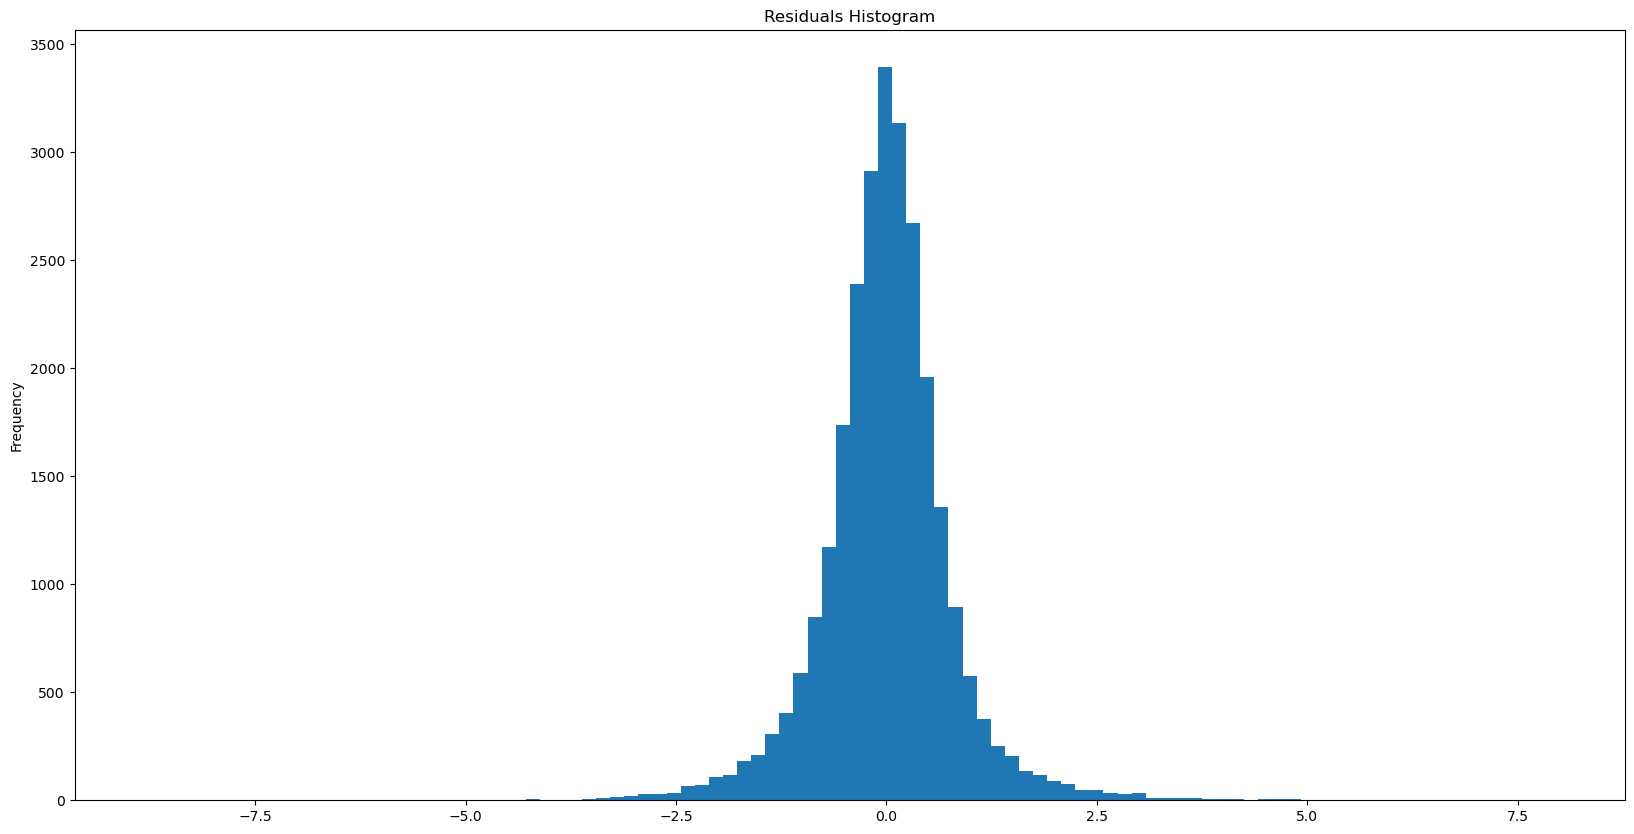

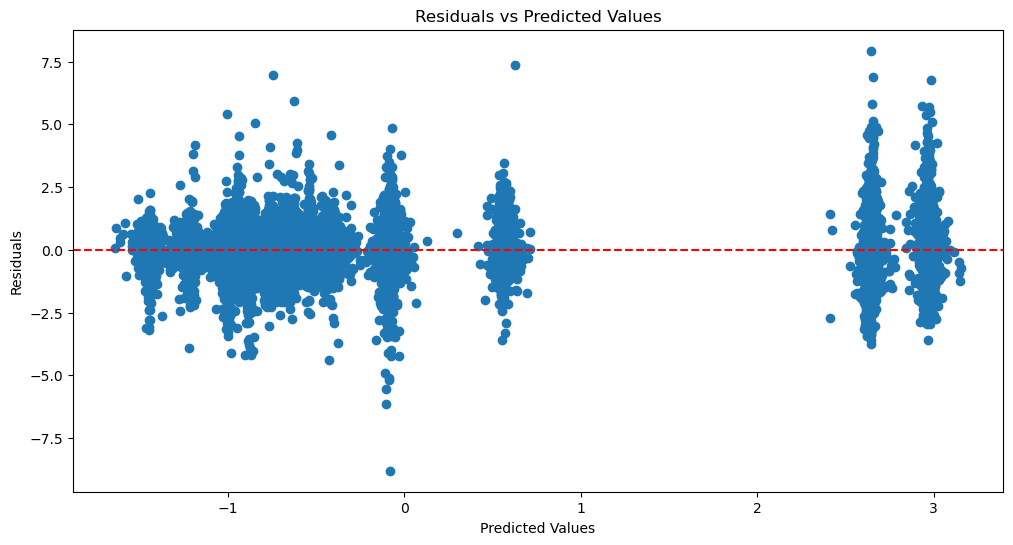

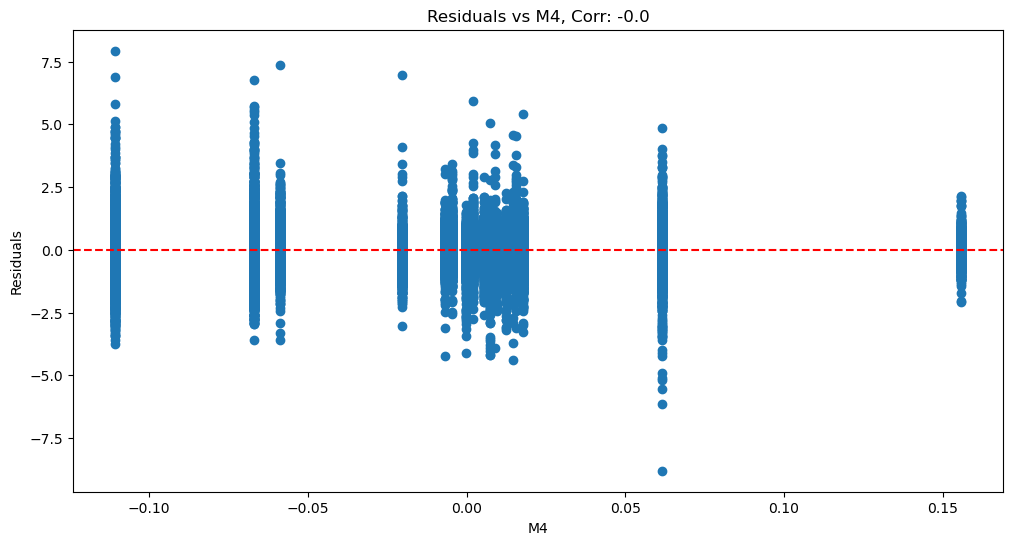

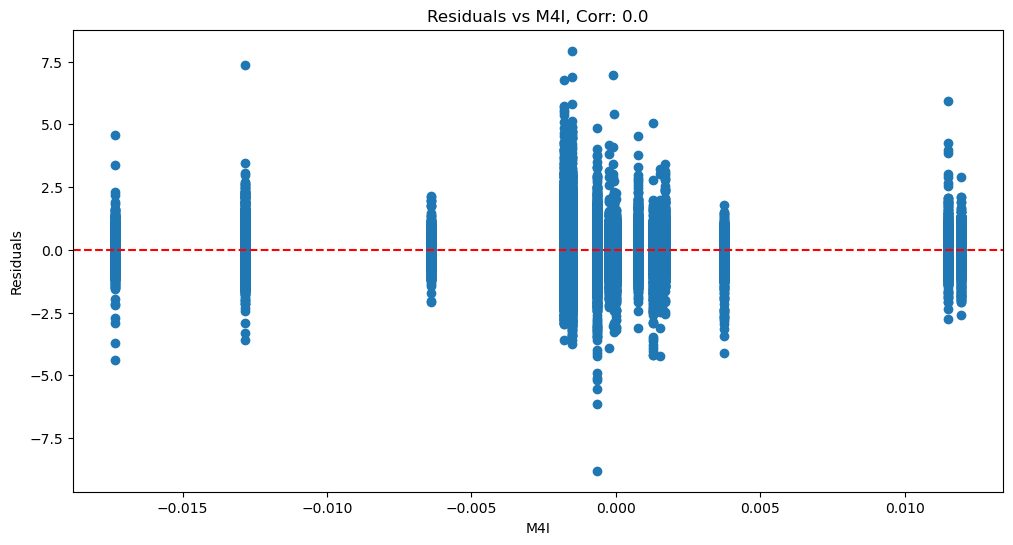

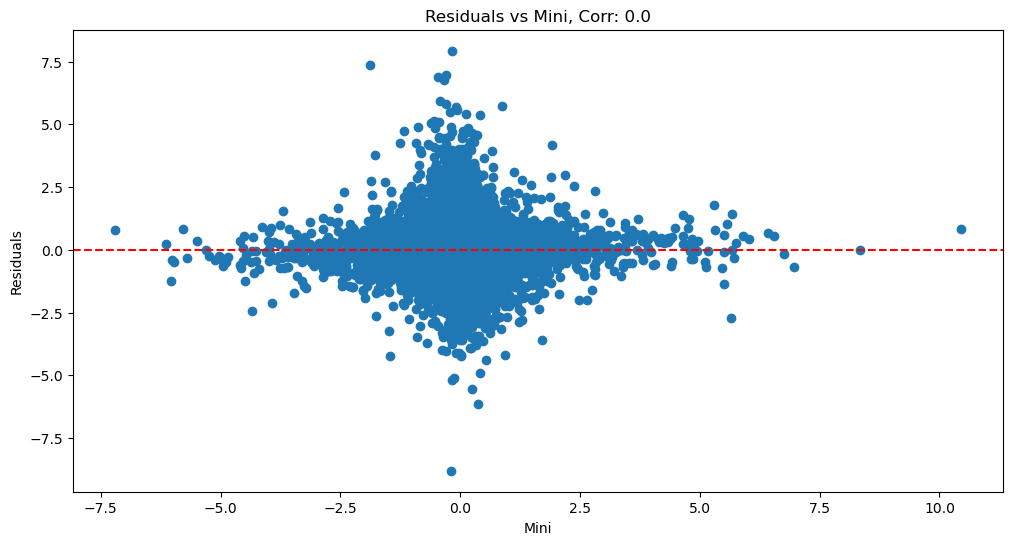

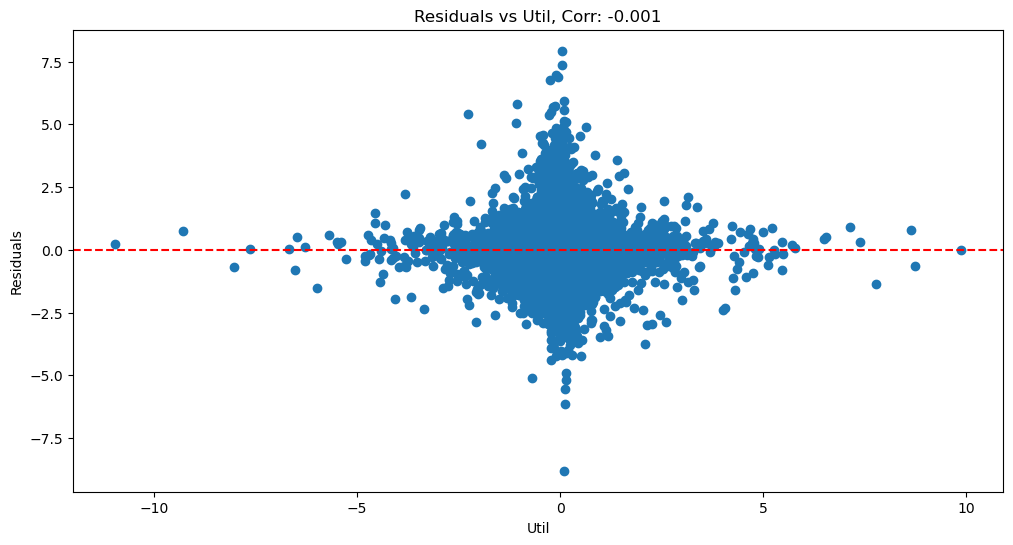

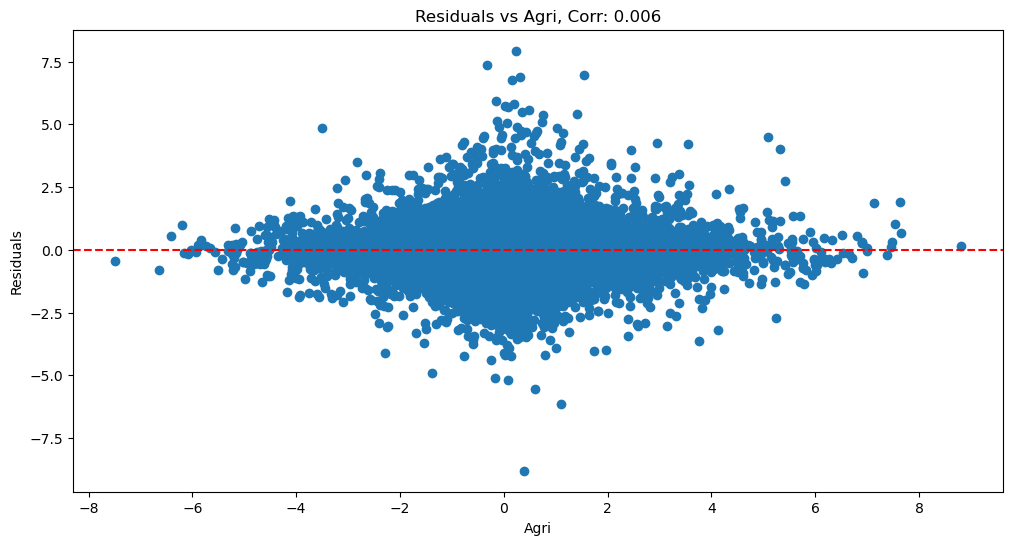

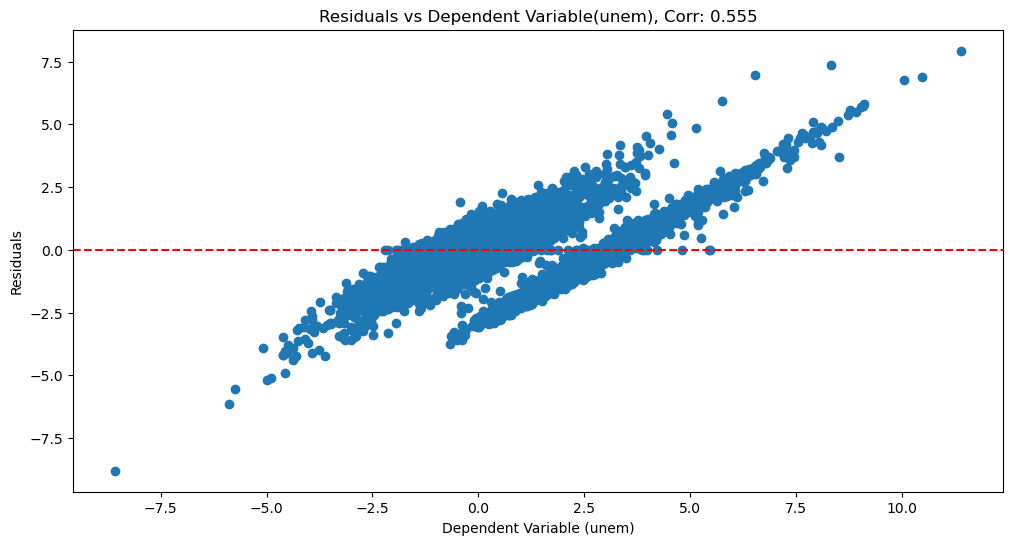

In [46]:
# Including clusters only
bw_best_model_1, bw_best_aic_1, bw_results_df_1 = backward_stepwise_selection(df, 'unem', fixed_predictors_1, potential_predictors)

# Including entity effects only
bw_best_model_2, bw_best_aic_2, bw_results_df_2 = backward_stepwise_selection(df, 'unem', fixed_predictors_2, potential_predictors)

# Including time effects only
bw_best_model_3, bw_best_aic_3, bw_results_df_3 = backward_stepwise_selection(df, 'unem', fixed_predictors_3, potential_predictors)

# Including cluster and time effects
bw_best_model_4, bw_best_aic_4, bw_results_df_4 = backward_stepwise_selection(df, 'unem', fixed_predictors_4, potential_predictors)

# Including entity and time effects
bw_best_model_5, bw_best_aic_5, bw_results_df_5 = backward_stepwise_selection(df, 'unem', fixed_predictors_5, potential_predictors)


# Fit the best models and get their summaries
best_models_bw = [bw_best_model_1, bw_best_model_2, bw_best_model_3, bw_best_model_4, bw_best_model_5]
fixed_predictors_list = [fixed_predictors_1, fixed_predictors_2, fixed_predictors_3, 
                         fixed_predictors_4, fixed_predictors_5]

model_names = ['Best model with clusters included', 
               'Best model with entity effects only',
               'Best model with time effects only',
               'Best model with clusters and time effects',
               'Best model with entity and time effects']

backward_formula_model_dict = {
    'Models with cluster included': bw_results_df_1,
    'Models with entity effects only': bw_results_df_2,
    'Models with time effects only': bw_results_df_3,
    'Models with clusters and time effects': bw_results_df_4,
    'Models with entity and time effects': bw_results_df_5}


for i, best_model in enumerate(best_models_bw):
    print(f'\n{model_names[i]}:')
#     print(f'\nBest model (case {i+1}):')
    results_bw = get_model_summary(best_model, df, 'PanelOLS')
    print(results_bw.summary)

    # Plot the regression diagnostics
    plot_residuals_vs_predicted(results_bw, df)
    plot_residuals_vs_independent_vars(results_bw, df, fixed_predictors_list[i], potential_predictors)
    plot_residuals_vs_dependent_var(results_bw, df)


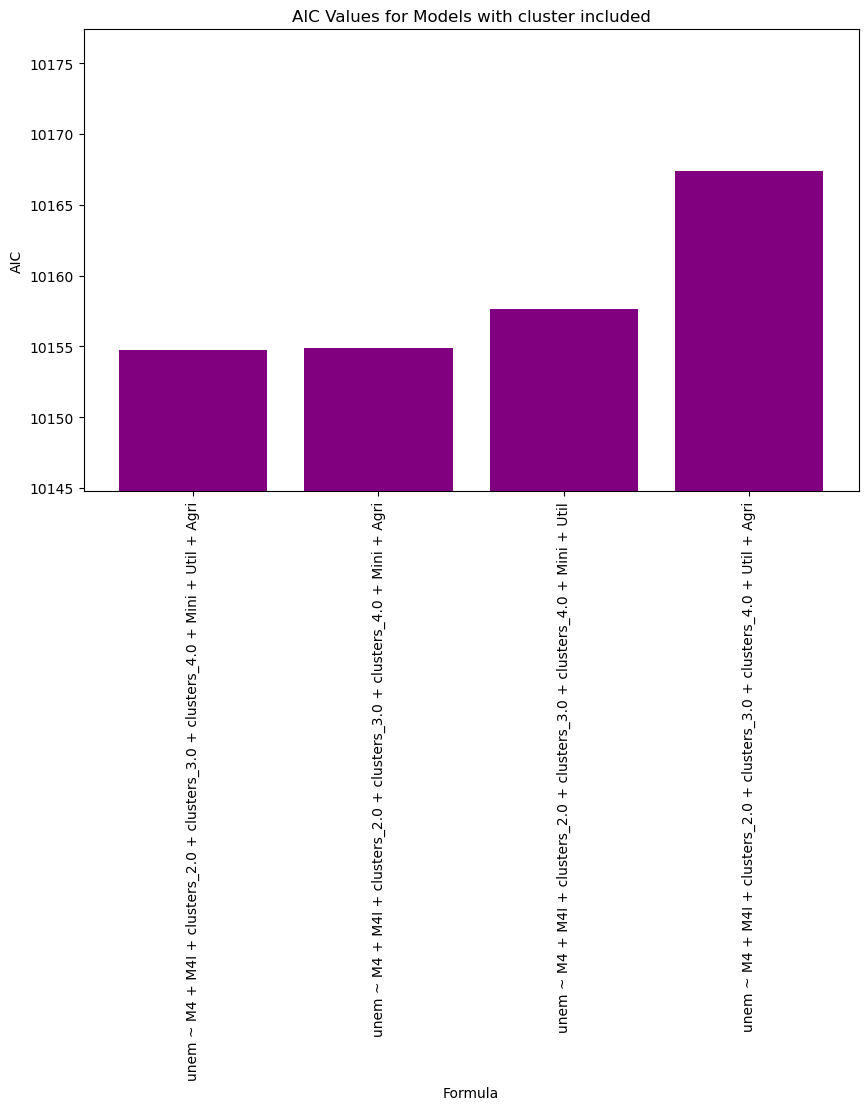

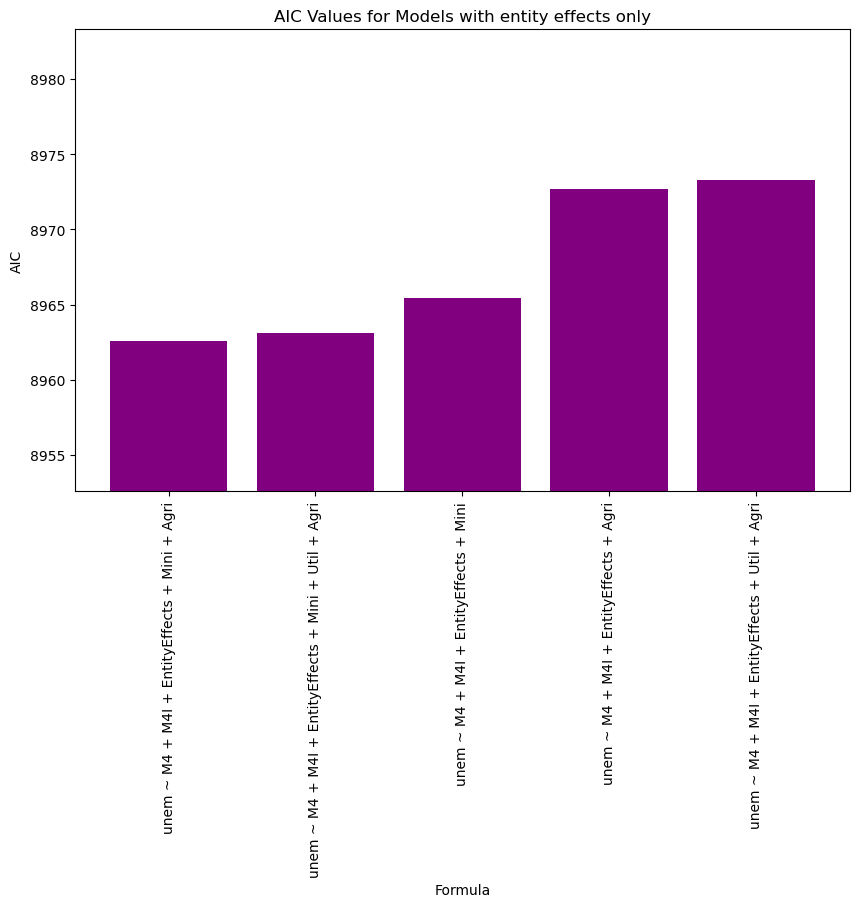

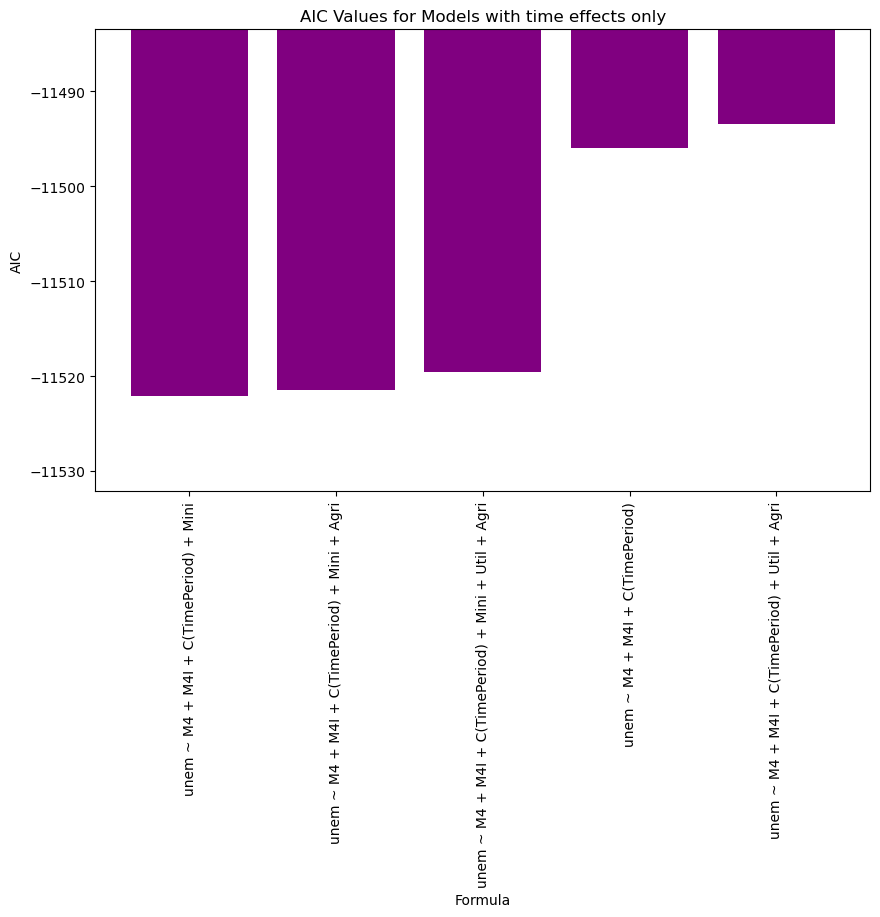

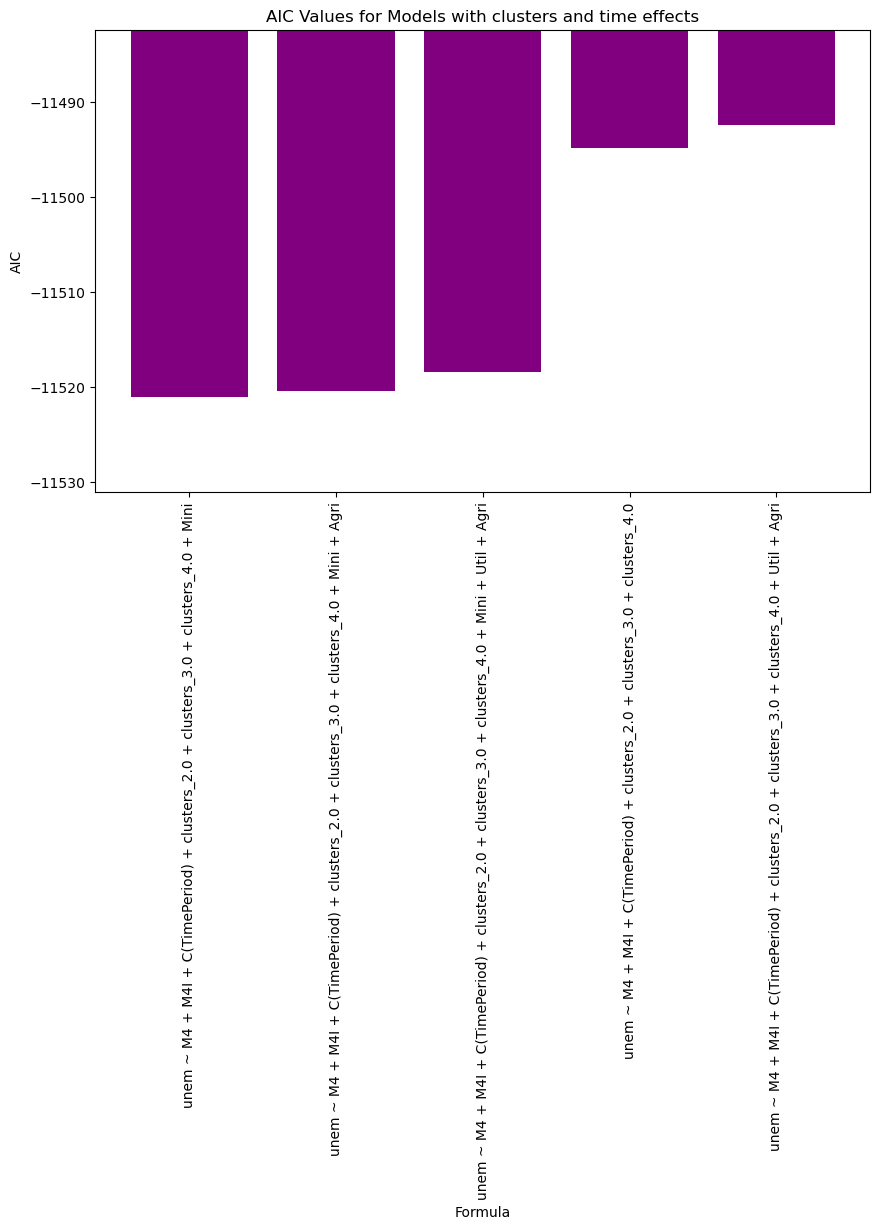

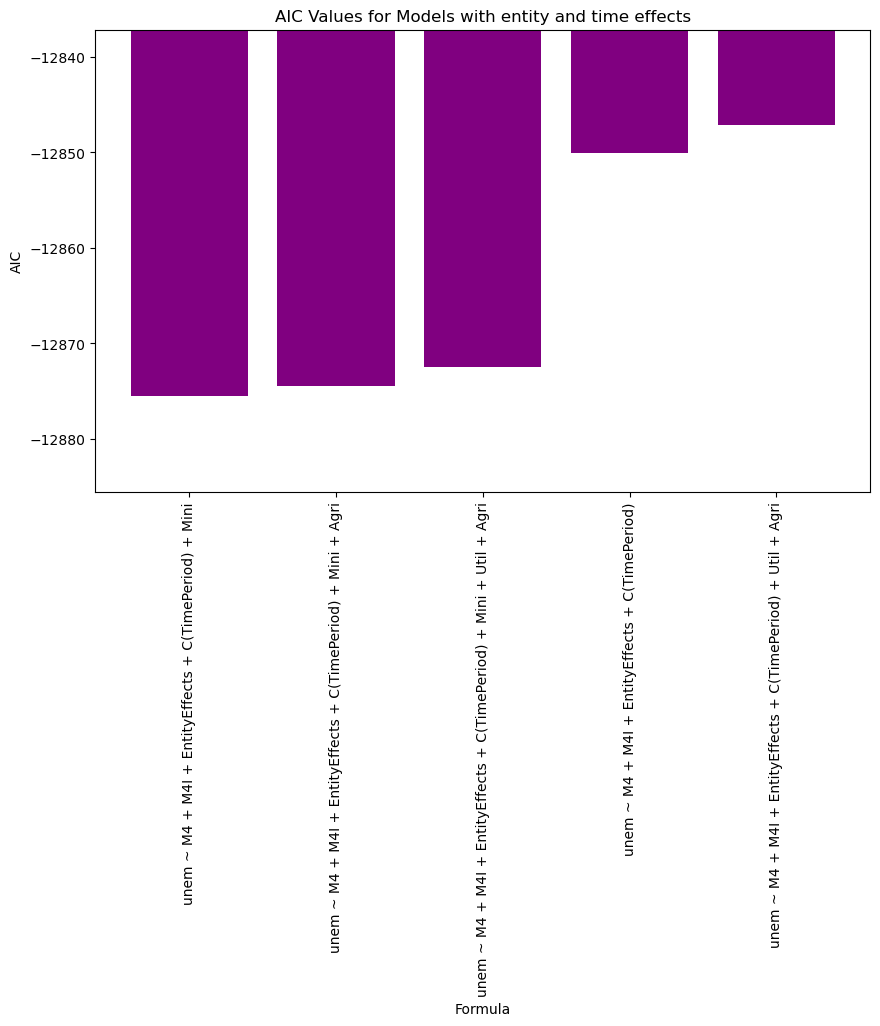

In [47]:
# Plot a bar chart for each dataframe
for key, data_bw in backward_formula_model_dict.items():
    plt.figure(figsize=(10, 6))
    plt.bar(data_bw['Formula'], data_bw['AIC'], color='purple')
    plt.xlabel('Formula')
    plt.ylabel('AIC')
    plt.title(f'AIC Values for {key}')
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.ylim(min(data_bw['AIC']) - 10, max(data_bw['AIC']) + 10)
    plt.show()


Now we compare the summary of the models side by side for ease of comparison, including the pooled OLS regression

In [48]:
# Store the summaries
summaries_bw = {model_name: get_model_summary(model, df, 'PanelOLS') for model_name, model in zip(model_names, best_models_bw)}
summaries_bw['Pooled model'] = results_pooled

comparison_bw = compare(summaries_bw)

comparison_bw

Model Comparison                                                                                                         
==================================================================================================================================================================================================================================
                          Best model with clusters included Best model with entity effects only Best model with time effects only Best model with clusters and time effects Best model with entity and time effects   Pooled model
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable                                          unem                                unem                              unem                                      unem                                    unem           unem
Estimator                                          PanelOLS                            PanelOLS                          PanelOLS                                  PanelOLS                                PanelOLS      PooledOLS
No. Observations                                      26823                               26823                             26823                                     26823                                   26823          26823
Cov. Est.                                        Unadjusted                          Unadjusted                        Unadjusted                                Unadjusted                              Unadjusted     Unadjusted
R-squared                                            0.2727                              0.2722                            0.6762                                    0.6762                                  0.6779         0.2727
R-Squared (Within)                                   0.2722                              0.2722                            0.6779                                    0.6779                                  0.6779         0.2722
R-Squared (Between)                                  0.3397                              0.3228                            0.6775                                    0.6786                                  0.3118         0.3397
R-Squared (Overall)                                  0.2727                              0.2709                            0.6762                                    0.6762                                  0.6219         0.2727
F-statistic                                          1257.0                              2285.3                            2665.1                                    2332.4                                  2856.3         1257.0
P-value (F-stat)                                     0.0000                              0.0000                            0.0000                                    0.0000                                  0.0000         0.0000
=======================                        ============                        ============                    ==============                            ==============                            ============   ============
M4                                                  -13.233                             -13.199                           -0.6228                                   -0.6232                                 -18.606        -13.233
                                                  (-92.813)                           (-89.415)                      (-4.561e-08)                              (-4.565e-08)                               (-121.74)      (-92.813)
M4I                                                 -40.668                             -39.704                           -0.0318                                   -0.0317                                 -380.96        -40.668
                   

The forward and backward selection methods both arrive at similar results (i.e, formula) for best models.

### Takeaways

The best results/model after all combinations and various model types appears to be the inclusion of clusters as a dummy in the panelOLS without any effects. There appears to be perfect collinearity when time effects are included in the models and this can be observed as all the p-values were highly insignificant. TimePeriod appears to be problematic, when it is included in the models, only mining is significant. Including time effects and clusters also results in only the second cluster and mining being significant. When entity and time effects are included in the model, agriculture and utilities are omitted in the results. The best result remains the exclusion of entities (entity and time) and the inclusion of clusters as dummies.

The results are consistent with the DAGs intially modeled. A negative impact of the monetary variables on unemployment can be observed in the regression results as can also be observed in the DAGs. A positive relationship between unemployment and agriculture which can also be observed in the DAGs (i.e, when a direct relationship occurs). There is a negative relationship between unemployment and agriculture in the DAGs when there exists an intermediary between them. 

Mining and utilities have negative relationships with unemployment in the regression, and this is also the case when we look at the DAGs. However, the regression results indicate the utilities are not statistically significant in the model.

Overall, we have a consistent set of results in the DAGs and the regressions. 